# Bank of England Sentiment Analysis
## Employer Project
### Team 8 AnalytIQ, June 2nd, 2025
**Team Members**: Lalitha Vemuri, Christina Tsoulfa, Reka Bodo, Yann Hirsig, Louis Pang, Dr. Karin Agius Ferrante

## Content
1. Approach
2. Load the Data
4. Exploratory Sentiment Analysis & Natural Language Processing (NLP)
5. Exploratory Analysis for Correlation with Economic Indicators
8. Insights & Recommendations

## 1. Approach

The **Bank of England (BoE)**, the UK’s central bank and one of the world’s leading financial institutions, plays a pivotal role in maintaining economic and financial stability, and supporting the UK government’s economic policies. One of its key communication channels with the public and markets is through formal speeches delivered by its representatives. These speeches aim to offer guidance, manage expectations, and provide clarity in times of uncertainty.

However, the effectiveness and impact of these speeches on economic indicators and market behaviour are not fully understood. 

This project seeks to explore whether the sentiment and timing of BoE speeches hold analytical or predictive value, when compared with economic performance and key events.

### Main Business Questions
**Has the tone or sentiment of the BoE’s speeches evolved over time? If so, how?**<br>
**How do sentiments align with events like interest rate changes, policy reports, or major economic releases?**

**Sub-questions**

1.	Are there measurable correlations between speech sentiment and UK economic indicators such as inflation, GDP, employment rates and bond yields?
2. Does the change in sentiment change economic indicators or is the speech sentiment reactive to economic indicators?
3. Can speech sentiment trends be used to predict market reactions or economic outcomes?
4. What broader insights can be drawn to support data-informed communication strategies?

## 2. Load the Data

### 2.1. Import libraries

In [ ]:
# Install the necessary libraries.
# !pip install nltk
# !pip install vaderSentiment
# !pip install textblob
# !pip install pandas openpyxl
# !pip install transformers torch

In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('omw-1.4')

In [1]:
# General libraries
import numpy as np                             # Numerical operations and array handling.
import pandas as pd                            # Data manipulation and analysis.
import contractions                            # Expanding/contracting text contractions.
import re                                      # Regular expression operations on strings.
import os                                      # Interacting with the operating system and file handling.
import matplotlib.pyplot as plt                # Create visualisations.
from matplotlib.colors import rgb2hex          # Colour conversion in plots.
import seaborn as sns                          # Enhanced statistical data visualisations.
import math                                    # Mathematical functions and constants.
from IPython.display import display, Markdown  # Rich output in Jupyter.
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose   # Seasonality
import matplotlib.dates as mdates

In [2]:
# Text and Sentiment Analysis 
from wordcloud import WordCloud                                       # Generating visual word frequency clouds from text.
import nltk                                                           # Natural language processing tasks.
from nltk import word_tokenize, pos_tag                               # Splitting text into words and tags with part of speech
from nltk import defaultdict                                          # Providing default values for nonexistent keys.
from nltk.probability import FreqDist                                 # Calculating frequency distribution of tokens.
from nltk.corpus import stopwords                                     # Providing list of common words to exclude from analysis.
from nltk.corpus import words
from nltk.corpus import wordnet as wn                                 # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer                # Reducing words to base or root form.
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Assessing sentiment intensity in text.
from textblob import TextBlob                                         # API for text processing tasks including sentiment analysis.
import contractions                                                   # Expanding/contracting text contractions.
import re                                                             # Regular expression operations on strings.
import ast                                                            # If column contains string representations of lists
from collections import defaultdict  # Creating dictionaries that return default value for nonexistent keys.
from collections import Counter  # Importing Counter for counting hashable objects and efficiently tallying occurrences in an iterable.
from transformers import AutoTokenizer                                # FinBERT Model
from transformers import AutoModelForSequenceClassification           # FinBERT Model
import torch                                                          # FinBERT Model
import torch.nn.functional as F                                       # FinBERT Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stop_words = set(stopwords.words('english'))

In [3]:
# Import warnings
import warnings
# Settings for the notebook.
warnings.filterwarnings("ignore")

In [4]:
# Set figure style for seaborn.
sns.set_theme(style='darkgrid')

### 2.2. Define functions

**2.2.a. Charts**

In [11]:
def clean_label(label):
    # If label is a Series, return its name.
    if isinstance(label, pd.Series):
        return label.name.replace('_', ' ').title() if label.name else ' '
    elif isinstance(label, str):
        return label.replace('_', ' ').title()
    return ' '

In [13]:
# Define function for scatterplot.
def generate_scatterplot(df, x_axis, y_axis, title, hue, save_path=None):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(8, 6)})

    # Plot the scatterplot.
    sns.scatterplot(data=df, x=x_axis, y=y_axis, hue=hue, color='#0e1b2c')

    # Customize the plot.
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=10)
    plt.ylabel(clean_label(y_axis), fontsize=10)

    # Add legend ONLY if hue is not None.
    if hue is not None:
        plt.legend(title='Legend', fontsize=10, bbox_to_anchor=(1.05,1), loc='upper left')
    
    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    # Display the chart.
    plt.tight_layout()
    plt.show()

In [15]:
# Define function to plot a lineplot.
def generate_lineplot(df, x_axis, y_axis, title, ylim=None, save_path=None, \
                      rotate_xticks=False):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

**2.2.b. NLP analysis**

In [18]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    #Below is to create a set of stop words from the NLTK library's predefined list but not is excluded.
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [20]:
# Define the tag map for POS tagging.
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags.
lemma_function = WordNetLemmatizer()

# Lemmatisation function.
def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

In [21]:
# VADER Sentiment Intensity Analyzer.
analyzer = SentimentIntensityAnalyzer()

# Define the function to compute and return sentiment scores.
def analyse_sentiment(text):
    return analyzer.polarity_scores(' '.join(text))

In [22]:
# Define function to label sentiments.
def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [26]:
# Define a function to extract a polarity score using TextBlob.
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]

In [28]:
# Define a function to extract a subjectivity score using TextBlob.
def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

### 2.3. Import and review the data

**2.3.a. Import Bank of England Speeches**

In [30]:
# Load the CSV file as speeches.
speeches_original = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv')

# View the data.
speeches_original.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...

In [31]:
# Explore data set.
speeches_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [34]:
# Check for missing values.
speeches_original.isnull().sum()

reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

In [36]:
# Check for duplicates.
speeches_original.duplicated().sum()

0

In [38]:
# Review basic descriptive statistics.
speeches_original.describe()

is_gov
count  7721.000000
mean      0.347235
std       0.476122
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [40]:
# View the countries.
speeches_original['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [42]:
# View the author.
speeches_original['author'].unique()

array(['fraser', 'macfarlane', 'lowe', 'stevens', 'no_info', 'ac',
       'thiessen', 'bonin', 'dodge', 'jenkins', 'kennedy', 'macklem',
       'duguay', 'longworth', 'carney', 'murray', 'lane', 'wolf',
       'boivin', 'cote', 'poloz', 'schembri', 'johnson', 'wilkins',
       'chilcott', 'mendes', 'patterson', 'murchison', 'leduc', 'dinis',
       'beaudry', 'gravelle', 'kozicki', 'rogers', 'morrow', 'lamfalussy',
       'duisenberg', 'vienna', 'london', 'tokyo', 'kong', 'bank',
       'schioppa', 'hamalainen', 'main', 'noyer', 'committee', 'solans',
       'francisco', 'istanbul', 'issing', 'hoogduin', 'bankwashington',
       'efma', 'brussels', 'forum', 'workshop', 'quiros', 'papademos',
       'gugerell', 'trichet', 'network', 'delivered', 'paramo',
       'strasbourg', 'rome', 'berlin', 'smaghi', 'sevilla', 'madrid',
       'stark', 'singapore', 'summit', 'washington', 'aires',
       'bratislava', 'ecb', 'constancio', 'posen', 'praet', 'draghi',
       'coeure', 'asmussen', 'mer

**2.3.b. Import Lexicon Sentiment based on BoE Wordlist**

In [44]:
# Load the Excel file of BoE sentiment labelled wordlist.
speeches = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/speeches_sentiment.csv')

# View the data.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ... negative positive  \
0  ['would', 'doubt', 'argue', 'two', 'objectives...  ...       84       58   
1  ['today', 'wish', 'talk', 'real', 'interest', ...  ...       53       28   
2  ['welcome', 'opportunity', 'talk', 'prospects'...  ...       43       67   
3  ['pleasure', 'opportunity', 'address', 'influe...  ...       62       56   
4  ['long', 'time', 'fan', 'sanders', 'delighted'...  ...       72       62   

   uncertainty  litigious  strong  weak  constraining  word_count_sentiment  \
0           32          5      10    15            13                   217   
1           35          2       3    16            12                   149   
2           33          8      11    16            13                   191   
3           43          6       7    20             8                   202   
4           42          6      12    27            13                   234   

   sentiment_lexicon_simple  sentiment_lexicon_weighted  
0                 -0.119816                    0.112442  
1                 -0.167785                    0.014094  
2                  0.125654                    0.421466  
3                 -0.029703                    0.227228  
4                 -0.042735                    0.227350  

[5 rows x 24 columns]

In [45]:
# Explore data set.
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reference                   7721 non-null   object 
 1   country                     7721 non-null   object 
 2   date                        7721 non-null   object 
 3   title                       7721 non-null   object 
 4   author                      7721 non-null   object 
 5   is_gov                      7721 non-null   int64  
 6   text                        7721 non-null   object 
 7   text_norm                   7721 non-null   object 
 8   text_cleaned                7721 non-null   object 
 9   text_tokenised              7721 non-null   object 
 10  text_lemmatised             7721 non-null   object 
 11  text_lemmatised_str         7721 non-null   object 
 12  word_count_text             7721 non-null   int64  
 13  word_count_text_cleaned     7721 

In [46]:
# Check for missing values.
speeches.isnull().sum()

reference                     0
country                       0
date                          0
title                         0
author                        0
is_gov                        0
text                          0
text_norm                     0
text_cleaned                  0
text_tokenised                0
text_lemmatised               0
text_lemmatised_str           0
word_count_text               0
word_count_text_cleaned       0
negative                      0
positive                      0
uncertainty                   0
litigious                     0
strong                        0
weak                          0
constraining                  0
word_count_sentiment          0
sentiment_lexicon_simple      1
sentiment_lexicon_weighted    1
dtype: int64

In [47]:
# Check for duplicates.
speeches.duplicated().sum()

0

In [48]:
# Review basic descriptive statistics.
speeches.describe()

is_gov  word_count_text  word_count_text_cleaned     negative  \
count  7721.000000      7721.000000              7721.000000  7721.000000   
mean      0.347235      3113.002072              1776.809222    68.278073   
std       0.476122      2047.797030              1174.241676    55.675494   
min       0.000000        16.000000                18.000000     0.000000   
25%       0.000000      1906.000000              1081.000000    31.000000   
50%       0.000000      2904.000000              1656.000000    57.000000   
75%       1.000000      3879.000000              2219.000000    91.000000   
max       1.000000     37522.000000             23119.000000  1251.000000   

          positive  uncertainty    litigious       strong         weak  \
count  7721.000000  7721.000000  7721.000000  7721.000000  7721.000000   
mean     55.249968    45.351768    11.074343     5.342831    18.962958   
std      37.151788    43.173626    15.827917     4.827564    18.883414   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      31.000000    19.000000     3.000000     2.000000     8.000000   
50%      49.000000    35.000000     6.000000     4.000000    15.000000   
75%      71.000000    60.000000    14.000000     7.000000    25.000000   
max    1042.000000   893.000000   351.000000    70.000000   422.000000   

       constraining  word_count_sentiment  sentiment_lexicon_simple  \
count   7721.000000           7721.000000               7720.000000   
mean      11.482709            215.742650                 -0.023593   
std       12.094693            154.677042                  0.179111   
min        0.000000              0.000000                 -0.782609   
25%        5.000000            120.000000                 -0.146341   
50%        9.000000            195.000000                 -0.039832   
75%       15.000000            277.000000                  0.082904   
max      262.000000           3206.000000                  1.000000   

       sentiment_lexicon_weighted  
count                 7720.000000  
mean                     0.201153  
std                      0.233669  
min                     -0.833333  
25%                      0.039150  
50%                      0.179004  
75%                      0.341438  
max                      1.500000

In [49]:
# Check the number of unique values.
speeches.nunique()

reference                     7721
country                          8
date                          4410
title                         6218
author                         325
is_gov                           2
text                          7692
text_norm                     7692
text_cleaned                  7691
text_tokenised                7691
text_lemmatised               7691
text_lemmatised_str           7691
word_count_text               4183
word_count_text_cleaned       3074
negative                       293
positive                       225
uncertainty                    245
litigious                      120
strong                          42
weak                           126
constraining                    98
word_count_sentiment           681
sentiment_lexicon_simple      5426
sentiment_lexicon_weighted    7276
dtype: int64

In [62]:
# Create a normalized version of the 'text' column
speeches['text_norm'] = speeches['text'].str.strip().str.lower()

# Find duplicate 'text_norm' entries
duplicate_mask = speeches['text_norm'].duplicated(keep=False)

# Extract all duplicates based on normalized text
duplicates = speeches[duplicate_mask]

In [64]:
# Show the 'text' of these duplicates
duplicates

reference         country        date  \
564    r101026a_BOC          canada  2010-10-26   
565    r101027a_BOC          canada  2010-10-27   
610    r120424a_BOC          canada  2012-04-24   
611    r120425a_BOC          canada  2012-04-25   
624    r121030a_BOC          canada  2012-10-30   
625    r121031a_BOC          canada  2012-10-31   
668    r140429a_BOC          canada  2014-04-29   
669    r140430a_BOC          canada  2014-04-30   
1182   r020121a_ECB       euro area  2002-01-21   
1186   r020221a_ECB       euro area  2002-02-21   
2824   r180507a_ECB       euro area  2018-05-07   
2829   r180514c_ECB       euro area  2018-05-14   
3266   r981210a_BOJ           japan  1998-12-10   
3267   r981211a_BOJ           japan  1998-12-11   
3422   r071101a_BOJ           japan  2007-11-01   
3423   r071102a_BOJ           japan  2007-11-02   
3506   r100413a_BOJ           japan  2010-04-13   
3507   r100420a_BOJ           japan  2010-04-20   
3744   r150610a_BOJ           japan  2015-06-10   
3746   r150616a_BOJ           japan  2015-06-16   
3803   r161102a_BOJ           japan  2016-11-02   
3808   r161122a_BOJ           japan  2016-11-22   
3886   r181206a_BOJ           japan  2018-12-06   
3887   r181207a_BOJ           japan  2018-12-07   
3922   r191119a_BOJ           japan  2019-11-19   
3926   r191129a_BOJ           japan  2019-11-29   
5203   r061024a_BOE  united kingdom  2006-10-24   
5658   r150226a_BOE  united kingdom  2015-02-26   
5952   r190517a_BOE  united kingdom  2019-05-17   
6035   r200903a_BOE  united kingdom  2020-09-03   
6038   r200909a_BOE  united kingdom  2020-09-09   
6081   r210421a_BOE  united kingdom  2021-04-21   
6082   r210429b_BOE  united kingdom  2021-04-29   
6095   r210601a_BOE  united kingdom  2021-06-01   
6099   r210617a_BOE  united kingdom  2021-06-17   
6115   r211020a_BOE  united kingdom  2021-10-20   
6116   r211103a_BOE  united kingdom  2021-11-03   
6120   r211203a_BOE  united kingdom  2021-12-03   
6135   r220428a_BOE  united kingdom  2022-04-28   
6142   r220526a_BOE  united kingdom  2022-05-26   
6598  r040103a_FOMC   united states  2004-01-03   
6603  r040114a_FOMC   united states  2004-01-14   
6611  r040225b_FOMC   united states  2004-02-25   
6612  r040226a_FOMC   united states  2004-02-26   
6626  r040331a_FOMC   united states  2004-03-31   
6645  r040514a_FOMC   united states  2004-05-14   
6658  r040621a_FOMC   united states  2004-06-21   
6697  r050112a_FOMC   united states  2005-01-12   
6699  r050119a_FOMC   united states  2005-01-19   
6700  r050127a_FOMC   united states  2005-01-27   
6705  r050224a_FOMC   united states  2005-02-24   
6758  r051012b_FOMC   united states  2005-10-12   
6761  r051013a_FOMC   united states  2005-10-13   
6824  r060615a_FOMC   united states  2006-06-15   
6826  r060616b_FOMC   united states  2006-06-16   
6875  r070426a_FOMC   united states  2007-04-26   
6891  r070623a_FOMC   united states  2007-06-23   

                                                  title     author  is_gov  \
564   Opening Statement before the House of Commons ...     carney       1   
565   Opening Statement before the Standing Senate C...     carney       1   
610   Opening Statement before the House of Commons ...     carney       1   
611   Opening Statement before the Senate Standing C...     carney       1   
624   Opening Statement before the House of Commons ...     carney       1   
625   Opening Statement before the Standing Senate C...     carney       1   
668   Opening Statement before the House of Commons ...      poloz       1   
669   Opening Statement before the Senate Standing C...      poloz       1   
1182          Securities and banking: bridges and walls    no_info       0   
1186          Securities and banking: bridges and walls   schioppa       0   
2824             Economic developments in the euro area      praet       0   
2829             Economic developments in the euro area      praet       0   
3266  Statement by Masaru Hayami, Gov

In [52]:
# Export to csv
# duplicates.to_csv('/Users/kaferrante/Documents/Python/_Course4_Project/duplicates_full_rows.csv', index=False)

**2.3.c. Import BoE Wordlist**

In [66]:
# Load the Excel file of BoE sentiment labelled wordlist.
sentiment_lexicon = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/sentiment_labelled_wordlist.xlsx')

# View the data.
sentiment_lexicon.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong  Weak  \
0       ABANDON         1         0            0          0       0     0   
1     ABANDONED         1         0            0          0       0     0   
2    ABANDONING         1         0            0          0       0     0   
3   ABANDONMENT         1         0            0          0       0     0   
4  ABANDONMENTS         1         0            0          0       0     0   

   Constraining  
0             0  
1             0  
2             0  
3             0  
4             0

In [68]:
# Explore data set.
sentiment_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          3880 non-null   object
 1   Negative      3880 non-null   int64 
 2   Positive      3880 non-null   int64 
 3   Uncertainty   3880 non-null   int64 
 4   Litigious     3880 non-null   int64 
 5   Strong        3880 non-null   int64 
 6   Weak          3880 non-null   int64 
 7   Constraining  3880 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 242.6+ KB


In [70]:
# Check for missing values.
sentiment_lexicon.isnull().sum()

Word            0
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong          0
Weak            0
Constraining    0
dtype: int64

In [72]:
# Review basic descriptive statistics.
sentiment_lexicon.describe()

Negative     Positive  Uncertainty    Litigious       Strong  \
count  3880.000000  3880.000000  3880.000000  3880.000000  3880.000000   
mean      0.606959     0.092268     0.076546     0.233247     0.004897   
std       0.488489     0.289441     0.265905     0.422953     0.069815   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              Weak  Constraining  
count  3880.000000   3880.000000  
mean      0.006959      0.047423  
std       0.083139      0.212569  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       1.000000      1.000000

**2.3.d. Import UK Economic Indicators (1998-2025)**

In [74]:
# Load the Excel file for UK Economic Indicators
uk_economic_indicators = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Consolidated_Eco_KPI _V3.xlsx')

# View the data.
uk_economic_indicators.head()

year  month year_month  uk_inflation_rate_CPIH  uk_unemployment_rate  \
0  1998      4    1998-04                   1.815                   6.3   
1  1998      5    1998-05                   2.039                   6.3   
2  1998      6    1998-06                   1.675                   6.3   
3  1998      7    1998-07                   1.443                   6.3   
4  1998      8    1998-08                   1.327                   6.2   

   uk_gdp_growth  uk_interest_rate  uk_consumer_confidence  gbp_usd_fx  \
0            0.6              7.25                     1.1    1.673270   
1            0.6              7.25                     1.2    1.636589   
2            0.6              7.50                    -1.3    1.650718   
3            0.3              7.50                    -4.3    1.643657   
4            0.3              7.50                    -6.5    1.631950   

      ftse_250  gilts_short   gilts_medium   gilts_long   \
0  5554.720972          5.91           5.70         5.71   
1  5799.256322          5.82           5.57         5.55   
2  5739.277233          6.17           5.64         5.43   
3  5595.919582          6.06           5.57         5.38   
4  5173.355054          5.52           5.19         5.11   

   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0                    14.1                      24.7   
1                    14.4                      24.5   
2                    13.9                      25.5   
3                    14.6                      25.6   
4                    14.6                      26.1   

   avg_price_all_property_types  
0                         64258  
1                         64258  
2                         64258  
3                         67057  
4                         67057

In [76]:
# Explore data set.
uk_economic_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          321 non-null    int64  
 1   month                         321 non-null    int64  
 2   year_month                    321 non-null    object 
 3   uk_inflation_rate_CPIH        321 non-null    float64
 4   uk_unemployment_rate          321 non-null    float64
 5   uk_gdp_growth                 321 non-null    float64
 6   uk_interest_rate              321 non-null    float64
 7   uk_consumer_confidence        321 non-null    float64
 8   gbp_usd_fx                    321 non-null    float64
 9   ftse_250                      321 non-null    float64
 10  gilts_short                   321 non-null    float64
 11  gilts_medium                  321 non-null    float64
 12  gilts_long                    321 non-null    float64
 13  uk_cr

In [78]:
# Check for missing values.
uk_economic_indicators.isnull().sum()

year                            0
month                           0
year_month                      0
uk_inflation_rate_CPIH          0
uk_unemployment_rate            0
uk_gdp_growth                   0
uk_interest_rate                0
uk_consumer_confidence          0
gbp_usd_fx                      0
ftse_250                        0
gilts_short                     0
gilts_medium                    0
gilts_long                      0
uk_credit_growth_no_cc          0
uk_credit_growth_only_cc        0
avg_price_all_property_types    0
dtype: int64

In [80]:
# View column types.
uk_economic_indicators.dtypes

year                              int64
month                             int64
year_month                       object
uk_inflation_rate_CPIH          float64
uk_unemployment_rate            float64
uk_gdp_growth                   float64
uk_interest_rate                float64
uk_consumer_confidence          float64
gbp_usd_fx                      float64
ftse_250                        float64
gilts_short                     float64
gilts_medium                    float64
gilts_long                      float64
uk_credit_growth_no_cc          float64
uk_credit_growth_only_cc        float64
avg_price_all_property_types      int64
dtype: object

### 2.4. Date Transformation

**Speeches**

In [82]:
# Determine the date format for speeches.
speeches.date.head()

0    1990-11-28
1    1991-10-03
2    1992-03-14
3    1992-05-29
4    1992-08-17
Name: date, dtype: object

In [84]:
# Change date format from 'object' to 'datetime64' and display in a new column
speeches['date_format'] = speeches['date'].astype('datetime64[ns]')

In [86]:
# Add a new column for year and month
speeches['year_month'] = pd.to_datetime(speeches['date_format']).dt.to_period('M')

In [88]:
# Add a new column for year only
speeches['year'] = pd.to_datetime(speeches.date).dt.year

In [90]:
# Add a column for year_month in date format
speeches['year_month_dt'] = speeches['year_month'].dt.to_timestamp()

In [92]:
# View the DataFrame.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ... strong weak  \
0  ['would', 'doubt', 'argue', 'two', 'objectives...  ...     10   15   
1  ['today', 'wish', 'talk', 'real', 'interest', ...  ...      3   16   
2  ['welcome', 'opportunity', 'talk', 'prospects'...  ...     11   16   
3  ['pleasure', 'opportunity', 'address', 'influe...  ...      7   20   
4  ['long', 'time', 'fan', 'sanders', 'delighted'...  ...     12   27   

   constraining  word_count_sentiment  sentiment_lexicon_simple  \
0            13                   217                 -0.119816   
1            12                   149                 -0.167785   
2            13                   191                  0.125654   
3             8                   202                 -0.029703   
4            13                   234                 -0.042735   

   sentiment_lexicon_weighted  date_format  year_month  year  year_month_dt  
0                    0.112442   1990-11-28     1990-11  1990     1990-11-01  
1                    0.014094   1991-10-03     1991-10  1991     1991-10-01  
2                    0.421466   1992-03-14     1992-03  1992     1992-03-01  
3                    0.227228   1992-05-29     1992-05  1992     1992-05-01  
4                    0.227350   1992-08-17     1992-08  1992     1992-08-01  

[5 rows x 28 columns]

In [94]:
# View column types.
speeches.dtypes

reference                             object
country                               object
date                                  object
title                                 object
author                                object
is_gov                                 int64
text                                  object
text_norm                             object
text_cleaned                          object
text_tokenised                        object
text_lemmatised                       object
text_lemmatised_str                   object
word_count_text                        int64
word_count_text_cleaned                int64
negative                               int64
positive                               int64
uncertainty                            int64
litigious                              int64
strong                                 int64
weak                                   int64
constraining                           int64
word_count_sentiment                   int64
sentiment_

**Indicators**

In [96]:
# Add a new column for year and month.
uk_economic_indicators['year_month'] = pd.to_datetime(uk_economic_indicators['year_month']).dt.to_period('M')

In [98]:
# View the DataFrame.
uk_economic_indicators.head()

year  month year_month  uk_inflation_rate_CPIH  uk_unemployment_rate  \
0  1998      4    1998-04                   1.815                   6.3   
1  1998      5    1998-05                   2.039                   6.3   
2  1998      6    1998-06                   1.675                   6.3   
3  1998      7    1998-07                   1.443                   6.3   
4  1998      8    1998-08                   1.327                   6.2   

   uk_gdp_growth  uk_interest_rate  uk_consumer_confidence  gbp_usd_fx  \
0            0.6              7.25                     1.1    1.673270   
1            0.6              7.25                     1.2    1.636589   
2            0.6              7.50                    -1.3    1.650718   
3            0.3              7.50                    -4.3    1.643657   
4            0.3              7.50                    -6.5    1.631950   

      ftse_250  gilts_short   gilts_medium   gilts_long   \
0  5554.720972          5.91           5.70         5.71   
1  5799.256322          5.82           5.57         5.55   
2  5739.277233          6.17           5.64         5.43   
3  5595.919582          6.06           5.57         5.38   
4  5173.355054          5.52           5.19         5.11   

   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0                    14.1                      24.7   
1                    14.4                      24.5   
2                    13.9                      25.5   
3                    14.6                      25.6   
4                    14.6                      26.1   

   avg_price_all_property_types  
0                         64258  
1                         64258  
2                         64258  
3                         67057  
4                         67057

In [100]:
# View column types.
uk_economic_indicators.dtypes

year                                int64
month                               int64
year_month                      period[M]
uk_inflation_rate_CPIH            float64
uk_unemployment_rate              float64
uk_gdp_growth                     float64
uk_interest_rate                  float64
uk_consumer_confidence            float64
gbp_usd_fx                        float64
ftse_250                          float64
gilts_short                       float64
gilts_medium                      float64
gilts_long                        float64
uk_credit_growth_no_cc            float64
uk_credit_growth_only_cc          float64
avg_price_all_property_types        int64
dtype: object

### 2.5. Data Correction

**2.5.a Author 'Edward George' wrongly not stated as governor**

In [102]:
# Speeches given by Edward George are wrongly not stated as is_gov
def correct_is_gov_column(speeches_df: pd.DataFrame):
    # Make sure date is datetime first
    speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce')
    
    # Apply correction
    condition = (
        (speeches['author'].str.lower() == 'george') &
        (speeches['date'].dt.year > 1993) &
        (speeches['date'].dt.year < 2004)
    )
    speeches.loc[condition, 'is_gov'] = 1  # 1 means Governor
    
    return speeches

# Correct the is_gov column
speeches = correct_is_gov_column(speeches)

# View the DataFrame
display(speeches[speeches['author'].str.lower() == 'george'].head())

reference         country       date              title  author  \
4961  r980915a_BOE  united kingdom 1998-09-15             Speech  george   
4962  r981021b_BOE  united kingdom 1998-10-21  Britain in Europe  george   
4966  r981119a_BOE  united kingdom 1998-11-19             Speech  george   
4969  r990112a_BOE  united kingdom 1999-01-12             Speech  george   
4970  r990118a_BOE  united kingdom 1999-01-18             Speech  george   

      is_gov                                               text  \
4961       1  Thank you, Chairman. I'm actually very pleased...   
4962       1  It's a great pleasure to be here in the beauti...   
4966       1  Let me put some of the recent newspaper headli...   
4969       1  I am only too well aware of the pressure curre...   
4970       1  It would be a masterly understatement to descr...   

                                              text_norm  \
4961  thank you, chairman. i'm actually very pleased...   
4962  it's a great pleasure to be here in the beauti...   
4966  let me put some of the recent newspaper headli...   
4969  i am only too well aware of the pressure curre...   
4970  it would be a masterly understatement to descr...   

                                           text_cleaned  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honoured ...   
4966  let put recent newspaper headlines alongside f...   
4969  well aware pressure currently facing large par...   
4970  would masterly understatement describe past tw...   

                                         text_tokenised  ... strong weak  \
4961  ['thank', 'chairman', 'actually', 'pleased', '...  ...     14   16   
4962  ['great', 'pleasure', 'beautiful', 'city', 'br...  ...     10   28   
4966  ['let', 'put', 'recent', 'newspaper', 'headlin...  ...      7   14   
4969  ['well', 'aware', 'pressure', 'currently', 'fa...  ...      4   20   
4970  ['would', 'masterly', 'understatement', 'descr...  ...      3   11   

      constraining  word_count_sentiment  sentiment_lexicon_simple  \
4961             2                   160                 -0.143750   
4962            17                   280                  0.028571   
4966             3                   162                 -0.185185   
4969             3                   195                 -0.194872   
4970             9                   168                 -0.059524   

      sentiment_lexicon_weighted  date_format  year_month  year  year_month_dt  
4961                    0.179375   1998-09-15     1998-09  1998     1998-09-01  
4962                    0.291071   1998-10-21     1998-10  1998     1998-10-01  
4966                    0.069136   1998-11-19     1998-11  1998     1998-11-01  
4969                    0.022051   1999-01-12     1999-01  1999     1999-01-01  
4970                    0.149405   1999-01-18     1999-01  1999     1999-01-01  

[5 rows x 28 columns]

**2.5.b Remove Date Outlier**

In [104]:
# Check for earliest and latest dates
min_year = speeches['year'].min()
max_year = speeches['year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 1900
Maximum year: 2022


In [106]:
# Filter for speeches in year 1900
speeches_1900 = speeches[speeches['year'] == 1900]

# View the DataFrame
speeches_1900

reference country       date                          title  \
4010  r000101a_SRB  sweden 1900-01-01  Swedish economy in transition   

         author  is_gov                                               text  \
4010  backstrom       1  Thank you for inviting me to talk with you thi...   

                                              text_norm  \
4010  thank you for inviting me to talk with you thi...   

                                           text_cleaned  \
4010  thank inviting talk evening swedish economy mo...   

                                         text_tokenised  ... strong weak  \
4010  ['thank', 'inviting', 'talk', 'evening', 'swed...  ...     11   32   

      constraining  word_count_sentiment  sentiment_lexicon_simple  \
4010             5                   260                  0.157692   

      sentiment_lexicon_weighted  date_format  year_month  year  year_month_dt  
4010                    0.491923   1900-01-01     1900-01  1900     1900-01-01  

[1 rows x 28 columns]

In [108]:
# Remove the specific row with index 4010, as the date must be wrongly entered, as dates on start in 1990
# Backstrom was governor of the Bank of Sweden from 1994 to 2002.
speeches = speeches.drop(4010)

In [110]:
# Check for earliest and latest dates
min_year = speeches['year'].min()
max_year = speeches['year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 1990
Maximum year: 2022


**2.5.c. Standardise Scores**

In [112]:
# Calculate mean and std
mean_score_simple = speeches['sentiment_lexicon_simple'].mean()
std_score_simple = speeches['sentiment_lexicon_simple'].std()

# Standardize
speeches['sentiment_lexicon_simple_std'] = (speeches['sentiment_lexicon_simple'] - mean_score_simple) / std_score_simple

In [114]:
# Calculate mean and std
mean_score_weighted = speeches['sentiment_lexicon_weighted'].mean()
std_score_weighted = speeches['sentiment_lexicon_weighted'].std()

# Standardize
speeches['sentiment_lexicon_weighted_std'] = (speeches['sentiment_lexicon_weighted'] - mean_score_weighted) / std_score_weighted

In [116]:
# View the DataFrame
speeches.head()

reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia 1991-10-03                                       
2  r920314a_BOA  australia 1992-03-14                                       
3  r920529a_BOA  australia 1992-05-29                                       
4  r920817a_BOA  australia 1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ... constraining  \
0  ['would', 'doubt', 'argue', 'two', 'objectives...  ...           13   
1  ['today', 'wish', 'talk', 'real', 'interest', ...  ...           12   
2  ['welcome', 'opportunity', 'talk', 'prospects'...  ...           13   
3  ['pleasure', 'opportunity', 'address', 'influe...  ...            8   
4  ['long', 'time', 'fan', 'sanders', 'delighted'...  ...           13   

  word_count_sentiment  sentiment_lexicon_simple  sentiment_lexicon_weighted  \
0                  217                 -0.119816                    0.112442   
1                  149                 -0.167785                    0.014094   
2                  191                  0.125654                    0.421466   
3                  202                 -0.029703                    0.227228   
4                  234                 -0.042735                    0.227350   

   date_format  year_month  year  year_month_dt  sentiment_lexicon_simple_std  \
0   1990-11-28     1990-11  1990     1990-11-01                     -0.537091   
1   1991-10-03     1991-10  1991     1991-10-01                     -0.804912   
2   1992-03-14     1992-03  1992     1992-03-01                      0.833403   
3   1992-05-29     1992-05  1992     1992-05-01                     -0.033979   
4   1992-08-17     1992-08  1992     1992-08-01                     -0.106739   

   sentiment_lexicon_weighted_std  
0                       -0.379494  
1                       -0.800397  
2                        0.943040  
3                        0.111755  
4                        0.112280  

[5 rows x 30 columns]

In [118]:
speeches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7720 entries, 0 to 7720
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   reference                       7720 non-null   object        
 1   country                         7720 non-null   object        
 2   date                            7720 non-null   datetime64[ns]
 3   title                           7720 non-null   object        
 4   author                          7720 non-null   object        
 5   is_gov                          7720 non-null   int64         
 6   text                            7720 non-null   object        
 7   text_norm                       7720 non-null   object        
 8   text_cleaned                    7720 non-null   object        
 9   text_tokenised                  7720 non-null   object        
 10  text_lemmatised                 7720 non-null   object        
 11  text_lemm

**2.5.d Remove rows with sentiment scores**

In [120]:
# Find the row that is missing the sentiment score
row_missing_score = speeches[speeches['sentiment_lexicon_weighted_std'].isnull()]

# View the row
row_missing_score

reference country       date  \
795  r181025a_BOC  canada 2018-10-25   

                                                 title   author  is_gov  \
795  Money for Nothing? A Central Banker’s Take on ...  wilkins       0   

                                                  text  \
795  I - a FI - b FI - n bankofcanada.ca bankofcana...   

                                             text_norm  \
795  i - a fi - b fi - n bankofcanada.ca bankofcana...   

                                          text_cleaned  \
795  fi b fi n bankofcanada ca bankofcanada ca bank...   

                                        text_tokenised  ... constraining  \
795  ['fi', 'b', 'fi', 'n', 'bankofcanada', 'ca', '...  ...            0   

    word_count_sentiment  sentiment_lexicon_simple  \
795                    0                       NaN   

     sentiment_lexicon_weighted  date_format  year_month  year  year_month_dt  \
795                         NaN   2018-10-25     2018-10  2018     2018-10-01   

     sentiment_lexicon_simple_std  sentiment_lexicon_weighted_std  
795                           NaN                             NaN  

[1 rows x 30 columns]

In [122]:
speeches = speeches.drop(index=795)

In [124]:
speeches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7719 entries, 0 to 7720
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   reference                       7719 non-null   object        
 1   country                         7719 non-null   object        
 2   date                            7719 non-null   datetime64[ns]
 3   title                           7719 non-null   object        
 4   author                          7719 non-null   object        
 5   is_gov                          7719 non-null   int64         
 6   text                            7719 non-null   object        
 7   text_norm                       7719 non-null   object        
 8   text_cleaned                    7719 non-null   object        
 9   text_tokenised                  7719 non-null   object        
 10  text_lemmatised                 7719 non-null   object        
 11  text_lemm

### 2.6. Review of Economic Events

### 2000s
- **2003 Introduction of the BoE Inflation Target**: BoE formalised its inflation targeting policy, focusing on controlling inflation through monetary policy
- **2005 London Bombings**: economic impact included effects on the tourism and hospitality sectors
- **2008 Global Financial Crisis**: UK’s economy entered a recession, banks faced collapse, and extensive government interventions were implemented.

### 2010s
- **2010 Austerity Measures**: UK government, under David Cameron, implemented austerity policies to reduce budget deficits post-2008 crisis.
- **2016 Brexit Referendum**: UK voted to leave the EU, causing significant economic uncertainty, currency depreciation, and market volatility.
- **2017 Post-Brexit Currency Shock**: The pound fell sharply after the Brexit vote, increasing inflation and impacting consumer prices.
- **2018-2020 Economic Growth and Challenges**: UK faced slow growth, investment uncertainties, and the beginning of the COVID-19 pandemic impact.

### 2020s
- **2020 COVID-19 Pandemic**: Massive economic disruption worldwide, with the UK-government introducing support measures like the furlough scheme and emergency loans. GDP contracted by around 9.9% in 2020.
- **2021-2022 Post-Pandemic Recovery**: Efforts to recover growth, inflation concerns, labor shortages, and supply chain disruptions.
- **2021-2022 Inflation Surge**: Rising inflation due to supply chain bottlenecks, energy prices, and post-pandemic demand.
- **2021-2022 Energy Price Shock**: Rising energy costs affected households and industries.
- **2022 Interest Rate Hikes**: BoE increased interest rates to curb inflation.

## 3. Exploratory Analysis

### 3.1. Prepare the DataFrames

**3.1.a. All countries**

In [126]:
# Review columns in speeches DataFrame
speeches.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'text_norm', 'text_cleaned', 'text_tokenised', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'negative', 'positive', 'uncertainty', 'litigious', 'strong', 'weak',
       'constraining', 'word_count_sentiment', 'sentiment_lexicon_simple',
       'sentiment_lexicon_weighted', 'date_format', 'year_month', 'year',
       'year_month_dt', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted_std'],
      dtype='object')

In [128]:
# Remove unnecessary columns
speeches_short = speeches[['reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', 'sentiment_lexicon_weighted', 
       'sentiment_lexicon_weighted_std']]

# View the DataFrame
speeches_short.head()

reference    country date_format year_month  year year_month_dt  \
0  r901128a_BOA  australia  1990-11-28    1990-11  1990    1990-11-01   
1  r911003a_BOA  australia  1991-10-03    1991-10  1991    1991-10-01   
2  r920314a_BOA  australia  1992-03-14    1992-03  1992    1992-03-01   
3  r920529a_BOA  australia  1992-05-29    1992-05  1992    1992-05-01   
4  r920817a_BOA  australia  1992-08-17    1992-08  1992    1992-08-01   

                                title  author  is_gov  \
0   A Proper Role for Monetary Policy  fraser       0   
1                                      fraser       0   
2                                      fraser       0   
3                                      fraser       0   
4                                      fraser       0   

                                                text  \
0  They would no doubt argue that to have two obj...   
1  Today I wish to talk about real interest rates...   
2  I welcome this opportunity to talk about prosp...   
3  It is a pleasure to have this opportunity to a...   
4  As a long-time fan of Don Sanders, I am deligh...   

                                     text_lemmatised  \
0  ['would', 'doubt', 'argue', 'two', 'objective'...   
1  ['today', 'wish', 'talk', 'real', 'interest', ...   
2  ['welcome', 'opportunity', 'talk', 'prospect',...   
3  ['pleasure', 'opportunity', 'address', 'influe...   
4  ['long', 'time', 'fan', 'sander', 'delight', '...   

                                 text_lemmatised_str  word_count_text  \
0  would doubt argue two objective like try cake ...             3627   
1  today wish talk real interest rate mainly hist...             3054   
2  welcome opportunity talk prospect bank austral...             3399   
3  pleasure opportunity address influential gathe...             3841   
4  long time fan sander delight participate tribu...             4152   

   word_count_text_cleaned  sentiment_lexicon_simple  \
0                     1919                 -0.119816   
1                     1754                 -0.167785   
2                     1867                  0.125654   
3                     2123                 -0.029703   
4                     2150                 -0.042735   

   sentiment_lexicon_simple_std  sentiment_lexicon_weighted  \
0                     -0.537091                    0.112442   
1                     -0.804912                    0.014094   
2                      0.833403                    0.421466   
3                     -0.033979                    0.227228   
4                     -0.106739                    0.227350   

   sentiment_lexicon_weighted_std  
0                       -0.379494  
1                       -0.800397  
2                        0.943040  
3                        0.111755  
4                        0.112280

In [130]:
speeches_short.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7719 entries, 0 to 7720
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   reference                       7719 non-null   object        
 1   country                         7719 non-null   object        
 2   date_format                     7719 non-null   datetime64[ns]
 3   year_month                      7719 non-null   period[M]     
 4   year                            7719 non-null   int32         
 5   year_month_dt                   7719 non-null   datetime64[ns]
 6   title                           7719 non-null   object        
 7   author                          7719 non-null   object        
 8   is_gov                          7719 non-null   int64         
 9   text                            7719 non-null   object        
 10  text_lemmatised                 7719 non-null   object        
 11  text_lemm

**3.1.b. BoE Speeches only**

In [132]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches_short[speeches_short['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches.head()

reference         country date_format year_month  year year_month_dt  \
4961  r980915a_BOE  united kingdom  1998-09-15    1998-09  1998    1998-09-01   
4962  r981021b_BOE  united kingdom  1998-10-21    1998-10  1998    1998-10-01   
4963  r981021a_BOE  united kingdom  1998-10-21    1998-10  1998    1998-10-01   
4964  r981101a_BOE  united kingdom  1998-11-01    1998-11  1998    1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01    1998-11  1998    1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text  \
4961  Thank you, Chairman. I'm actually very pleased...   
4962  It's a great pleasure to be here in the beauti...   
4963  Few industries have suffered more from volatil...   
4964  My topic this evening is the use of forecasts ...   
4965  Six years ago this week, sterling left the exc...   

                                        text_lemmatised  \
4961  ['thank', 'chairman', 'actually', 'pleased', '...   
4962  ['great', 'pleasure', 'beautiful', 'city', 'br...   
4963  ['industry', 'suffer', 'volatility', 'british'...   
4964  ['topic', 'evening', 'use', 'forecast', 'econo...   
4965  ['six', 'year', 'ago', 'week', 'sterling', 'le...   

                                    text_lemmatised_str  word_count_text  \
4961  thank chairman actually pleased opportunity re...             2387   
4962  great pleasure beautiful city bruges honour op...             4045   
4963  industry suffer volatility british economy pas...             2311   
4964  topic evening use forecast economic policy mak...             4690   
4965  six year ago week sterling leave exchange rate...             4452   

      word_count_text_cleaned  sentiment_lexicon_simple  \
4961                     1162                 -0.143750   
4962                     2108                  0.028571   
4963                     1240                 -0.182353   
4964                     2380                 -0.125424   
4965                     2580                 -0.157303   

      sentiment_lexicon_simple_std  sentiment_lexicon_weighted  \
4961                     -0.670720                    0.179375   
4962                      0.291375                    0.291071   
4963                     -0.886246                    0.020000   
4964                     -0.568402                    0.116271   
4965                     -0.746390                    0.063764   

      sentiment_lexicon_weighted_std  
4961                       -0.093041  
4962                        0.384988  
4963                       -0.775121  
4964                       -0.363107  
4965                       -0.587823

In [134]:
# Prepare indicator dataframe for merge
uk_economic_indicators_merge = uk_economic_indicators.drop(columns=['year', 'month'])

# View the DataFrame
uk_economic_indicators_merge

year_month  uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0      1998-04                   1.815                   6.3            0.6   
1      1998-05                   2.039                   6.3            0.6   
2      1998-06                   1.675                   6.3            0.6   
3      1998-07                   1.443                   6.3            0.3   
4      1998-08                   1.327                   6.2            0.3   
..         ...                     ...                   ...            ...   
316    2024-08                   2.216                   4.3            0.0   
317    2024-09                   1.680                   4.3            0.0   
318    2024-10                   2.281                   4.4            0.1   
319    2024-11                   2.622                   4.4            0.1   
320    2024-12                   2.503                   4.4            0.1   

     uk_interest_rate  uk_consumer_confidence  gbp_usd_fx      ftse_250  \
0                7.25                    1.10    1.673270   5554.720972   
1                7.25                    1.20    1.636589   5799.256322   
2                7.50                   -1.30    1.650718   5739.277233   
3                7.50                   -4.30    1.643657   5595.919582   
4                7.50                   -6.50    1.631950   5173.355054   
..                ...                     ...         ...           ...   
316              5.00                   -7.25    1.293286  20908.952720   
317              5.00                  -15.50    1.321781  20841.357310   
318              5.00                  -15.25    1.304578  20817.302486   
319              4.75                  -13.00    1.274986  20517.825545   
320              4.75                  -12.00    1.264715  20743.810428   

     gilts_short   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0        5.910000       5.700000     5.710000                    14.1   
1        5.820000       5.570000     5.550000                    14.4   
2        6.170000       5.640000     5.430000                    13.9   
3        6.060000       5.570000     5.380000                    14.6   
4        5.520000       5.190000     5.110000                    14.6   
..            ...            ...          ...                     ...   
316      3.843331       3.949251     4.480954                     6.6   
317      3.755558       3.895691     4.464948                     6.6   
318      4.040317       4.177002     4.703413                     6.3   
319      4.302807       4.430016     4.886294                     6.0   
320      4.243428       4.423888     4.966090                     5.8   

     uk_credit_growth_only_cc  avg_price_all_property_types  
0                        24.7                         64258  
1                        24.5                         64258  
2                        25.5                         64258  
3                        25.6                         67057  
4                        26.1                         67057  
..                        ...                           ...  
316                       9.9                        266225  
317                       9.5                        266398  
318                       9.4                        267358  
319                       8.0                        267946  
320                       8.1                        267864  

[321 rows x 14 columns]

In [156]:
# List of DataFrames to merge
dataframes_to_merge = [uk_economic_indicators_merge]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches)

# View the merged DataFrame
boe_speeches_indicators.head()

reference         country date_format year_month  year year_month_dt  \
0  r980915a_BOE  united kingdom  1998-09-15    1998-09  1998    1998-09-01   
1  r981021b_BOE  united kingdom  1998-10-21    1998-10  1998    1998-10-01   
2  r981021a_BOE  united kingdom  1998-10-21    1998-10  1998    1998-10-01   
3  r981101a_BOE  united kingdom  1998-11-01    1998-11  1998    1998-11-01   
4  r981101b_BOE  united kingdom  1998-11-01    1998-11  1998    1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text  ... uk_interest_rate  \
0  Thank you, Chairman. I'm actually very pleased...  ...             7.50   
1  It's a great pleasure to be here in the beauti...  ...             7.25   
2  Few industries have suffered more from volatil...  ...             7.25   
3  My topic this evening is the use of forecasts ...  ...             6.75   
4  Six years ago this week, sterling left the exc...  ...             6.75   

  uk_consumer_confidence  gbp_usd_fx     ftse_250  gilts_short   \
0                   -4.9    1.682209  4657.921320          5.00   
1                   -6.7    1.695200  4516.211359          4.98   
2                   -6.7    1.695200  4516.211359          4.98   
3                   -3.5    1.661986  4885.032366          4.71   
4                   -3.5    1.661986  4885.032366          4.71   

   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0           4.80         4.77                    15.3   
1           4.96         5.00                    15.6   
2           4.96         5.00                    15.6   
3           4.59         4.60                    14.9   
4           4.59         4.60                    14.9   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                      26.7                         67057  
1                      25.8                         66757  
2                      25.8                         66757  
3                      26.9                         66757  
4                      26.9                         66757  

[5 rows x 31 columns]

In [158]:
# View the columns in the DataFrame
boe_speeches_indicators.columns

Index(['reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std',
       'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
       'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250',
       'gilts_short ', 'gilts_medium ', 'gilts_long ',
       'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
       'avg_price_all_property_types'],
      dtype='object')

In [160]:
# Review the DataFrame
boe_speeches_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   reference                       1209 non-null   object        
 1   country                         1209 non-null   object        
 2   date_format                     1209 non-null   datetime64[ns]
 3   year_month                      1209 non-null   period[M]     
 4   year                            1209 non-null   int32         
 5   year_month_dt                   1209 non-null   datetime64[ns]
 6   title                           1209 non-null   object        
 7   author                          1209 non-null   object        
 8   is_gov                          1209 non-null   int64         
 9   text                            1209 non-null   object        
 10  text_lemmatised                 1209 non-null   object        
 11  text

**3.1.c. Timeframes**

In [166]:
# Create separate DataFrame to filter for 2000 to 2022
speeches_2000_2022 = speeches_short[(speeches_short['year'] >= 2000) & (speeches_short['year'] <= 2022)].reset_index()

# View the DataFrame
speeches_2000_2022

index      reference        country date_format year_month  year  \
0        62   r000211a_BOA      australia  2000-02-11    2000-02  2000   
1        63   r000314a_BOA      australia  2000-03-14    2000-03  2000   
2        64   r000522a_BOA      australia  2000-05-22    2000-05  2000   
3        65   r000526a_BOA      australia  2000-05-26    2000-05  2000   
4        66   r000810a_BOA      australia  2000-08-10    2000-08  2000   
...     ...            ...            ...         ...        ...   ...   
7110   7716  r221010a_FOMC  united states  2022-10-10    2022-10  2022   
7111   7717  r221012b_FOMC  united states  2022-10-12    2022-10  2022   
7112   7718  r221012a_FOMC  united states  2022-10-12    2022-10  2022   
7113   7719  r221014a_FOMC  united states  2022-10-14    2022-10  2022   
7114   7720  r221020a_FOMC  united states  2022-10-20    2022-10  2022   

     year_month_dt                                              title  \
0       2000-02-01                                                      
1       2000-03-01                                                      
2       2000-05-01                                                      
3       2000-05-01                                                      
4       2000-08-01                                                      
...            ...                                                ...   
7110    2022-10-01  Restoring Price Stability in an Uncertain Econ...   
7111    2022-10-01  Managing the Promise and Risk of Financial Inn...   
7112    2022-10-01  Forward Guidance as a Monetary Policy Tool: Co...   
7113    2022-10-01  The U.S. Dollar and Central Bank Digital Curre...   
7114    2022-10-01                                  Welcoming Remarks   

          author  is_gov                                               text  \
0     macfarlane       1  It is a great pleasure to be here speaking to ...   
1     macfarlane       1  I would like to start by thanking Mr Brady for...   
2     macfarlane       1  House of Representatives was released on 5 May...   
3     macfarlane       1  It is a great pleasure to be in London again s...   
4     macfarlane       1  It is a pleasure to be here in Brisbane to not...   
...          ...     ...                                                ...   
7110    brainard       0  It is a pleasure to join this discussion today...   
7111        barr       0  Thank you, Chris, and thank you for the invita...   
7112      bowman       0  Thanks to the Money Marketeers for inviting me...   
7113      waller       0  Thank you, Professor Jackson, and thank you to...   
7114      bowman       0  Welcome, and thank you for joining us to discu...   

                                        text_lemmatised  \
0     ['great', 'pleasure', 'speak', 'first', 'speak...   
1     ['would', 'like', 'start', 'thank', 'mr', 'bra...   
2     ['house', 'representative', 'release', '5', 'm...   
3     ['great', 'pleasure', 'london', 'speak', 'ausp...   
4     ['pleasure', 'brisbane', 'not', 'sure', 'much'...   
...                                                 ...   
7110  ['pleasure', 'join', 'discussion', 'today', 'i...   
7111  ['thank', 'chris', 'thank', 'invitation', 'spe...   
7112  ['thanks', 'money', 'marketeers', 'invite', 's...   
7113  ['thank', 'professor', 'jackson', 'thank', 'in...   
7114  ['welcome', 'thank', 'join', 'u', 'discuss', '...   

                                    text_lemmatised_str  word_count_text  \
0     great pleasure speak first speak society 1986 ...             2942   
1     would like start thank mr brady introductory r...             1966   
2     house representative release 5 may 2000 pleasu...             2268   
3     great pleasure london speak auspex australian ...             2181   
4     pleasure brisbane not sure much say leadership...             2540   
...                                                 ...              ...   
7110  pleasure join discussion today inflation hig

In [168]:
# Create separate DataFrame to filter for 2000 to 2022 for BoE speeches only
boe_indicators_2000_2022 = boe_speeches_indicators[(boe_speeches_indicators['year'] >= 2000) & \
                                                    (boe_speeches_indicators['year'] <= 2022)].reset_index()

# View the DataFrame
boe_indicators_2000_2022

index     reference         country date_format year_month  year  \
0        38  r000107a_BOE  united kingdom  2000-01-07    2000-01  2000   
1        39  r000118a_BOE  united kingdom  2000-01-18    2000-01  2000   
2        40  r000126a_BOE  united kingdom  2000-01-26    2000-01  2000   
3        41  r000214a_BOE  united kingdom  2000-02-14    2000-02  2000   
4        42  r000216a_BOE  united kingdom  2000-02-16    2000-02  2000   
...     ...           ...             ...         ...        ...   ...   
1166   1204  r221007a_BOE  united kingdom  2022-10-07    2022-10  2022   
1167   1205  r221012a_BOE  united kingdom  2022-10-12    2022-10  2022   
1168   1206  r221015a_BOE  united kingdom  2022-10-15    2022-10  2022   
1169   1207  r221019a_BOE  united kingdom  2022-10-19    2022-10  2022   
1170   1208  r221020a_BOE  united kingdom  2022-10-20    2022-10  2022   

     year_month_dt                                              title  \
0       2000-01-01                Monetary Policy: Theory in Practice   
1       2000-01-01                                City Council Dinner   
2       2000-01-01                                         Lunch 2000   
3       2000-02-01                        Bankers Club Annual Banquet   
4       2000-02-01          The Euromoney International Bond Congress   
...            ...                                                ...   
1166    2022-10-01         Shocks, inflation, and the policy response   
1167    2022-10-01    Monetary policy: an anchor in challenging times   
1168    2022-10-01  Monetary policy and financial stability interv...   
1169    2022-10-01  Governance of “Decentralised” Finance: Get up,...   
1170    2022-10-01       The inflationary consequences of real shocks   

         author  is_gov  ... uk_interest_rate uk_consumer_confidence  \
0          king       1  ...             5.75                    3.2   
1        george       1  ...             5.75                    3.2   
2        george       1  ...             5.75                    3.2   
3        george       1  ...             6.00                    1.3   
4        george       1  ...             6.00                    1.3   
...         ...     ...  ...              ...                    ...   
1166    ramsden       0  ...             2.25                  -41.0   
1167       pill       0  ...             2.25                  -41.0   
1168     bailey       1  ...             2.25                  -41.0   
1169    wilkins       0  ...             2.25                  -41.0   
1170  broadbent       0  ...             2.25                  -41.0   

     gbp_usd_fx      ftse_250  gilts_short   gilts_medium   gilts_long   \
0      1.640185   6433.850488      6.350000       5.740000     4.690000   
1      1.640185   6433.850488      6.350000       5.740000     4.690000   
2      1.640185   6433.850488      6.350000       5.740000     4.690000   
3      1.599814   6227.492862      6.220000       5.550000     4.570000   
4      1.599814   6227.492862      6.220000       5.550000     4.570000   
...         ...           ...           ...            ...          ...   
1166   1.130743  17442.702079      4.039021       3.959858     4.129311   
1167   1.130743  17442.702079      4.039021       3.959858     4.129311   
1168   1.130743  17442.702079      4.039021       3.959858     4.129311   
1169   1.130743  17442.702079      4.039021       3.959858     4.129311   
1170   1.130743  17442.702079      4.039021       3.959858     4.129311   

      uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0                       12.6                      20.0   
1                       12.6                      20.0   
2                       12.6                      20.0   
3                       12.4                      20.2   
4                       12.4                      20.2   
...                      ...                       ...   
1166                     5.1                      11.5   
1167      

In [170]:
boe_indicators_2000_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           1171 non-null   int64         
 1   reference                       1171 non-null   object        
 2   country                         1171 non-null   object        
 3   date_format                     1171 non-null   datetime64[ns]
 4   year_month                      1171 non-null   period[M]     
 5   year                            1171 non-null   int32         
 6   year_month_dt                   1171 non-null   datetime64[ns]
 7   title                           1171 non-null   object        
 8   author                          1171 non-null   object        
 9   is_gov                          1171 non-null   int64         
 10  text                            1171 non-null   object        
 11  text

### 3.1. Country comparison

In [172]:
# Check columns in the DataFrame
speeches_short.columns

Index(['reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std'],
      dtype='object')

In [174]:
# View the countries
speeches_short['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [176]:
# Group average sentiment data by year
c = speeches_short.groupby(['year', 'country'])[['sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', \
                                                         'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std'\
                                                        ]].mean().reset_index()

# View the DataFrame
speeches_yearly.head()

year    country  sentiment_lexicon_simple  sentiment_lexicon_simple_std  \
0  1990  australia                 -0.119816                     -0.537091   
1  1991  australia                 -0.167785                     -0.804912   
2  1992  australia                  0.017739                      0.230895   
3  1993  australia                 -0.012194                      0.063773   
4  1994  australia                 -0.052324                     -0.160276   

   sentiment_lexicon_weighted  sentiment_lexicon_weighted_std  
0                    0.112442                       -0.379494  
1                    0.014094                       -0.800397  
2                    0.292015                        0.389025  
3                    0.252628                        0.220463  
4                    0.178494                       -0.096809

In [178]:
# Review the DataFrame
speeches_yearly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   year                            215 non-null    int32  
 1   country                         215 non-null    object 
 2   sentiment_lexicon_simple        215 non-null    float64
 3   sentiment_lexicon_simple_std    215 non-null    float64
 4   sentiment_lexicon_weighted      215 non-null    float64
 5   sentiment_lexicon_weighted_std  215 non-null    float64
dtypes: float64(4), int32(1), object(1)
memory usage: 9.4+ KB


In [180]:
# Group average sentiment data by year
speeches_2000_2022_yearly = speeches_2000_2022.groupby(['year', 'country'])[['sentiment_lexicon_simple', \
                                                                            'sentiment_lexicon_simple_std', \
                                                                            'sentiment_lexicon_weighted', \
                                                                            'sentiment_lexicon_weighted_std'\
                                                                           ]].mean().reset_index()

# View the DataFrame
speeches_2000_2022_yearly.head()

year    country  sentiment_lexicon_simple  sentiment_lexicon_simple_std  \
0  2000  australia                  0.068259                      0.512957   
1  2000     canada                  0.147570                      0.955760   
2  2000  euro area                  0.140425                      0.915871   
3  2000      japan                 -0.033984                     -0.057880   
4  2000     sweden                 -0.000416                      0.129533   

   sentiment_lexicon_weighted  sentiment_lexicon_weighted_std  
0                    0.373750                        0.738828  
1                    0.466735                        1.136780  
2                    0.402994                        0.863986  
3                    0.207038                        0.025348  
4                    0.254890                        0.230141

In [182]:
speeches_2000_2022_yearly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   year                            184 non-null    int32  
 1   country                         184 non-null    object 
 2   sentiment_lexicon_simple        184 non-null    float64
 3   sentiment_lexicon_simple_std    184 non-null    float64
 4   sentiment_lexicon_weighted      184 non-null    float64
 5   sentiment_lexicon_weighted_std  184 non-null    float64
dtypes: float64(4), int32(1), object(1)
memory usage: 8.0+ KB


In [188]:
# Group average sentiment data by year
boe_speeches_yearly = boe_speeches_indicators.groupby(['year'])[['sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', \
                                                                 'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std', \
                                                                 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth', \
                                                                 'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx',  \
                                                                 'ftse_250', 'gilts_short ', 'gilts_medium ', 'gilts_long ', \
                                                                 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc', \
                                                                 'avg_price_all_property_types']].mean().reset_index()

# View the DataFrame
boe_speeches_yearly.head()

year  sentiment_lexicon_simple  sentiment_lexicon_simple_std  \
0  1998                 -0.149342                     -0.701943   
1  1999                 -0.051135                     -0.153640   
2  2000                  0.037997                      0.343998   
3  2001                 -0.087290                     -0.355498   
4  2002                 -0.030069                     -0.036025   

   sentiment_lexicon_weighted  sentiment_lexicon_weighted_std  \
0                    0.088097                       -0.483684   
1                    0.185937                       -0.064958   
2                    0.308585                        0.459943   
3                    0.148234                       -0.226316   
4                    0.236919                        0.153231   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                1.412375                6.1625       0.650000   
1                1.294533                5.9800       1.006667   
2                0.784556                5.5000       0.830556   
3                1.219525                5.0750       0.520000   
4                1.379433                5.1500       0.546667   

   uk_interest_rate  uk_consumer_confidence  gbp_usd_fx     ftse_250  \
0          6.843750               -4.675000    1.674952  4733.667270   
1          5.358333                0.156667    1.622406  5716.781754   
2          5.979167               -0.388889    1.529136  6501.639693   
3          5.081250                0.140000    1.441217  6102.856224   
4          4.000000                1.103333    1.492741  5368.412391   

   gilts_short   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0      4.736250       4.636250     4.661250               14.925000   
1      5.326333       4.992667     4.592333               12.860000   
2      5.901389       5.305000     4.497778               11.297222   
3      5.014250       4.890250     4.604750               10.162500   
4      4.844000       4.879000     4.696000               13.903333   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                 26.400000                  66794.500000  
1                 23.380000                  71727.166667  
2                 21.158333                  81757.027778  
3                 18.155000                  89094.600000  
4                 18.436667                 102983.866667

In [192]:
# Group average sentiment data by year
boe_speeches_2000_2022_yearly = boe_indicators_2000_2022.groupby(['year'])[['sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', \
                                                                 'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std', \
                                                                 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth', \
                                                                 'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx',  \
                                                                 'ftse_250', 'gilts_short ', 'gilts_medium ', 'gilts_long ', \
                                                                 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc', \
                                                                 'avg_price_all_property_types']].mean().reset_index()

# View the DataFrame
boe_speeches_2000_2022_yearly.head()

year  sentiment_lexicon_simple  sentiment_lexicon_simple_std  \
0  2000                  0.037997                      0.343998   
1  2001                 -0.087290                     -0.355498   
2  2002                 -0.030069                     -0.036025   
3  2003                 -0.070092                     -0.259477   
4  2004                 -0.029127                     -0.030765   

   sentiment_lexicon_weighted  sentiment_lexicon_weighted_std  \
0                    0.308585                        0.459943   
1                    0.148234                       -0.226316   
2                    0.236919                        0.153231   
3                    0.163706                       -0.160098   
4                    0.222741                        0.092555   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                0.784556              5.500000       0.830556   
1                1.219525              5.075000       0.520000   
2                1.379433              5.150000       0.546667   
3                1.371211              5.042105       0.805263   
4                1.341857              4.757143       0.450000   

   uk_interest_rate  uk_consumer_confidence  gbp_usd_fx     ftse_250  \
0          5.979167               -0.388889    1.529136  6501.639693   
1          5.081250                0.140000    1.441217  6102.856224   
2          4.000000                1.103333    1.492741  5368.412391   
3          3.697368               -5.457895    1.626196  4854.418901   
4          4.258929               -5.103571    1.830225  6193.105977   

   gilts_short   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0      5.901389       5.305000     4.497778               11.297222   
1      5.014250       4.890250     4.604750               10.162500   
2      4.844000       4.879000     4.696000               13.903333   
3      4.171186       4.456977     4.579004               12.215789   
4      4.731461       4.838942     4.647714               11.000000   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                 21.158333                  81757.027778  
1                 18.155000                  89094.600000  
2                 18.436667                 102983.866667  
3                 20.236842                 119253.421053  
4                 20.839286                 132532.357143

In [196]:
# View the data types
boe_speeches_2000_2022_yearly.dtypes

year                                int32
sentiment_lexicon_simple          float64
sentiment_lexicon_simple_std      float64
sentiment_lexicon_weighted        float64
sentiment_lexicon_weighted_std    float64
uk_inflation_rate_CPIH            float64
uk_unemployment_rate              float64
uk_gdp_growth                     float64
uk_interest_rate                  float64
uk_consumer_confidence            float64
gbp_usd_fx                        float64
ftse_250                          float64
gilts_short                       float64
gilts_medium                      float64
gilts_long                        float64
uk_credit_growth_no_cc            float64
uk_credit_growth_only_cc          float64
avg_price_all_property_types      float64
dtype: object

In [198]:
# Define function to plot a lineplot with various categories.
def generate_multi_lineplot(df, x_axis, y_axis, hue, title, date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None, event_years=None, **kwargs):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue, ci=None, **kwargs)

    # Get current axes
    ax = plt.gca()
    
    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')

    # Add shading for each event period
    if events:
        for start_date, end_date in events:
            ax.axvspan(start_date, end_date, color='yellow', alpha=0.3)

    # Add event lines if provided
    if event_years:
        for year, label in event_years:
            ax.axvline(x=year, color='blue', linestyle='--', alpha=0.7)
            # Add a label or annotation
            y_position = plt.ylim()[1] * 0.3  # 30% of max y for label placement
            ax.text(year, y_position, label, rotation=90, verticalalignment='bottom', color='blue')
    
    # Rotate labels on the x-axis.
    plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [200]:
def lineplot_two_axis(df, x_axis, y_axis, hue, title, 
                            second_y=None, second_y_label=None,
                            date=None, ylim=None, save_path=None, 
                            errorbar=None, events=None, event_years=None, **kwargs):
    # Set theme and size
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})

    # Sort DataFrame by x_axis
    df.sort_values(by=x_axis, inplace=True)

    # Plot primary y data
    ax = plt.gca()
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue, ci=None, ax=ax, **kwargs)

    # Plot secondary y data if provided
    if second_y is not None:
        ax2 = ax.twinx()
        sns.lineplot(data=df, x=x_axis, y=second_y, hue=hue, ci=None, ax=ax2, legend=False, **kwargs)
        if second_y_label:
            ax2.set_ylabel(second_y_label, fontsize=14)

    # Titles and labels
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(x_axis, fontsize=14)  # You can add a cleaning function if needed
    plt.ylabel(y_axis, fontsize=14)
    if second_y and second_y_label:
        # If multiple y-axes, set label of primary axis (optional)
        plt.ylabel(y_axis, fontsize=14)

    # Legend handling
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)

    # Annotations: date line
    if date:
        plt.axvline(x=date, color='k', linestyle='--')

    # Event shaded regions
    if events:
        for start_date, end_date in events:
            ax.axvspan(start_date, end_date, color='yellow', alpha=0.3)

    # Event lines & labels
    if event_years:
        for year, label in event_years:
            ax.axvline(x=year, color='blue', linestyle='--', alpha=0.7)
            y_pos = plt.ylim()[1] * 0.3
            ax.text(year, y_pos, label, rotation=90, verticalalignment='bottom', color='blue')

    # Rotate date labels
    plt.xticks(rotation=45)

    # Y-axis limits
    if ylim:
        plt.ylim(ylim)

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


In [202]:
# Define function to plot a lineplot with a trendline.
def generate_lineplot_with_trendline(df, x_axis, y_axis, title, date=None, ylim=None, \
                                     rotate_xticks=False, save_path=None, errorbar=None):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Calculate trendline.
    x = np.arange(len(df))
    y = df[y_axis].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Plot the trendline.
    plt.plot(df[x_axis], p(x), linestyle='--', color='r', label='Trendline')

    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [204]:
# List of countries to display
countries_to_display = ['united kingdom', 'united states', 'euro area', 'australia']

# Only UK to display
country_to_display = ['united kingdom']

# Dates to incude
events = [(2003, 'BoE Inflation Target'), (2008, 'Global Financial Crisis'), (2016, 'Brexit Referendum'), \
         (2017, 'Currency Shock'), (2020, 'Covid Pandemic')]

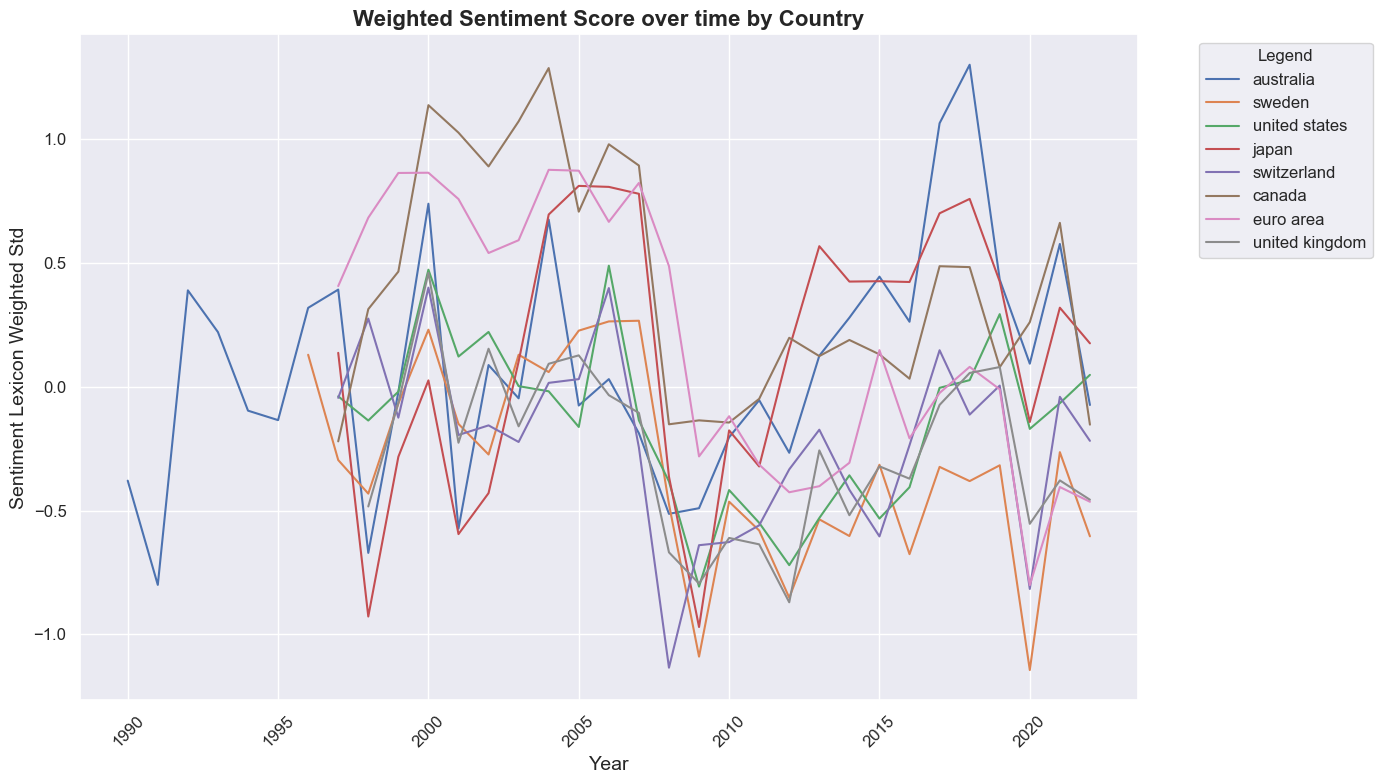

In [206]:
generate_multi_lineplot(speeches_yearly, x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue='country', \
                        title= 'Weighted Sentiment Score over time by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None)

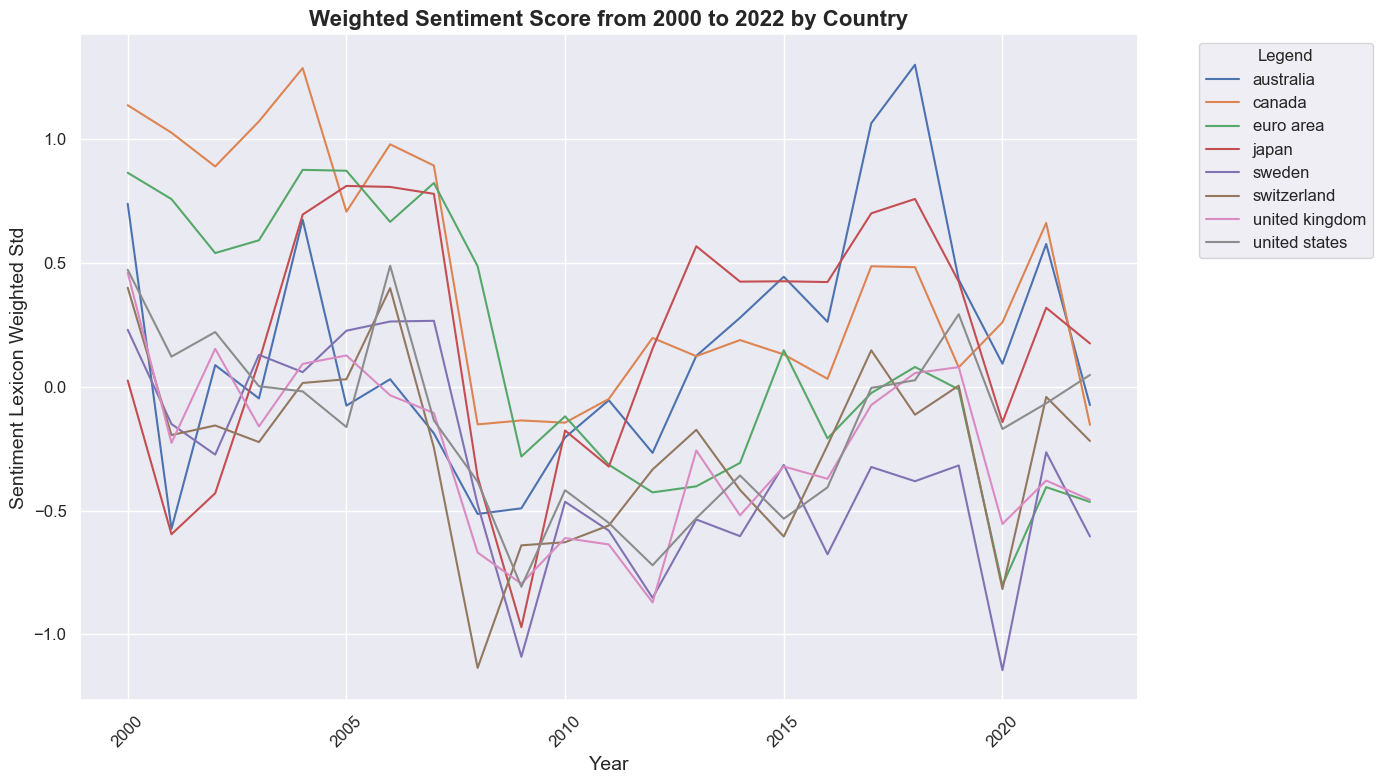

In [210]:
generate_multi_lineplot(speeches_2000_2022_yearly, x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue='country', \
                        title= 'Weighted Sentiment Score from 2000 to 2022 by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None)

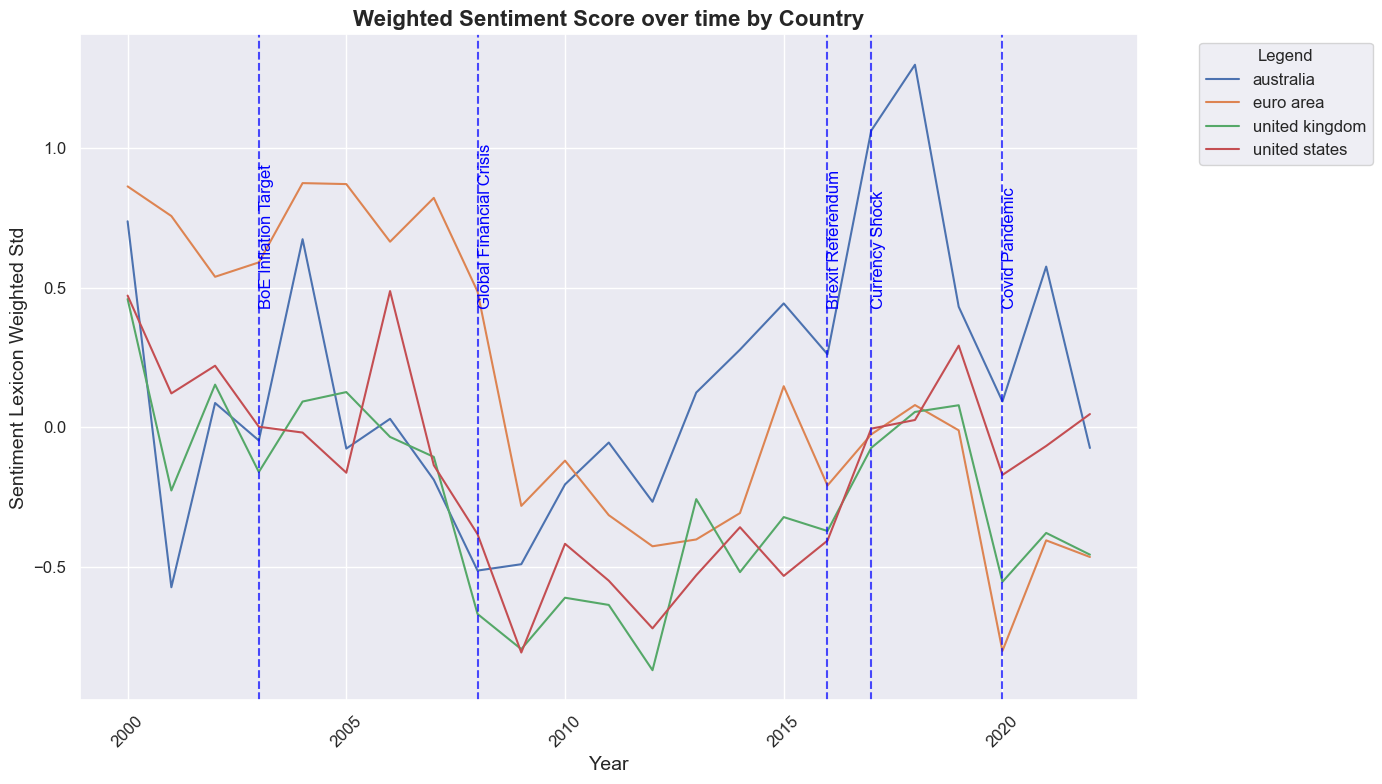

In [212]:
generate_multi_lineplot(speeches_2000_2022_yearly[speeches_2000_2022_yearly['country'].isin(countries_to_display)], \
                        x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue='country', \
                        title= 'Weighted Sentiment Score over time by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None, event_years=events)

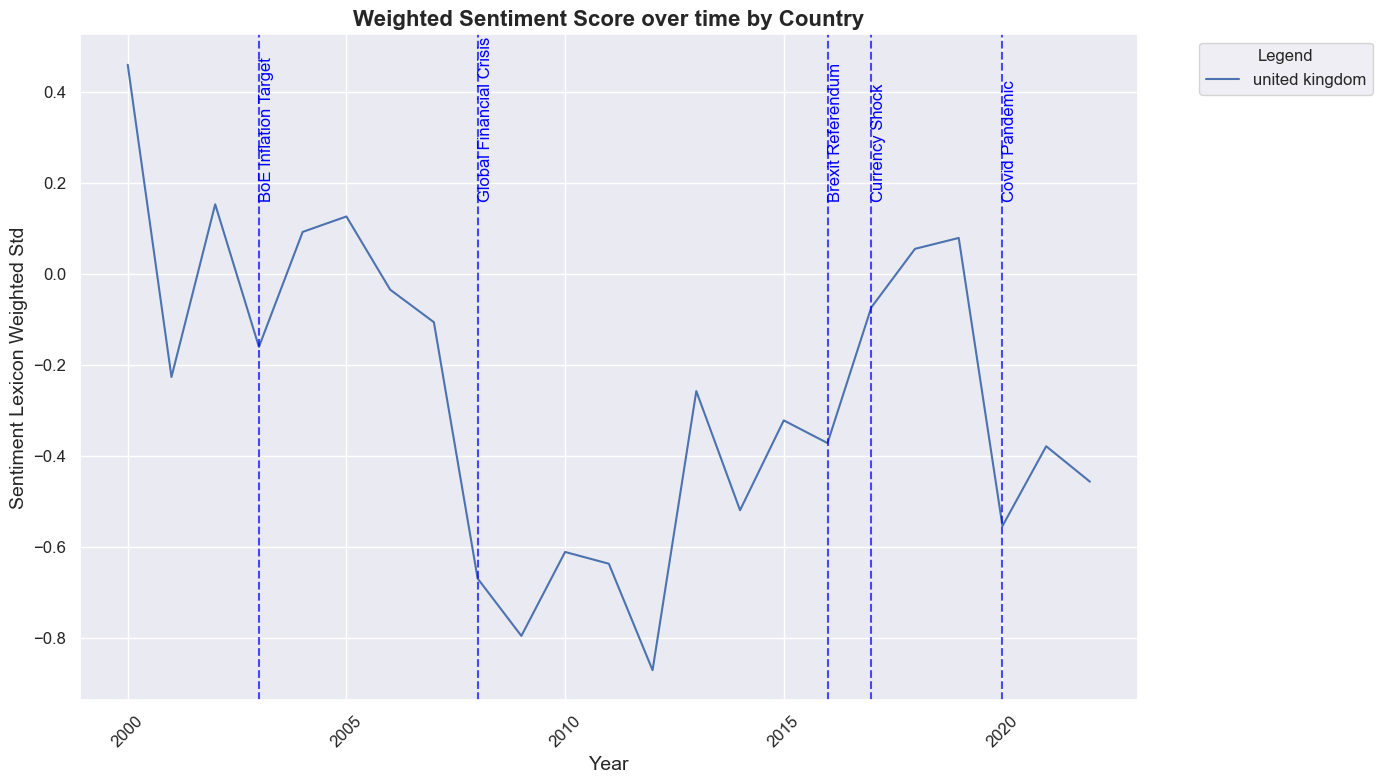

In [214]:
generate_multi_lineplot(speeches_2000_2022_yearly[speeches_2000_2022_yearly['country'].isin(country_to_display)], \
                        x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue='country', \
                        title= 'Weighted Sentiment Score over time by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None, event_years=events)

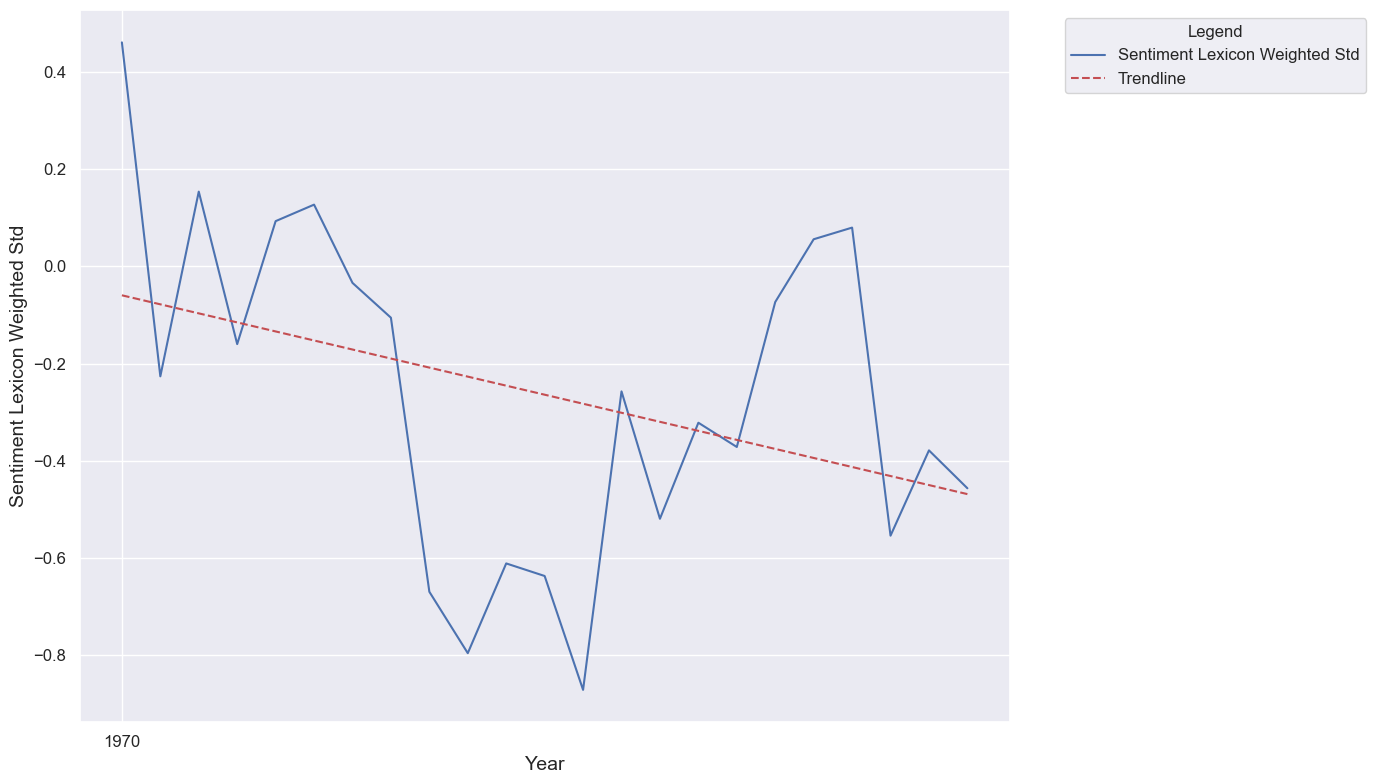

In [216]:
generate_lineplot_with_trendline(boe_speeches_2000_2022_yearly, x_axis='year', y_axis='sentiment_lexicon_weighted_std', \
                                 title=None, date=None, ylim=None, rotate_xticks=False, save_path=None, errorbar=None)

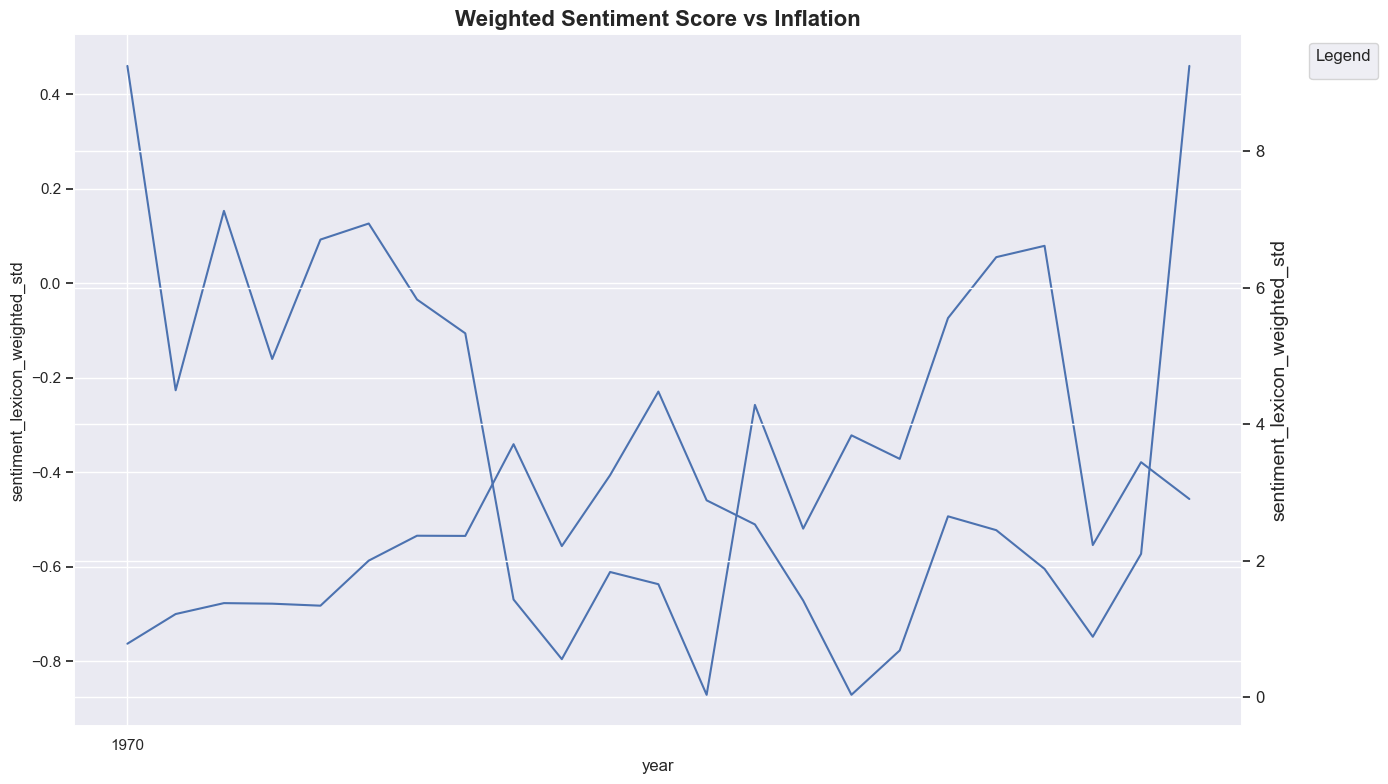

In [218]:
lineplot_two_axis(boe_speeches_2000_2022_yearly, x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue=None, \
                  title='Weighted Sentiment Score vs Inflation', 
                    second_y='uk_inflation_rate_CPIH', second_y_label='UK Inflation',
                            date=None, ylim=None, save_path=None, 
                            errorbar=None, events=None, event_years=None)

### 3.2. View BoE data in a wordclouds 

In [220]:
def show_wordcloud(counter):
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_top_non_stopwords_wordcloud(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    # Show the word cloud
    show_wordcloud(counter)

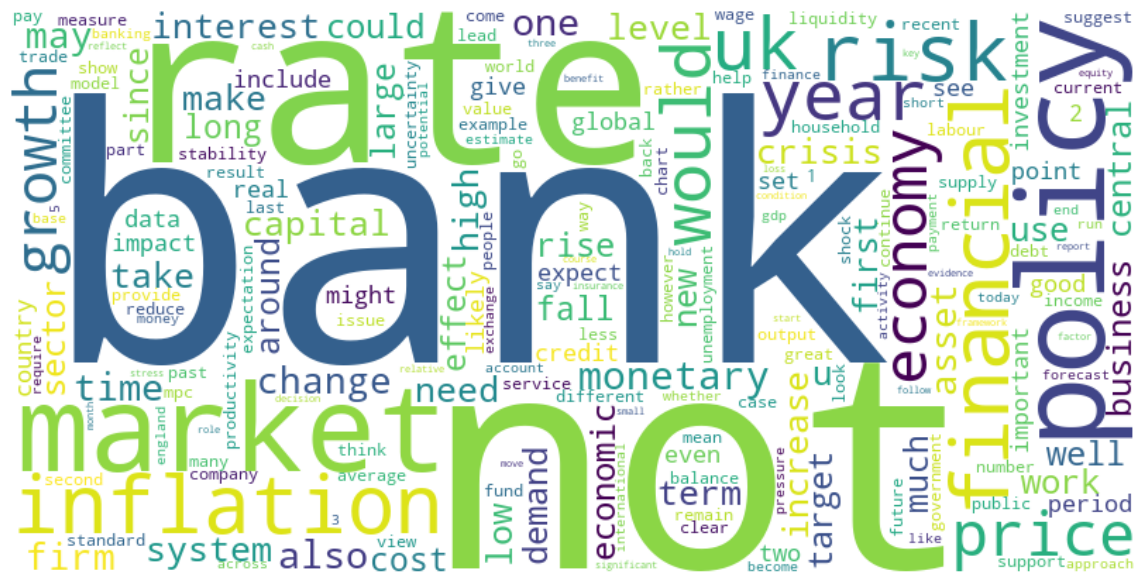

In [222]:
# Create wordcloud of lemmatised text
plot_top_non_stopwords_wordcloud(boe_speeches['text_lemmatised_str'])

In [223]:
# Define bar chart for top words
def top_words_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    # Set plot size
    plt.figure(figsize=(12, 8))
    
    # Plot
    sns.barplot(x=y, y=x)
    
    # Set label font sizes
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.title('Top Non-Stopword Words', fontsize=16)
    plt.tight_layout()
    plt.show()

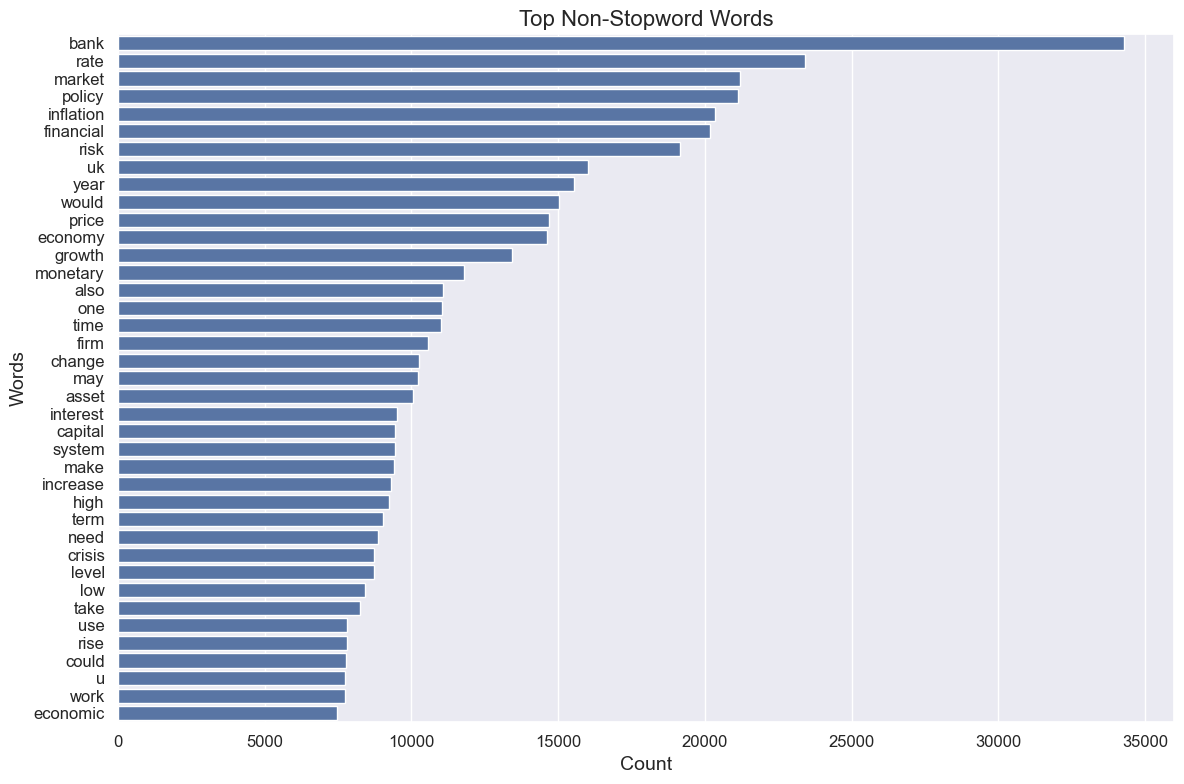

In [226]:
# Create bar chart to show top words
top_words_barchart(boe_speeches['text_lemmatised_str'])

In [228]:
# Define bar chart for top word groups
def top_word_group_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

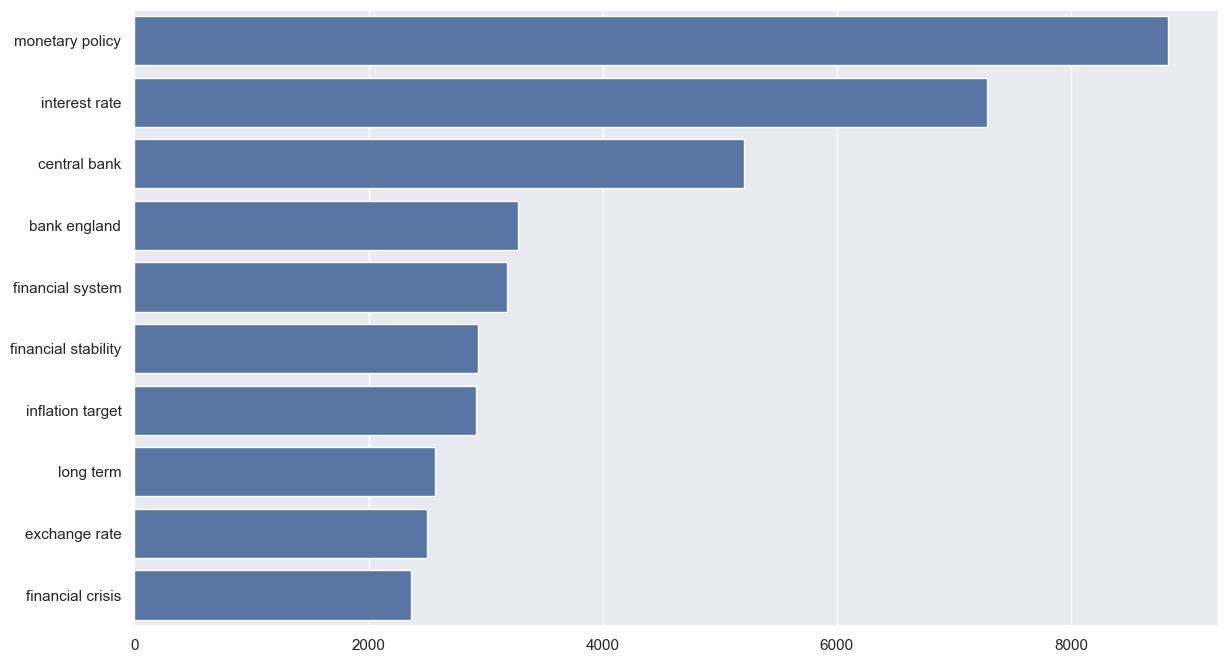

In [230]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],2)

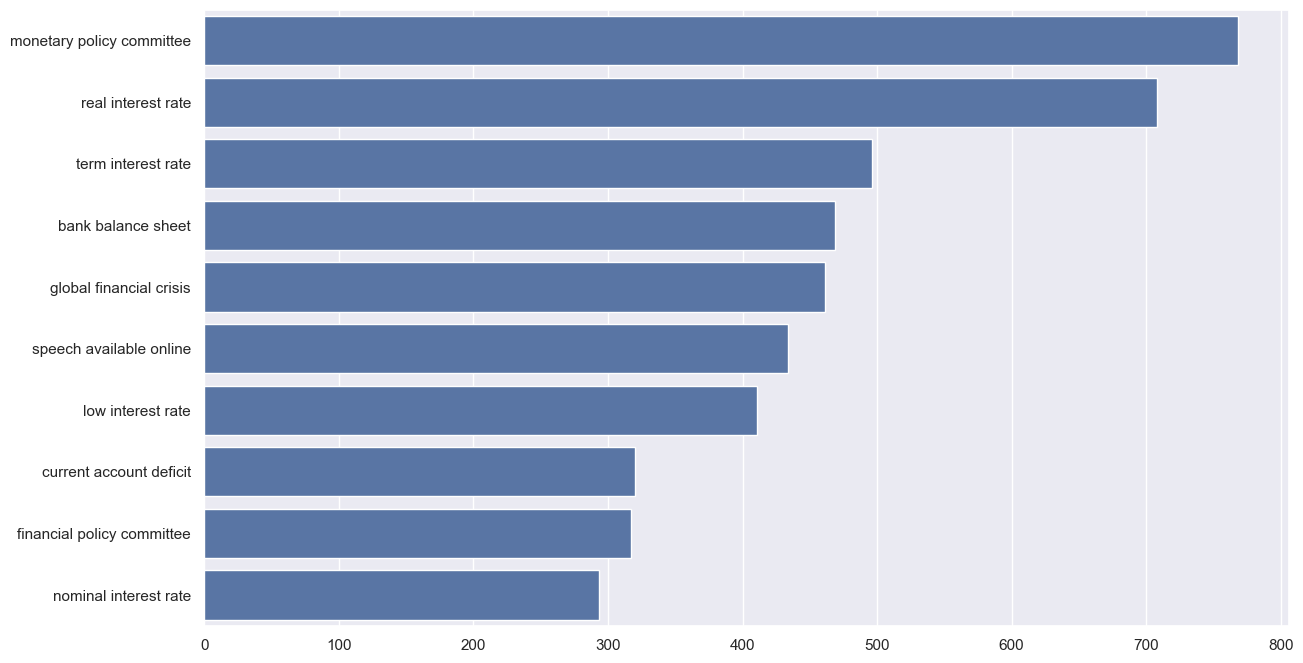

In [231]:
# Plot top phrases with 3 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],3)

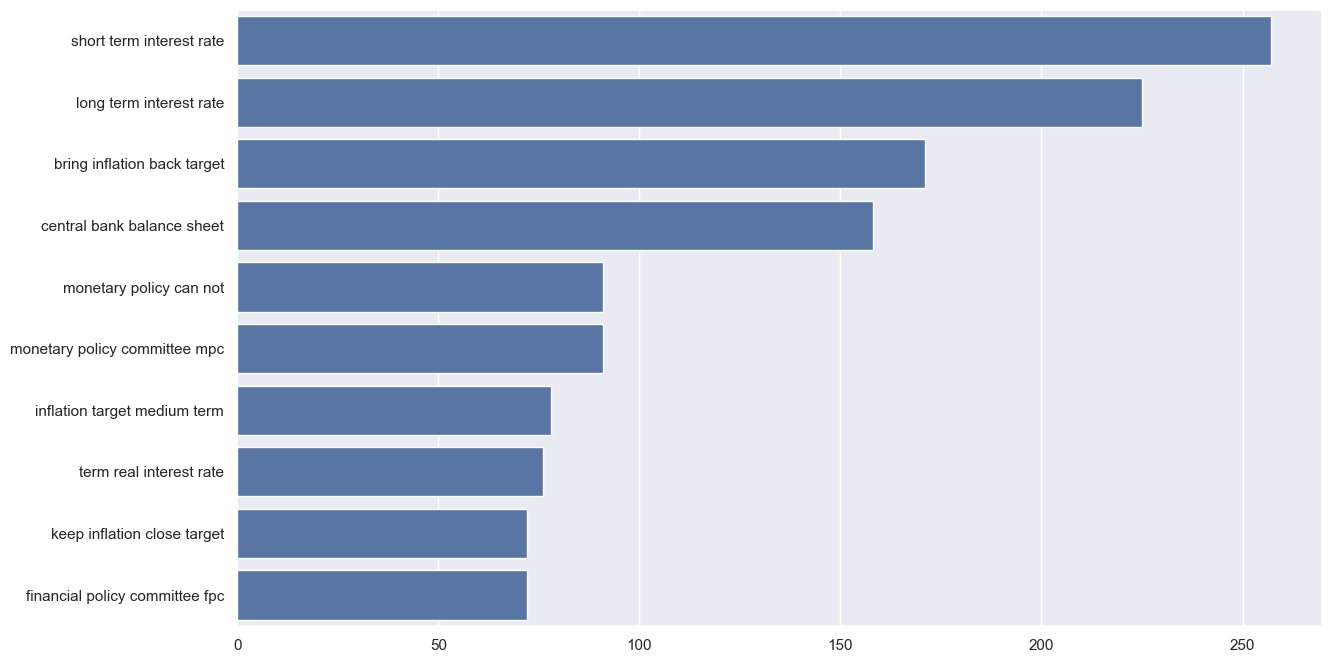

In [232]:
# Plot top phrases with 4 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],4)

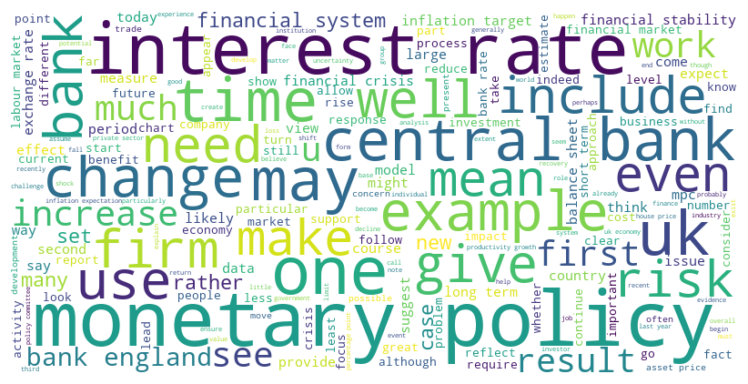

In [233]:
# Convert tokens into a single string.
boe_speeches_text = ' '.join(boe_speeches['text_lemmatised_str'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(boe_speeches_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axis.
plt.axis('off') 

# Dispaly the word cloud.
plt.tight_layout()
plt.show()

### 3.3. BoE Speech Statistics

**3.3.a. Word Count per Year**

In [268]:
# Group and aggregate sentiment scores by month
wordcount_monthly = boe_indicators_2000_2022.groupby('year_month_dt').agg({'word_count_text': 'mean',
                                                                       'word_count_text_cleaned': 'mean',
                                                                       'reference': 'count'
                                                                      }).reset_index().rename(columns={'reference': 'speech_count'})
# View the DataFrame
wordcount_monthly.head()

year_month_dt  word_count_text  word_count_text_cleaned  speech_count
0    2000-01-01      3014.333333              1596.666667             3
1    2000-02-01      3714.200000              2026.000000             5
2    2000-03-01      3764.750000              2059.750000             4
3    2000-04-01      2749.666667              1502.000000             3
4    2000-05-01      3509.750000              1920.250000             4

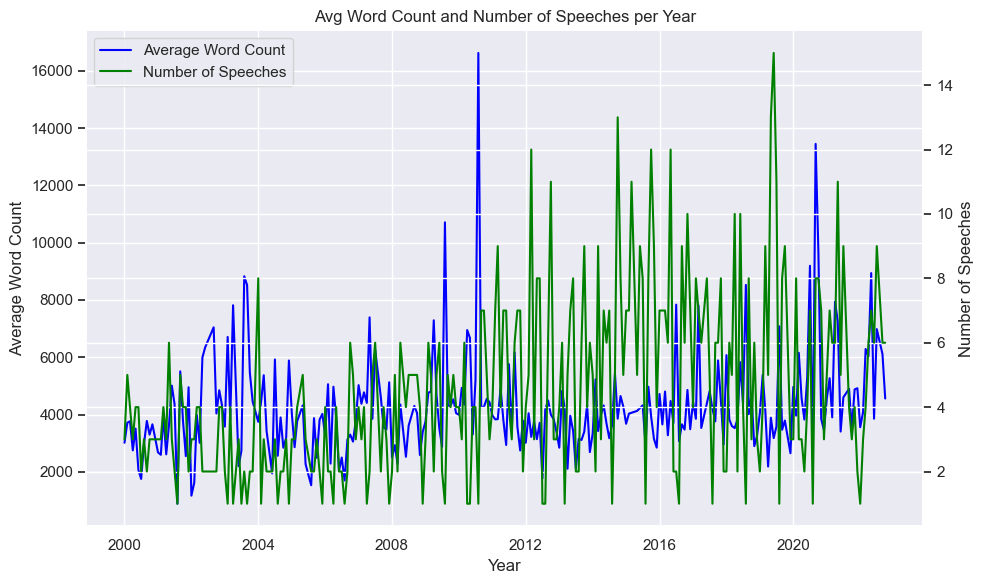

In [270]:
# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'word_count' on the primary y-axis
ax1.plot(wordcount_monthly['year_month_dt'], wordcount_monthly['word_count_text'], color='blue', label='Average Word Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Word Count')
ax1.tick_params(axis='y')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot 'speech_count' on the secondary y-axis
ax2.plot(wordcount_monthly['year_month_dt'], wordcount_monthly['speech_count'], color='green', label='Number of Speeches')
ax2.set_ylabel('Number of Speeches')
ax2.tick_params(axis='y')

# Add titles and grid if needed
plt.title('Avg Word Count and Number of Speeches per Year')

# Optionally, add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [262]:
# Group and aggregate sentiment scores by year
wordcount_yearly = boe_indicators_2000_2022.groupby('year').agg({'word_count_text': 'mean',
                                                                       'word_count_text_cleaned': 'mean',
                                                                       'reference': 'count'
                                                                      }).reset_index().rename(columns={'reference': 'speech_count'})

# View the DataFrame
wordcount_yearly.head()

year  word_count_text  word_count_text_cleaned  speech_count
0  2000      3168.472222              1707.055556            36
1  2001      3716.375000              2049.550000            40
2  2002      3996.500000              2184.500000            30
3  2003      4854.000000              2679.684211            19
4  2004      3948.000000              2174.642857            28

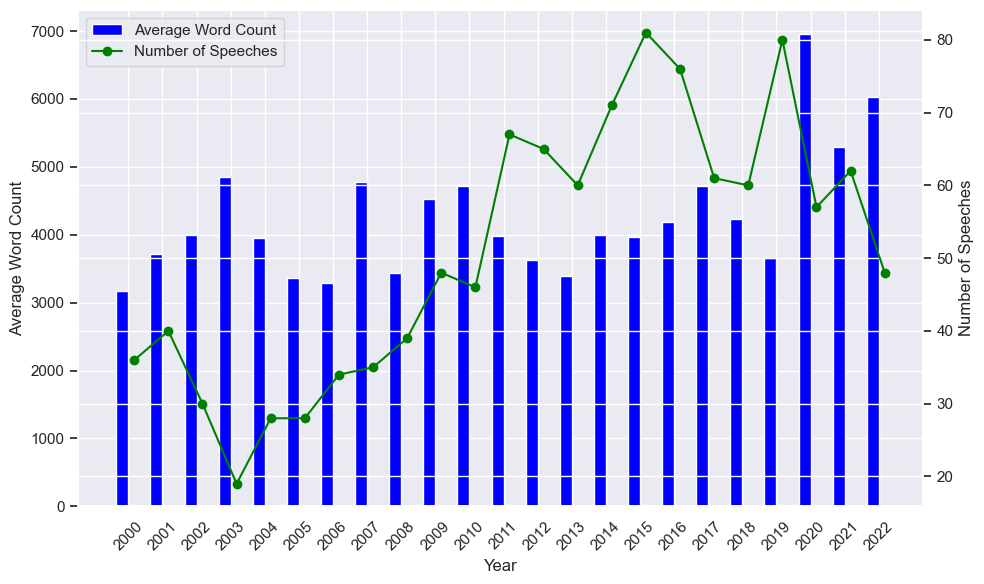

In [570]:
years = wordcount_count_yearly['year']
n_years = len(years)
x = np.arange(n_years)
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for 'word_count_text'
ax1.bar(x - width/2, wordcount_yearly['word_count_text'], width, color='blue', label='Average Word Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Word Count')
ax1.set_xticks(x)
ax1.set_xticklabels(years, rotation=45)

# Create the secondary axis
ax2 = ax1.twinx()

# Line plot for 'speech_count' without log scale
ax2.plot(x + width/2, wordcount_yearly['speech_count'], color='green', marker='o', label='Number of Speeches')

ax2.set_ylabel('Number of Speeches')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

**3.3.b. Speeches by Govenor and Non-Govenor**

In [274]:
# Group and aggregate number of speeches by governor by year
boe_indicators_2000_2022_gov_yearly = boe_indicators_2000_2022.groupby(['year', 'is_gov']).size().reset_index(name='count')

# View the DataFrame
boe_indicators_2000_2022_gov_yearly.head()

year  is_gov  count
0  2000       0     19
1  2000       1     17
2  2001       0     27
3  2001       1     13
4  2002       0     14

In [276]:
# Pivot the data for plotting
boe_indicators_2000_2022_gov_yearly_pivot = boe_indicators_2000_2022_gov_yearly.pivot(index='year', \
                                                                                      columns='is_gov', values='count').fillna(0)

# View the DataFrame
boe_indicators_2000_2022_gov_yearly_pivot.head()

is_gov   0   1
year          
2000    19  17
2001    27  13
2002    14  16
2003    14   5
2004    20   8

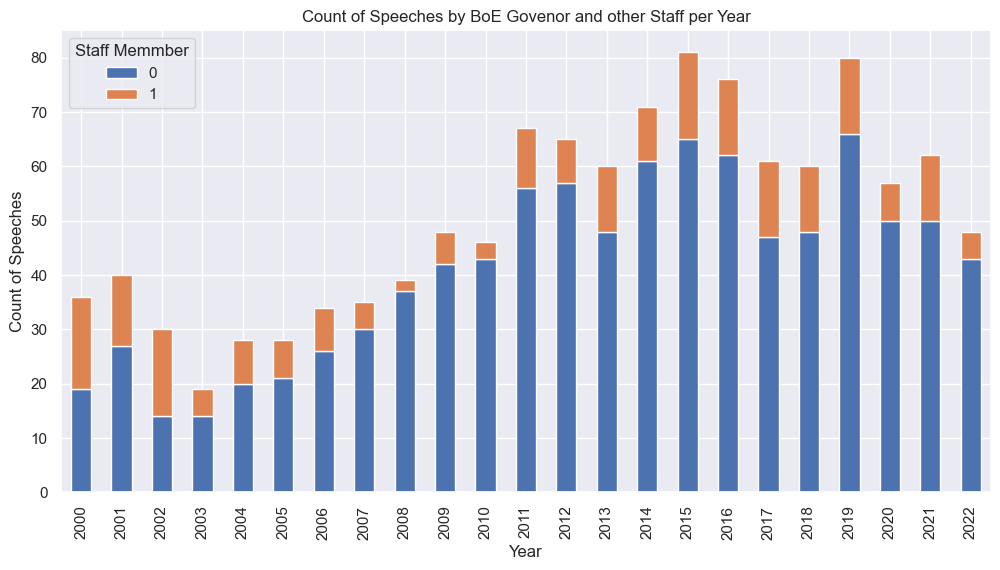

In [278]:
# Plot a bar chart per month
ax = boe_indicators_2000_2022_gov_yearly_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Count of Speeches')
ax.set_title('Count of Speeches by BoE Govenor and other Staff per Year')
ax.legend(title='Staff Memmber')

# Display the plot
plt.show()

### 3.4.Seasonality Analysis

**3.4.a. BoE Analysis**

In [290]:
# Group and aggregate sentiment scores by month
boe_sentiment_monthly = boe_indicators_2000_2022.groupby('year_month_dt')[['sentiment_lexicon_weighted_std']].mean().reset_index()

# View the DataFrame.
boe_sentiment_monthly.head()

year_month_dt  sentiment_lexicon_weighted_std
0    2000-01-01                        0.128783
1    2000-02-01                        0.509094
2    2000-03-01                        0.680356
3    2000-04-01                       -0.072648
4    2000-05-01                        0.125045

In [292]:
# Set the datetime as index
boe_sentiment_monthly.set_index('year_month_dt', inplace=True)

# View the DataFrame
boe_sentiment_monthly.head()

sentiment_lexicon_weighted_std
year_month_dt                                
2000-01-01                           0.128783
2000-02-01                           0.509094
2000-03-01                           0.680356
2000-04-01                          -0.072648
2000-05-01                           0.125045

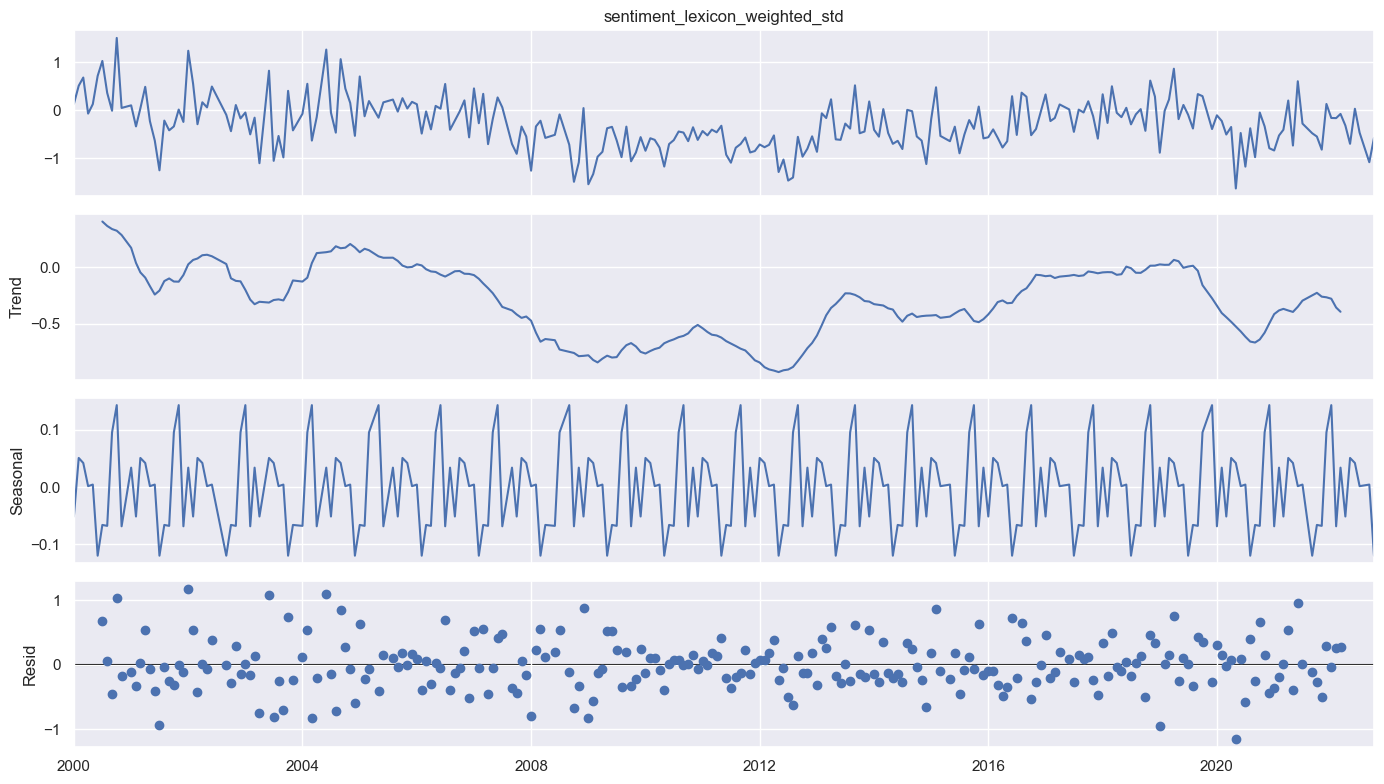

In [294]:
# Perform decomposition
boe_sentiment_decomposed = seasonal_decompose(boe_sentiment_monthly['sentiment_lexicon_weighted_std'], model='additive', period=12)

# Plot the decomposition
boe_sentiment_decomposed.plot()
plt.show()

**Observations Peaks**
- August 2013: Peak with a speech announcing Jane Austen on 10 GBP note and a discussion of the evolution of monetary policy since 2008-2009 crisis
- January 2022: speech about inflation with a sense of urgency about controlling inflation with reassurance that the Bank is actively monitoring and prepared to act responsibly. 

In [305]:
# Copy the data to prepare it quarterly
boe_sentiment_quarterly = boe_indicators_2000_2022.groupby('year_month_dt')[['sentiment_lexicon_weighted_std']].mean().reset_index()

In [309]:
# Extract year and quarter
boe_sentiment_quarterly['year'] = boe_sentiment_quarterly['year_month_dt'].dt.year
boe_sentiment_quarterly['quarter'] = boe_sentiment_quarterly['year_month_dt'].dt.quarter

# Group by year and quarter
boe_sentiment_quarterly = boe_sentiment_quarterly.groupby(['year', 'quarter'])[['sentiment_lexicon_weighted_std']].mean().reset_index()

# Create a 'quarter_start' date if needed
boe_sentiment_quarterly['quarter_start'] = pd.to_datetime(boe_sentiment_quarterly['year'].astype(str) + 'Q' \
                                                          + boe_sentiment_quarterly['quarter'].astype(str))

# View the DataFrame
boe_sentiment_quarterly.head()

year  quarter  sentiment_lexicon_weighted_std quarter_start
0  2000        1                        0.439411    2000-01-01
1  2000        2                        0.255544    2000-04-01
2  2000        3                        0.457944    2000-07-01
3  2000        4                        0.776416    2000-10-01
4  2001        1                       -0.067664    2001-01-01

In [311]:
# Set the datetime as index
boe_sentiment_quarterly.set_index('quarter_start', inplace=True)

# View the DataFrame
boe_sentiment_quarterly

year  quarter  sentiment_lexicon_weighted_std
quarter_start                                               
2000-01-01     2000        1                        0.439411
2000-04-01     2000        2                        0.255544
2000-07-01     2000        3                        0.457944
2000-10-01     2000        4                        0.776416
2001-01-01     2001        1                       -0.067664
...             ...      ...                             ...
2021-10-01     2021        4                       -0.416161
2022-01-01     2022        1                       -0.136690
2022-04-01     2022        2                       -0.332397
2022-07-01     2022        3                       -0.778798
2022-10-01     2022        4                       -0.580249

[92 rows x 3 columns]

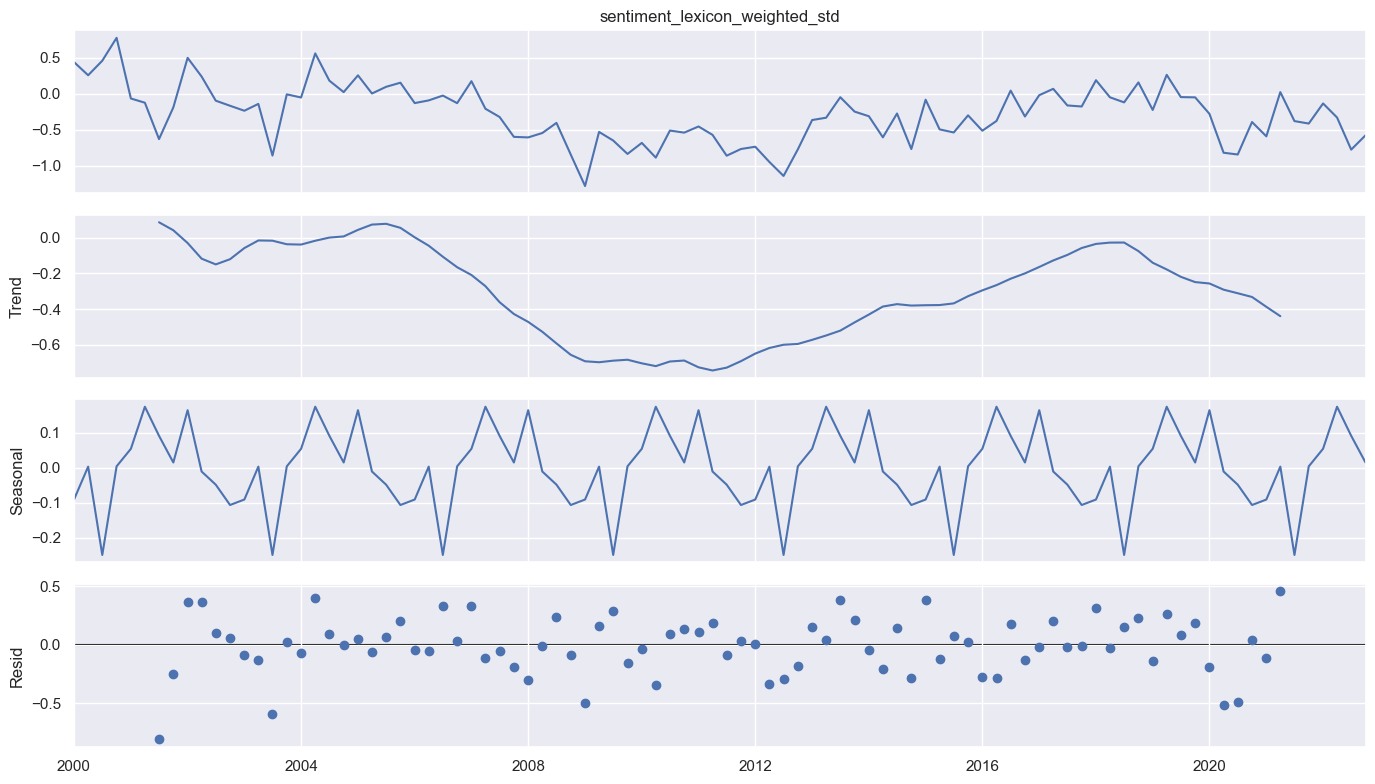

In [313]:
# Perform decomposition
boe_sentiment_decomposed_quarterly = seasonal_decompose(boe_sentiment_quarterly['sentiment_lexicon_weighted_std'], \
                                                        model='additive', period=12)

# Plot the decomposition
boe_sentiment_decomposed_quarterly.plot()
plt.show()

**3.4.b. BoE Governor Analysis**

In [381]:
# Filter speeches for governors only
boe_indicators_2000_2022_gov = boe_indicators_2000_2022[boe_indicators_2000_2022['is_gov'] == 1]

# View the DataFrame
boe_indicators_2000_2022_gov.head()

index     reference         country date_format year_month  year  \
0     38  r000107a_BOE  united kingdom  2000-01-07    2000-01  2000   
1     39  r000118a_BOE  united kingdom  2000-01-18    2000-01  2000   
2     40  r000126a_BOE  united kingdom  2000-01-26    2000-01  2000   
3     41  r000214a_BOE  united kingdom  2000-02-14    2000-02  2000   
4     42  r000216a_BOE  united kingdom  2000-02-16    2000-02  2000   

  year_month_dt                                      title  author  is_gov  \
0    2000-01-01        Monetary Policy: Theory in Practice    king       1   
1    2000-01-01                        City Council Dinner  george       1   
2    2000-01-01                                 Lunch 2000  george       1   
3    2000-02-01                Bankers Club Annual Banquet  george       1   
4    2000-02-01  The Euromoney International Bond Congress  george       1   

   ... uk_interest_rate uk_consumer_confidence gbp_usd_fx     ftse_250  \
0  ...             5.75                    3.2   1.640185  6433.850488   
1  ...             5.75                    3.2   1.640185  6433.850488   
2  ...             5.75                    3.2   1.640185  6433.850488   
3  ...             6.00                    1.3   1.599814  6227.492862   
4  ...             6.00                    1.3   1.599814  6227.492862   

   gilts_short   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0          6.35           5.74         4.69                    12.6   
1          6.35           5.74         4.69                    12.6   
2          6.35           5.74         4.69                    12.6   
3          6.22           5.55         4.57                    12.4   
4          6.22           5.55         4.57                    12.4   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                      20.0                         77950  
1                      20.0                         77950  
2                      20.0                         77950  
3                      20.2                         77950  
4                      20.2                         77950  

[5 rows x 32 columns]

In [383]:
# Group and aggregate sentiment scores by month
boe_sentiment_gov_monthly = boe_indicators_2000_2022_gov.groupby('year_month_dt')[['sentiment_lexicon_weighted_std']] \
                                                                            .mean().reset_index()
# View the DataFrame
boe_sentiment_gov_monthly.head()

year_month_dt  sentiment_lexicon_weighted_std
0    2000-01-01                        0.128783
1    2000-02-01                        0.431445
2    2000-03-01                        0.064631
3    2000-04-01                       -0.197448
4    2000-06-01                        0.680515

In [385]:
boe_sentiment_gov_monthly.dtypes

year_month_dt                     datetime64[ns]
sentiment_lexicon_weighted_std           float64
dtype: object

In [387]:
# Set the datetime as index
boe_sentiment_gov_monthly.set_index('year_month_dt', inplace=True)

# View the DataFrame
boe_sentiment_gov_monthly.head()

sentiment_lexicon_weighted_std
year_month_dt                                
2000-01-01                           0.128783
2000-02-01                           0.431445
2000-03-01                           0.064631
2000-04-01                          -0.197448
2000-06-01                           0.680515

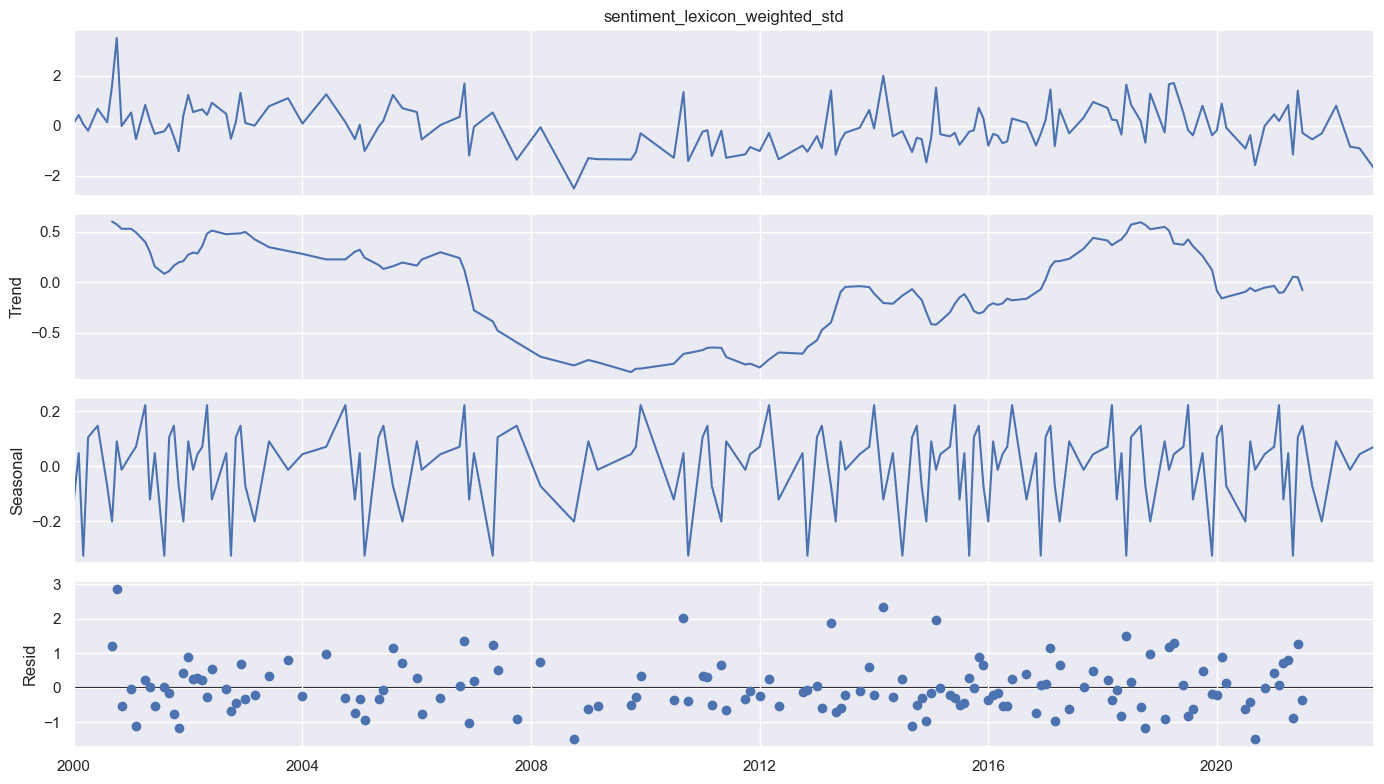

In [395]:
# Perform decomposition
boe_sentiment_gov_decomposed = seasonal_decompose(boe_sentiment_gov_monthly['sentiment_lexicon_weighted_std'], model='additive', period=12)

# Plot the decomposition
boe_sentiment_gov_decomposed.plot()
plt.show()

**Obersvations**: trend in governor speeches more positive - only during and following financial crisis is sentiment as negative

**3.4.c. All speeches and countries**

In [332]:
# Group and aggregate sentiment scores by month
sentiment_quarterly = speeches_2000_2022.groupby(['year_month_dt', 'country'])[['sentiment_lexicon_weighted_std']].mean().reset_index()

# View the DataFrame.
sentiment_quarterly.head()

year_month_dt         country  sentiment_lexicon_weighted_std
0    2000-01-01          canada                        1.723085
1    2000-01-01       euro area                        1.105004
2    2000-01-01          sweden                        0.394178
3    2000-01-01  united kingdom                        0.128783
4    2000-01-01   united states                       -0.338708

In [334]:
sentiment_quarterly.columns

Index(['year_month_dt', 'country', 'sentiment_lexicon_weighted_std'], dtype='object')

In [336]:
sentiment_quarterly.dtypes

year_month_dt                     datetime64[ns]
country                                   object
sentiment_lexicon_weighted_std           float64
dtype: object

In [338]:
# Extract year and quarter
sentiment_quarterly['year'] = sentiment_quarterly['year_month_dt'].dt.year
sentiment_quarterly['quarter'] = sentiment_quarterly['year_month_dt'].dt.quarter

# Group by year and quarter
sentiment_quarterly = sentiment_quarterly.groupby(['year', 'quarter', 'country'])[['sentiment_lexicon_weighted_std']].mean().reset_index()

# Create a 'quarter_start' date if needed
sentiment_quarterly['quarter_start'] = pd.to_datetime(sentiment_quarterly['year'].astype(str) + 'Q' \
                                                      + sentiment_quarterly['quarter'].astype(str))

# View the DataFrame
sentiment_quarterly

year  quarter         country  sentiment_lexicon_weighted_std  \
0    2000        1       australia                        0.306285   
1    2000        1          canada                        1.376824   
2    2000        1       euro area                        1.050702   
3    2000        1           japan                        0.132199   
4    2000        1          sweden                        0.370833   
..    ...      ...             ...                             ...   
715  2022        4       euro area                       -1.213409   
716  2022        4           japan                       -0.245186   
717  2022        4     switzerland                       -0.793997   
718  2022        4  united kingdom                       -0.580249   
719  2022        4   united states                       -0.230197   

    quarter_start  
0      2000-01-01  
1      2000-01-01  
2      2000-01-01  
3      2000-01-01  
4      2000-01-01  
..            ...  
715    2022-10-01  
716    2022-10-01  
717    2022-10-01  
718    2022-10-01  
719    2022-10-01  

[720 rows x 5 columns]

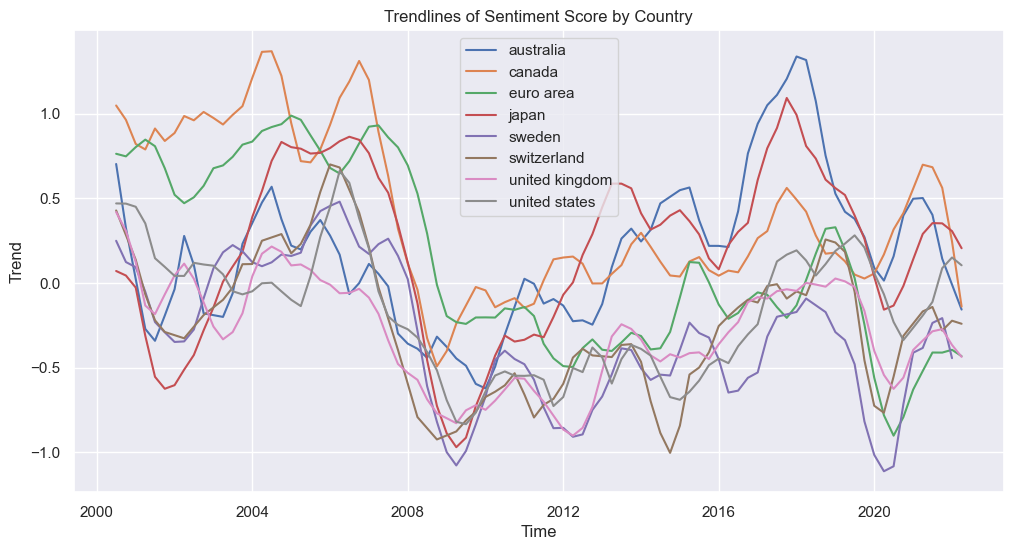

In [342]:
# Plot the trend chart for all countries
plt.figure(figsize=(12, 6))

for country, group in sentiment_quarterly.groupby('country'):
    # Set date as index
    group = group.set_index('quarter_start').sort_index()
    
    # Check for missing dates or gaps, handle if needed

    # Decompose to get trend
    result = seasonal_decompose(group['sentiment_lexicon_weighted_std'], model='additive', period=4)

    # Plot the trend
    plt.plot(group.index, result.trend, label=country)
    
plt.legend()
plt.title('Trendlines of Sentiment Score by Country')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()

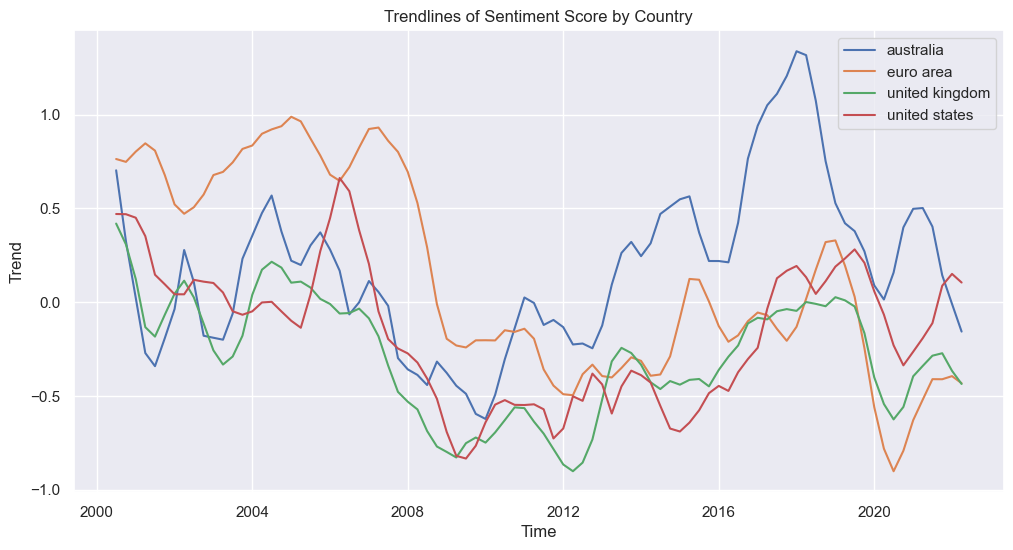

In [346]:
# Plot the trend chart only for UK, USA, Euro Area and Australia
plt.figure(figsize=(12, 6))

for country, group in sentiment_quarterly[sentiment_quarterly['country'].isin(countries_to_display)].groupby('country'):
    # Set date as index
    group = group.set_index('quarter_start').sort_index()
    
    # Check for missing dates or gaps, handle if needed

    # Decompose to get trend
    result = seasonal_decompose(group['sentiment_lexicon_weighted_std'], model='additive', period=4)

    # Plot the trend
    plt.plot(group.index, result.trend, label=country)
    
plt.legend()
plt.title('Trendlines of Sentiment Score by Country')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()

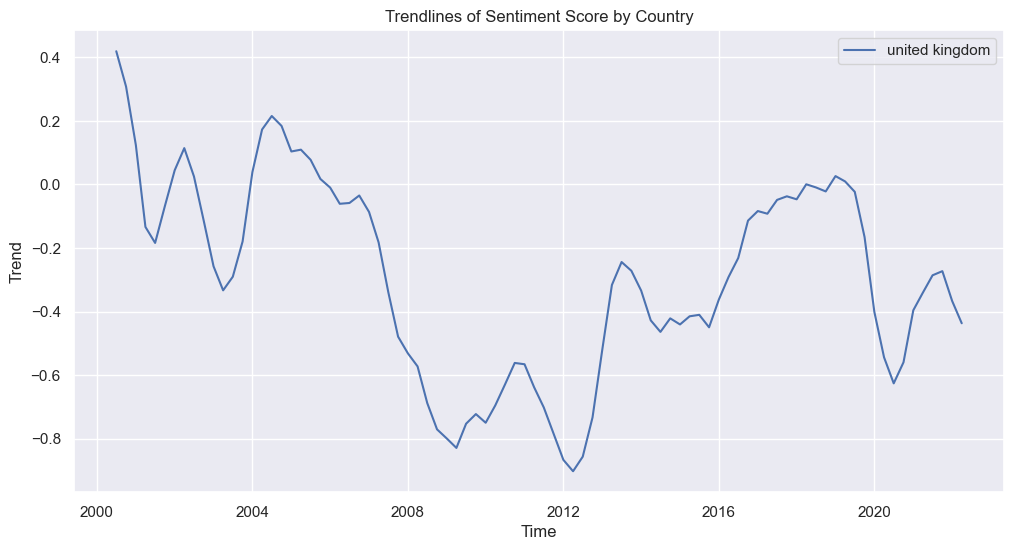

In [348]:
# PLot the chart for UK only
plt.figure(figsize=(12, 6))

for country, group in sentiment_quarterly[sentiment_quarterly['country'].isin(country_to_display)].groupby('country'):
    # Set date as index
    group = group.set_index('quarter_start').sort_index()
    
    # Check for missing dates or gaps, handle if needed

    # Decompose to get trend
    result = seasonal_decompose(group['sentiment_lexicon_weighted_std'], model='additive', period=4)

    # Plot the trend
    plt.plot(group.index, result.trend, label=country)
    
plt.legend()
plt.title('Trendlines of Sentiment Score by Country')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()

### 3.5. Topic Analysis

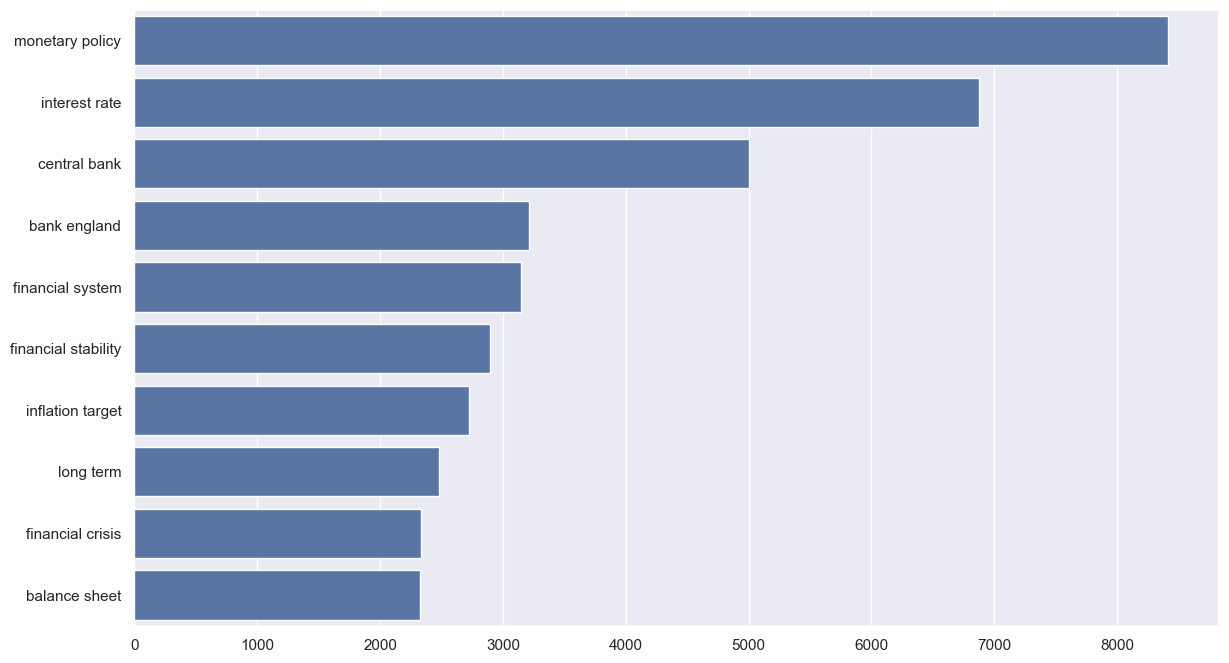

In [409]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_indicators_2000_2022['text_lemmatised_str'],2)

In [417]:
# Let's say 'top_bigrams' is your list of most common bigram strings
top_bigrams = ['monetary policy', 'interest rate', ' central bank', 'financial system', 'financial stability', 'inflation target', \
              'long term', 'financial crisis', 'balance sheet']  # Replace with actual bigrams

# Initialize a dictionary to store counts
bigram_counts = {bigram: 0 for bigram in top_bigrams}

# Loop through speeches and count how many contain each bigram
for index, row in boe_indicators_2000_2022.iterrows():
    speech_text = row['text_lemmatised_str'].lower()
    for bigram in top_bigrams:
        if bigram in speech_text:
            bigram_counts[bigram] += 1

# Convert to DataFrame for better visualization
bigram_counts_boe = pd.DataFrame(bigram_counts.items(), columns=['Bigram', 'Count']).sort_values(by='Count', ascending=False)

# View the DataFrame
bigram_counts_boe

Bigram  Count
0      monetary policy    811
1        interest rate    791
2         central bank    724
6            long term    709
7     financial crisis    653
3     financial system    652
4  financial stability    569
8        balance sheet    562
5     inflation target    522

In [419]:
from sklearn.feature_extraction.text import CountVectorizer

# Bigrams to search for
target_bigrams = ['monetary policy', 'interest rate', 'financial stability', 'inflation target', 'financial crisis']

# Fit CountVectorizer on all speeches
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(boe_indicators_2000_2022['text_lemmatised_str'].str.lower())

# Create a DataFrame of counts
bigram_counts_df = pd.DataFrame(X.toarray(), index=boe_indicators_2000_2022.index, columns=vectorizer.get_feature_names_out())

# For each target bigram, add a column with its count
for bigram in target_bigrams:
    if bigram in bigram_counts_df.columns:
        boe_indicators_2000_2022[f'bigram_count_{bigram}'] = bigram_counts_df[bigram]
    else:
        # Bigram not found in the data
        boe_indicators_2000_2022[f'bigram_count_{bigram}'] = 0

In [421]:
boe_indicators_2000_2022

index     reference         country date_format year_month  year  \
0        38  r000107a_BOE  united kingdom  2000-01-07    2000-01  2000   
1        39  r000118a_BOE  united kingdom  2000-01-18    2000-01  2000   
2        40  r000126a_BOE  united kingdom  2000-01-26    2000-01  2000   
3        41  r000214a_BOE  united kingdom  2000-02-14    2000-02  2000   
4        42  r000216a_BOE  united kingdom  2000-02-16    2000-02  2000   
...     ...           ...             ...         ...        ...   ...   
1166   1204  r221007a_BOE  united kingdom  2022-10-07    2022-10  2022   
1167   1205  r221012a_BOE  united kingdom  2022-10-12    2022-10  2022   
1168   1206  r221015a_BOE  united kingdom  2022-10-15    2022-10  2022   
1169   1207  r221019a_BOE  united kingdom  2022-10-19    2022-10  2022   
1170   1208  r221020a_BOE  united kingdom  2022-10-20    2022-10  2022   

     year_month_dt                                              title  \
0       2000-01-01                Monetary Policy: Theory in Practice   
1       2000-01-01                                City Council Dinner   
2       2000-01-01                                         Lunch 2000   
3       2000-02-01                        Bankers Club Annual Banquet   
4       2000-02-01          The Euromoney International Bond Congress   
...            ...                                                ...   
1166    2022-10-01         Shocks, inflation, and the policy response   
1167    2022-10-01    Monetary policy: an anchor in challenging times   
1168    2022-10-01  Monetary policy and financial stability interv...   
1169    2022-10-01  Governance of “Decentralised” Finance: Get up,...   
1170    2022-10-01       The inflationary consequences of real shocks   

         author  is_gov  ... gilts_medium  gilts_long  uk_credit_growth_no_cc  \
0          king       1  ...      5.740000    4.690000                   12.6   
1        george       1  ...      5.740000    4.690000                   12.6   
2        george       1  ...      5.740000    4.690000                   12.6   
3        george       1  ...      5.550000    4.570000                   12.4   
4        george       1  ...      5.550000    4.570000                   12.4   
...         ...     ...  ...           ...         ...                    ...   
1166    ramsden       0  ...      3.959858    4.129311                    5.1   
1167       pill       0  ...      3.959858    4.129311                    5.1   
1168     bailey       1  ...      3.959858    4.129311                    5.1   
1169    wilkins       0  ...      3.959858    4.129311                    5.1   
1170  broadbent       0  ...      3.959858    4.129311                    5.1   

      uk_credit_growth_only_cc  avg_price_all_property_types  \
0                         20.0                         77950   
1                         20.0                         77950   
2                         20.0                         77950   
3                         20.2                         77950   
4                         20.2                         77950   
...                        ...                           ...   
1166                      11.5                        265693   
1167                      11.5                        265693   
1168                      11.5                        265693   
1169                      11.5                        265693   
1170                      11.5                        265693   

      bigram_count_monetary policy  bigram_count_interest rate  \
0                               35                          12   
1                                5                          10   
2                                7                           2   
3                                2                           3   
4                                1                           3   
...                            ...                         ...   
1166                            12  

In [520]:
# Filter speeches with 'monetary policy' > 5
boe_monetary_policy = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_monetary policy'] > 5]

In [522]:
monetary_policy_avg_yearly = boe_monetary_policy.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
monetary_policy_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Monetary Policy'}, inplace=True)

In [524]:
# Filter speeches with 'interest rate' > 5
boe_interest_rate = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_interest rate'] > 5]

In [526]:
interest_rate_avg_yearly = boe_interest_rate.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
interest_rate_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Interest Rate'}, inplace=True)

In [467]:
# Filter speeches with 'interest rate' > 5
boe_financial_stability = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_financial stability'] > 5]

In [528]:
financial_stability_avg_yearly = boe_financial_stability.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
financial_stability_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Financial Stability'}, inplace=True)

In [471]:
# Filter speeches with 'inflation target' > 5
boe_inflation_target = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_inflation target'] > 5]

In [530]:
inflation_target_avg_yearly = boe_inflation_target.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
inflation_target_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Inflation Target'}, inplace=True)

In [475]:
# Filter speeches with 'inflation target' > 5
boe_financial_crisis = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_financial crisis'] > 5]

In [531]:
financial_crisis_avg_yearly = boe_financial_crisis.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
financial_crisis_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Financial Crisis'}, inplace=True)

In [510]:
# List of DataFrames to merge
dataframes_to_merge = [interest_rate_avg_yearly, financial_stability_avg_yearly, inflation_target_avg_yearly, financial_crisis_avg_yearly]

# Use reduce to merge all DataFrames in the list
sentiment_by_topic = reduce(lambda left, right: left.merge(right, on='year', how='left'), dataframes_to_merge, monetary_policy_avg_yearly)

# View the merged DataFrame
sentiment_by_topic.head()

year  Monetary Policy  Interest Rate  Financial Stability  \
0  2000         0.359185       0.459351            -0.066008   
1  2001        -0.258638      -0.417713            -0.105369   
2  2002        -0.183465      -0.089257            -0.479015   
3  2003        -0.343153      -0.592901            -0.104170   
4  2004        -0.000459       0.042318            -0.451063   

   Inflation Target  Financial Crisis  
0          0.295159               NaN  
1         -0.883411         -0.537127  
2         -0.227566               NaN  
3         -0.700809         -0.396780  
4          0.059472               NaN

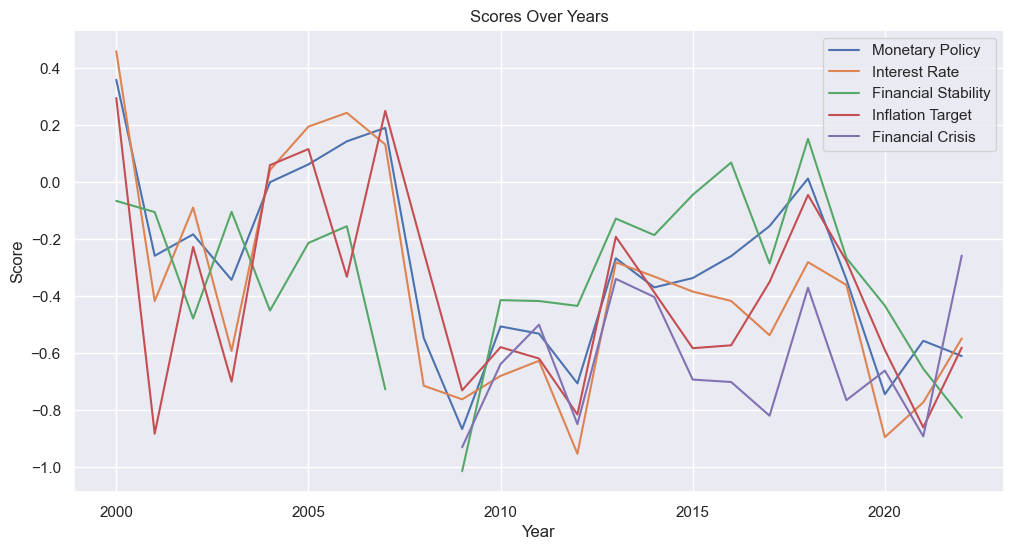

In [516]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# List your score columns
score_columns = ['Monetary Policy', 'Interest Rate', 'Financial Stability', 'Inflation Target', 'Financial Crisis']

for col in score_columns:
    plt.plot(sentiment_by_topic['year'], sentiment_by_topic[col], label=col)

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Scores Over Years')
plt.legend()
plt.show()

In [534]:
# Filter speeches with 'monetary policy' > 10
boe_monetary_policy_10 = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_monetary policy'] > 10]

In [536]:
monetary_policy_10_avg_yearly = boe_monetary_policy_10.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
monetary_policy_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Monetary Policy'}, inplace=True)

In [538]:
# Filter speeches with 'interest rate' > 10
boe_interest_rate_10 = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_interest rate'] > 10]

In [539]:
interest_rate_10_avg_yearly = boe_interest_rate_10.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
interest_rate_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Interest Rate'}, inplace=True)

In [542]:
# Filter speeches with 'interest rate' > 10
boe_financial_stability_10 = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_financial stability'] >10]

In [543]:
financial_stability_10_avg_yearly = boe_financial_stability_10.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
financial_stability_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Financial Stability'}, inplace=True)

In [546]:
# Filter speeches with 'inflation target' > 10
boe_inflation_target_10 = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_inflation target'] > 10]

In [547]:
inflation_target_10_avg_yearly = boe_inflation_target_10.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
inflation_target_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Inflation Target'}, inplace=True)

In [548]:
# Filter speeches with 'inflation target' > 10
boe_financial_crisis_10 = boe_indicators_2000_2022[boe_indicators_2000_2022['bigram_count_financial crisis'] > 10]

In [552]:
financial_crisis_10_avg_yearly = boe_financial_crisis_10.groupby('year')['sentiment_lexicon_weighted_std'].mean().reset_index()
financial_crisis_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted_std': 'Financial Crisis'}, inplace=True)

In [556]:
# List of DataFrames to merge
dataframes_to_merge = [interest_rate_10_avg_yearly, financial_stability_10_avg_yearly, inflation_target_10_avg_yearly, financial_crisis_10_avg_yearly]

# Use reduce to merge all DataFrames in the list
sentiment_by_topic_10 = reduce(lambda left, right: left.merge(right, on='year', how='left'), dataframes_to_merge, monetary_policy_10_avg_yearly)

# View the merged DataFrame
sentiment_by_topic_10.head()

year  Monetary Policy  Interest Rate  Financial Stability  \
0  2000         0.399348       0.178699            -0.066008   
1  2001        -0.505599      -0.901783            -0.251943   
2  2002        -0.208018      -0.067557                  NaN   
3  2003        -0.639040      -0.616929            -0.396780   
4  2004        -0.136438      -0.084372            -0.698072   

   Inflation Target  Financial Crisis  
0         -0.209825               NaN  
1               NaN               NaN  
2         -0.263839               NaN  
3         -0.670444               NaN  
4          0.059472               NaN

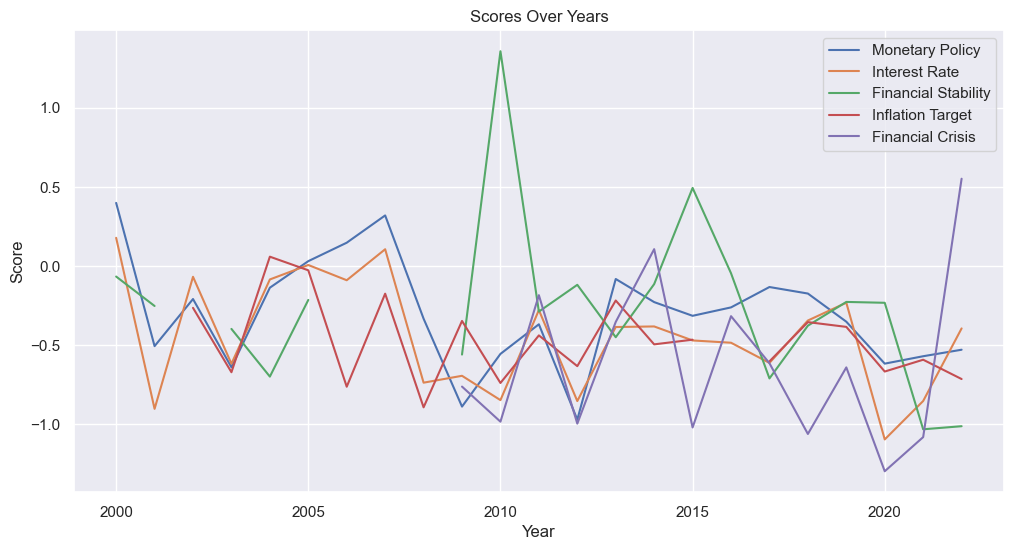

In [557]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# List your score columns
score_columns = ['Monetary Policy', 'Interest Rate', 'Financial Stability', 'Inflation Target', 'Financial Crisis']

for col in score_columns:
    plt.plot(sentiment_by_topic_10['year'], sentiment_by_topic[col], label=col)

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Scores Over Years')
plt.legend()
plt.show()

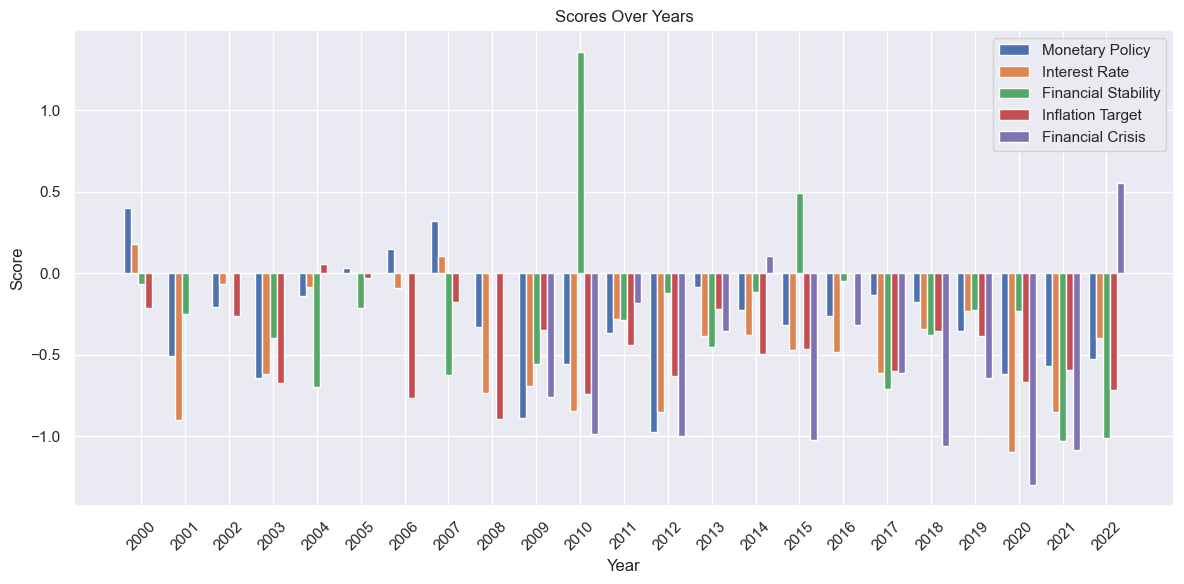

In [560]:
# Number of years and topics
years = sentiment_by_topic_10['year']
topics = score_columns
n_years = len(years)
n_topics = len(topics)

# Set bar width
bar_width = 0.8 / n_topics  # Total width divided among topics
x = np.arange(n_years)  # Positions for each year

plt.figure(figsize=(12, 6))

for i, col in enumerate(score_columns):
    # Offset positions for each topic
    offset = (i - n_topics / 2) * bar_width + bar_width/2
    plt.bar(x + offset, sentiment_by_topic[col], width=bar_width, label=col)

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Scores Over Years')
plt.xticks(x, years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [600]:
boe_indicators_2000_2022.columns

Index(['index', 'reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std',
       'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
       'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250',
       'gilts_short ', 'gilts_medium ', 'gilts_long ',
       'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
       'avg_price_all_property_types', 'bigram_count_monetary policy',
       'bigram_count_interest rate', 'bigram_count_financial stability',
       'bigram_count_inflation target', 'bigram_count_financial crisis'],
      dtype='object')

In [602]:
wordcount_speech = boe_indicators_2000_2022.groupby('year').agg({'bigram_count_monetary policy': 'mean',
                                                                 'bigram_count_interest rate': 'mean',
                                                                 'bigram_count_financial stability': 'mean',
                                                                 'bigram_count_inflation target': 'mean',
                                                                 'bigram_count_financial crisis': 'mean',
                                                                 'sentiment_lexicon_weighted_std': 'mean',
                                                                 'reference': 'count',
                                                                }).reset_index().rename(columns={'reference': 'speech_count'})

wordcount_speech

year  bigram_count_monetary policy  bigram_count_interest rate  \
0   2000                      6.611111                    6.694444   
1   2001                      5.075000                    5.750000   
2   2002                      7.566667                   13.366667   
3   2003                     11.789474                   11.578947   
4   2004                      7.964286                    9.464286   
5   2005                     10.107143                   10.750000   
6   2006                      4.852941                    4.794118   
7   2007                      8.028571                    8.314286   
8   2008                      7.769231                    4.384615   
9   2009                      7.729167                    5.145833   
10  2010                      9.804348                    4.891304   
11  2011                      6.208955                    2.985075   
12  2012                      7.076923                    3.123077   
13  2013                      8.583333                    4.300000   
14  2014                      5.732394                    6.042254   
15  2015                      6.320988                    6.802469   
16  2016                      7.434211                    6.934211   
17  2017                      8.081967                    6.737705   
18  2018                      8.066667                    4.916667   
19  2019                      4.337500                    4.925000   
20  2020                      8.175439                    5.263158   
21  2021                      5.951613                    3.854839   
22  2022                      8.541667                    6.583333   

    bigram_count_financial stability  bigram_count_inflation target  \
0                           1.666667                       2.722222   
1                           1.925000                       1.525000   
2                           0.833333                       4.600000   
3                           1.684211                       6.368421   
4                           2.357143                       2.571429   
5                           1.178571                       4.821429   
6                           0.852941                       2.470588   
7                           1.514286                       3.257143   
8                           0.871795                       3.102564   
9                           1.729167                       3.500000   
10                          1.739130                       2.913043   
11                          2.701493                       2.298507   
12                          1.661538                       1.630769   
13                          2.016667                       3.266667   
14                          3.901408                       1.492958   
15                          2.827160                       2.234568   
16                          2.381579                       1.078947   
17                          3.278689                       1.819672   
18                          2.316667                       1.216667   
19                          2.837500                       1.012500   
20                          6.684211                       2.666667   
21                          2.338710                       1.903226   
22                          2.791667                       2.416667   

    bigram_count_financial crisis  sentiment_lexicon_weighted_std  \
0                        0.305556                        0.459943   
1                        0.500000                       -0.226316   
2                        0.066667                        0.153231   
3                        0.526316                       -0.160098   
4                        0.142857                        0.092555   
5                        0.250000                        0.126486   
6                        0.441176                       -0.034301   
7                        0.457143                       -0.105868 

In [604]:
wordcount_speech.columns

Index(['year', 'bigram_count_monetary policy', 'bigram_count_interest rate',
       'bigram_count_financial stability', 'bigram_count_inflation target',
       'bigram_count_financial crisis', 'sentiment_lexicon_weighted_std',
       'speech_count'],
      dtype='object')

In [606]:
# Set 'year' as index
wordcount_speech.set_index('year', inplace=True)

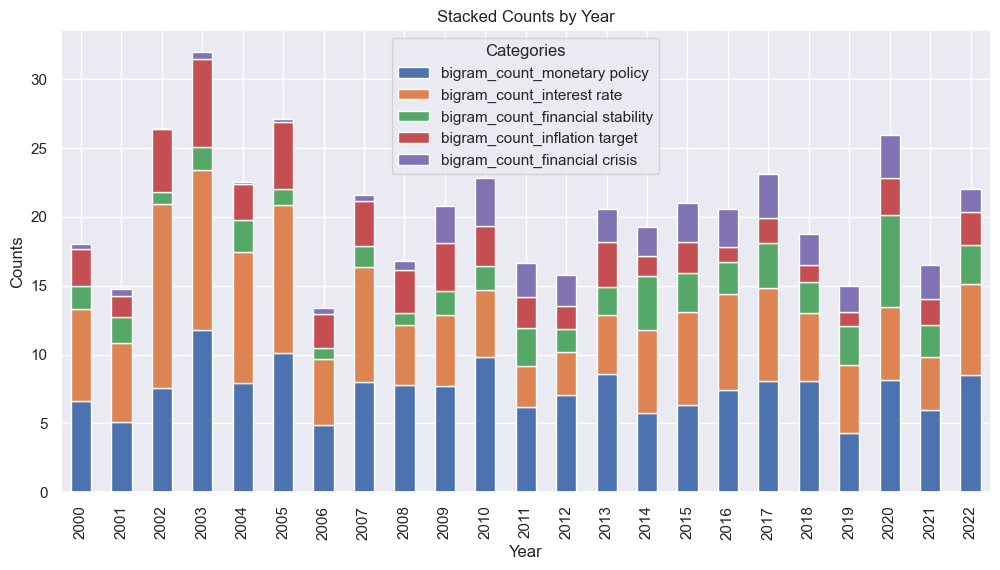

In [608]:
# Select columns to stack (all or specific)
columns_to_plot = ['bigram_count_monetary policy', 'bigram_count_interest rate', 'bigram_count_financial stability',
                   'bigram_count_inflation target', 'bigram_count_financial crisis']

# Plot a stacked bar chart
ax = wordcount_speech[columns_to_plot].plot(kind='bar', stacked=True, figsize=(12, 6))

# Optional: add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Counts')
ax.set_title('Stacked Counts by Year')
plt.legend(title='Categories')
plt.show()

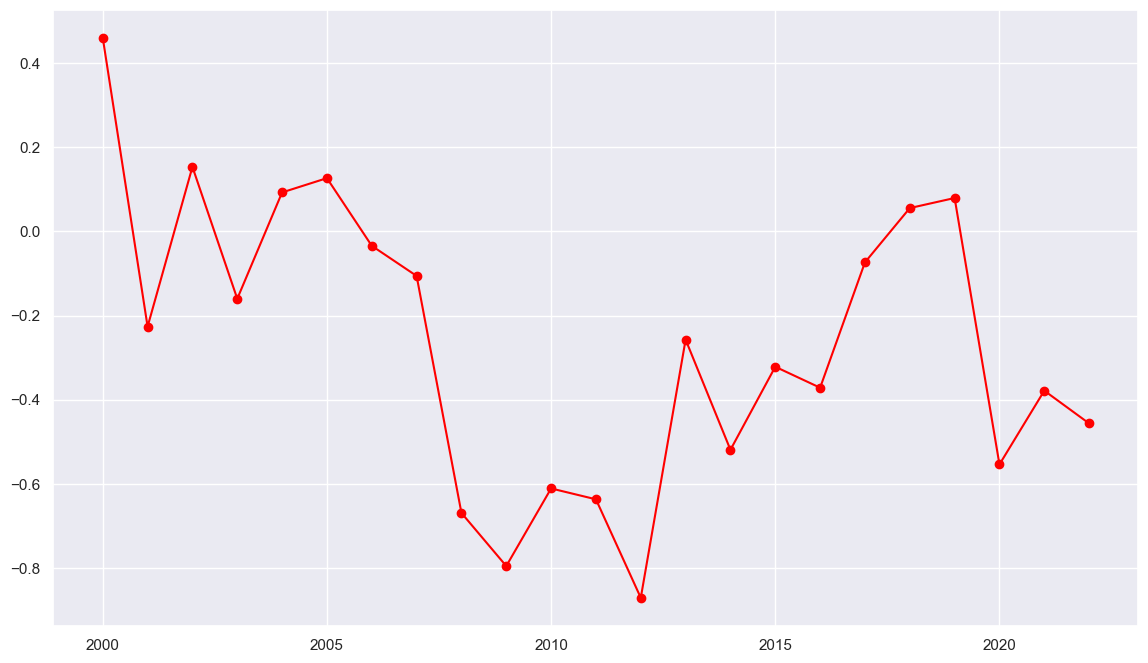

In [630]:
plt.figure()
plt.plot(wordcount_speech.index, wordcount_speech['sentiment_lexicon_weighted_std'], color='red', marker='o')
plt.show()

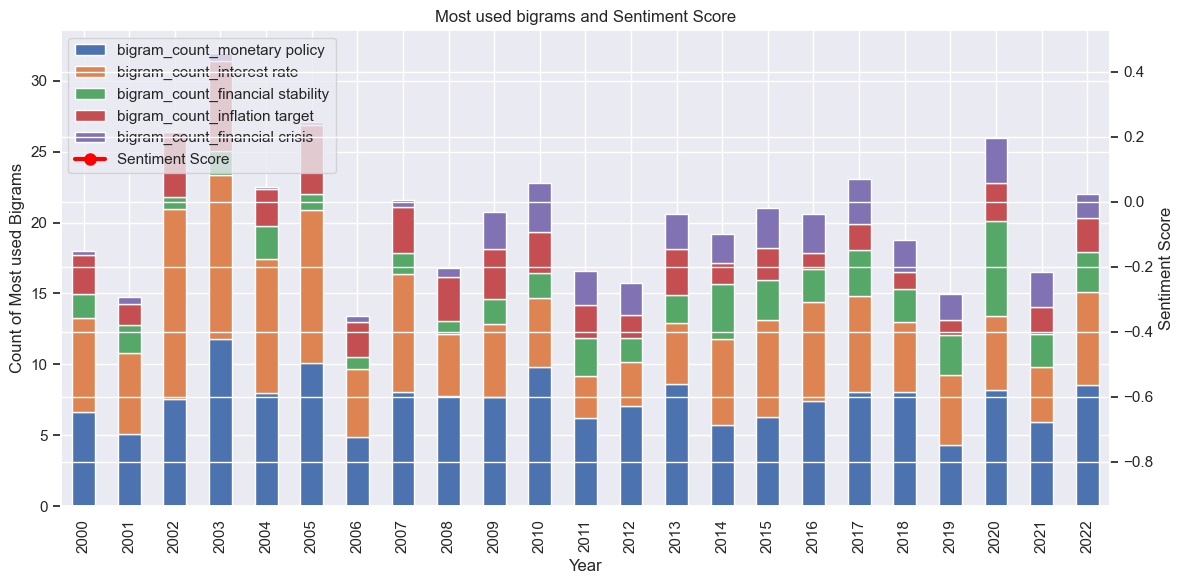

In [648]:
# Create a bar plot, grouped by default
ax = wordcount_speech[['bigram_count_monetary policy', 'bigram_count_interest rate', 'bigram_count_financial stability',
                   'bigram_count_inflation target', 'bigram_count_financial crisis']].plot(
                    kind='bar', stacked=True, alpha=0.7, figsize=(12, 6)
)

# Create a secondary axis for the line plot
ax2 = ax.twinx()

# Plot the line data on the secondary axis
line, = ax2.plot(
    wordcount_speech.index,
    wordcount_speech['sentiment_lexicon_weighted_std'],
    color='red',
    marker='o',
    linewidth=3,
    markersize=8,
    zorder=10,
    label='Sentiment Score'
)

ax2.set_zorder(10)
ax2.patch.set_zorder(11)  

# Set labels
ax.set_xlabel('Year')
ax.set_ylabel('Count of Most used Bigrams')
ax2.set_ylabel('Sentiment Score')

# Title
plt.title('Most used bigrams and Sentiment Score')

# Combine legends
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = [line], ['Sentiment Score']
ax.legend(handles + handles2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

## 4. Exploratory Analysis for Correlation with Economic Indicators

**Prepare the data**

In [658]:
boe_speeches_2000_2022_yearly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   year                            23 non-null     datetime64[ns]
 1   sentiment_lexicon_simple        23 non-null     float64       
 2   sentiment_lexicon_simple_std    23 non-null     float64       
 3   sentiment_lexicon_weighted      23 non-null     float64       
 4   sentiment_lexicon_weighted_std  23 non-null     float64       
 5   uk_inflation_rate_CPIH          23 non-null     float64       
 6   uk_unemployment_rate            23 non-null     float64       
 7   uk_gdp_growth                   23 non-null     float64       
 8   uk_interest_rate                23 non-null     float64       
 9   uk_consumer_confidence          23 non-null     float64       
 10  gbp_usd_fx                      23 non-null     float64       
 11  ftse_250

### 4.1. Plot the data

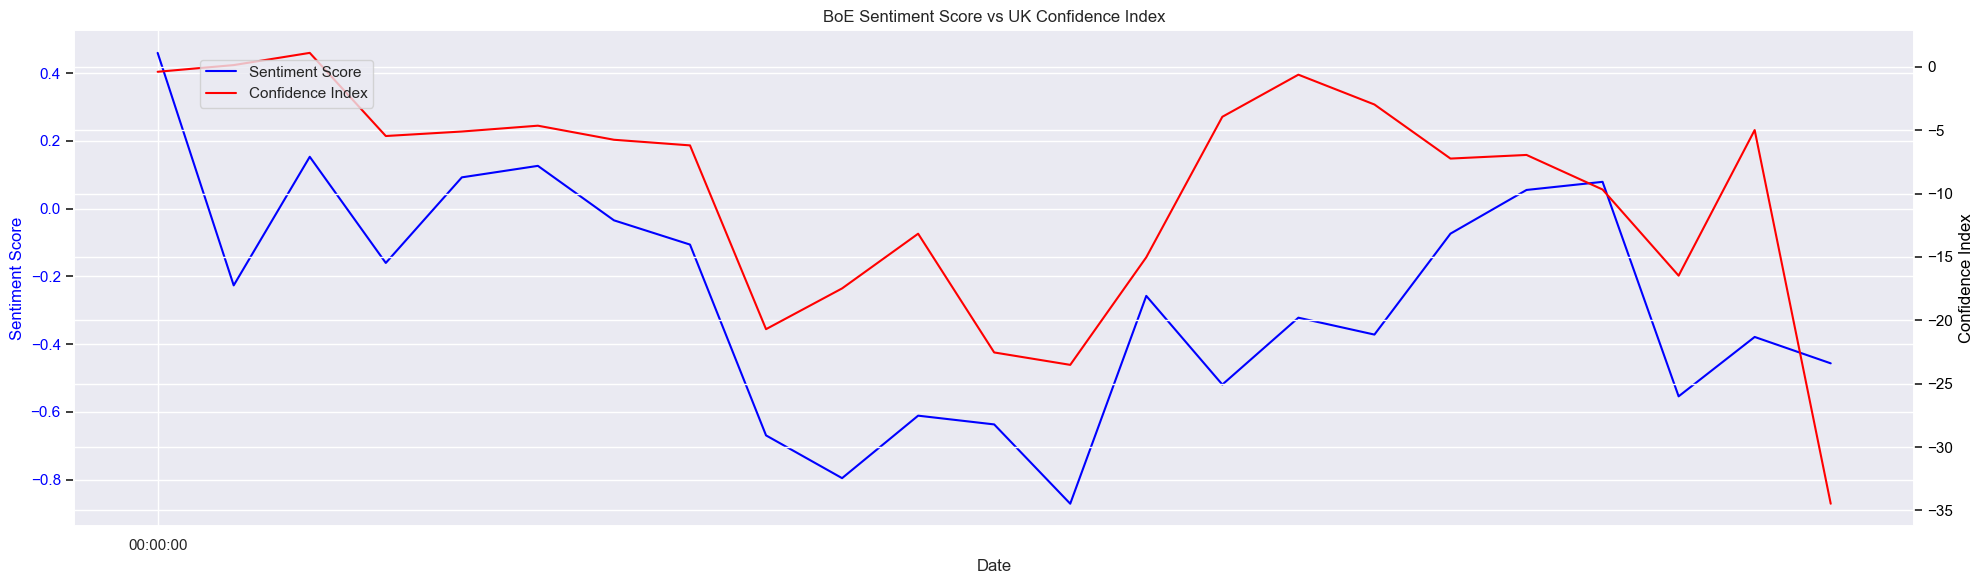

In [662]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['sentiment_lexicon_weighted_std'], color='blue', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['uk_consumer_confidence'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

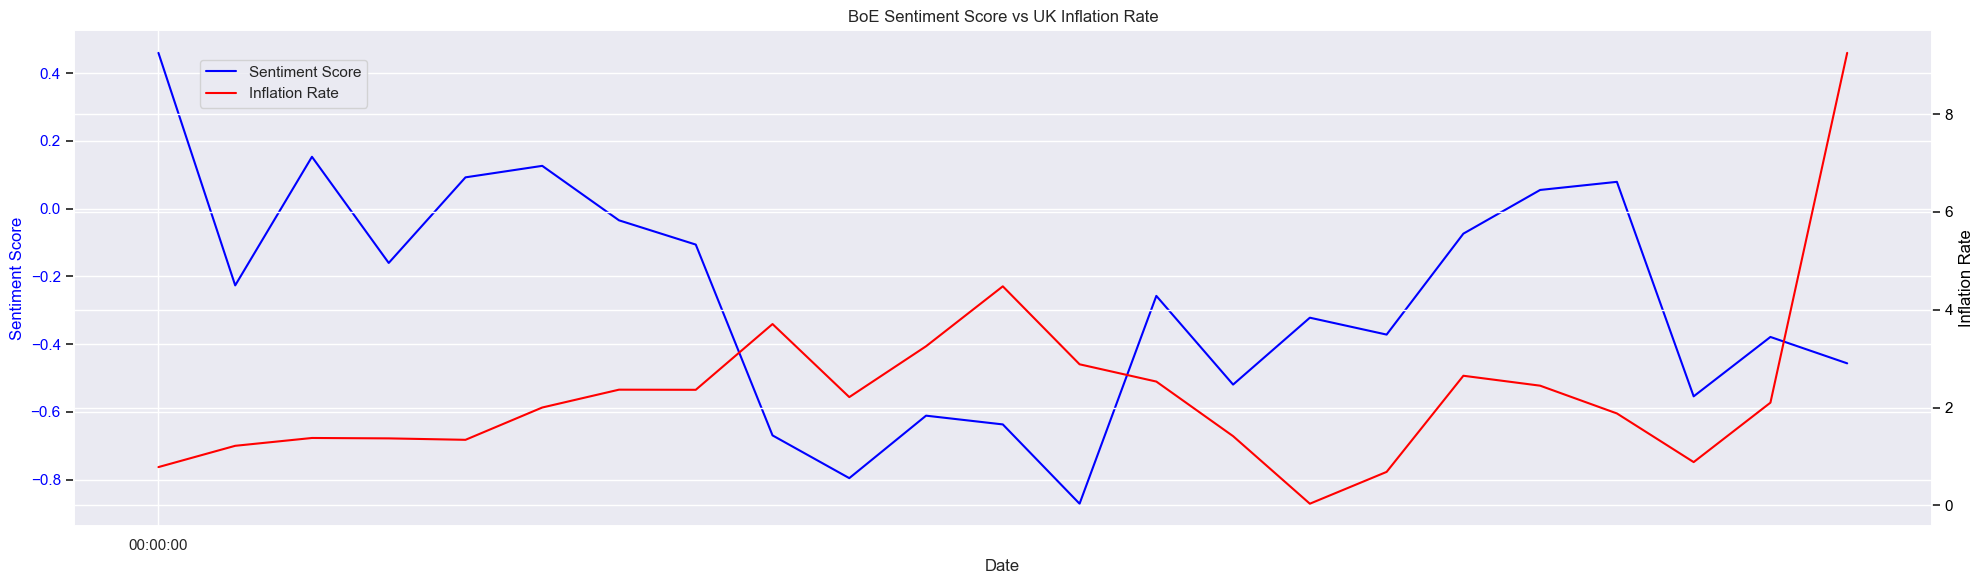

In [674]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['sentiment_lexicon_weighted_std'], color='blue', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['uk_inflation_rate_CPIH'], color='red', label='Inflation Rate')
ax2.set_ylabel('Inflation Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs UK Inflation Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

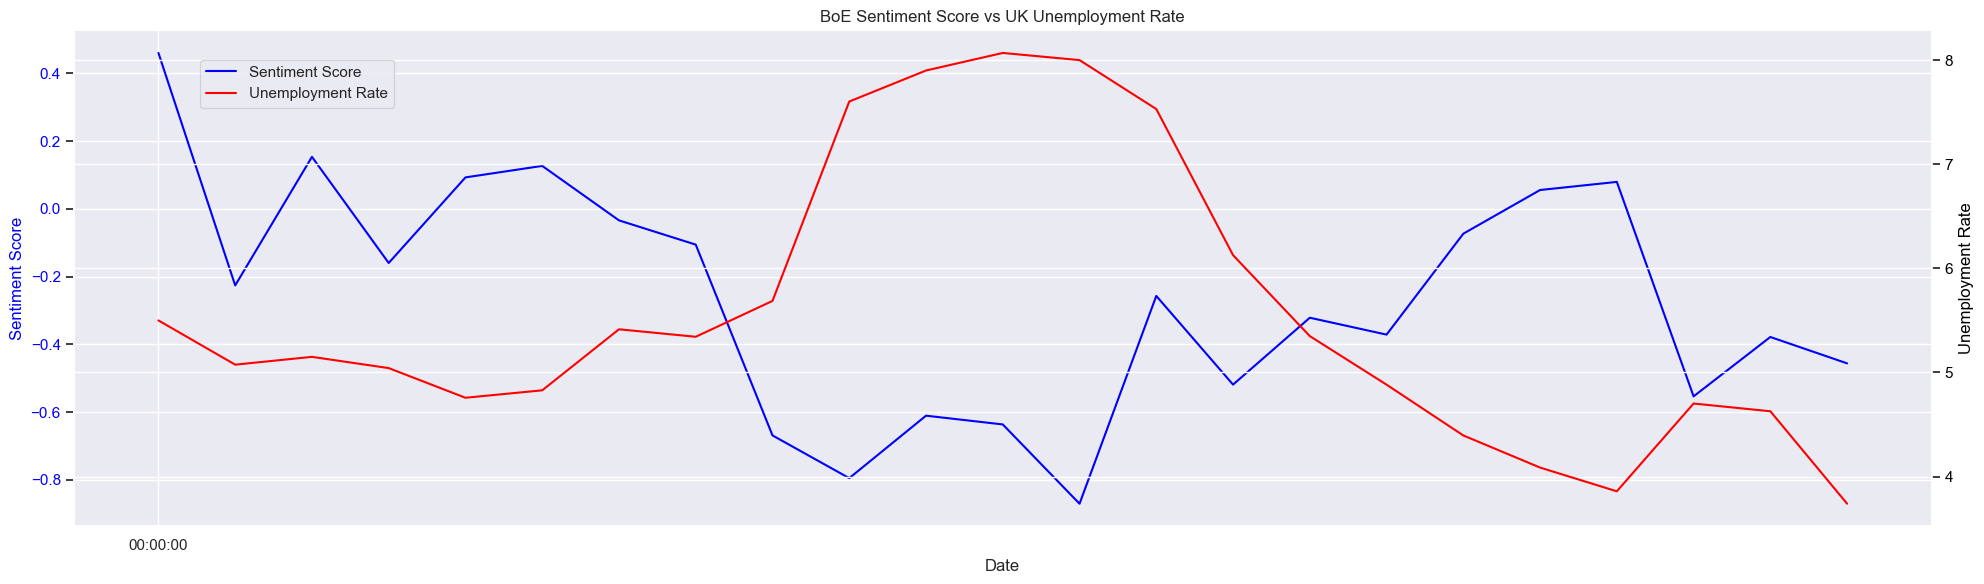

In [672]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['sentiment_lexicon_weighted_std'], color='blue', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['uk_unemployment_rate'], color='red', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs UK Unemployment Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

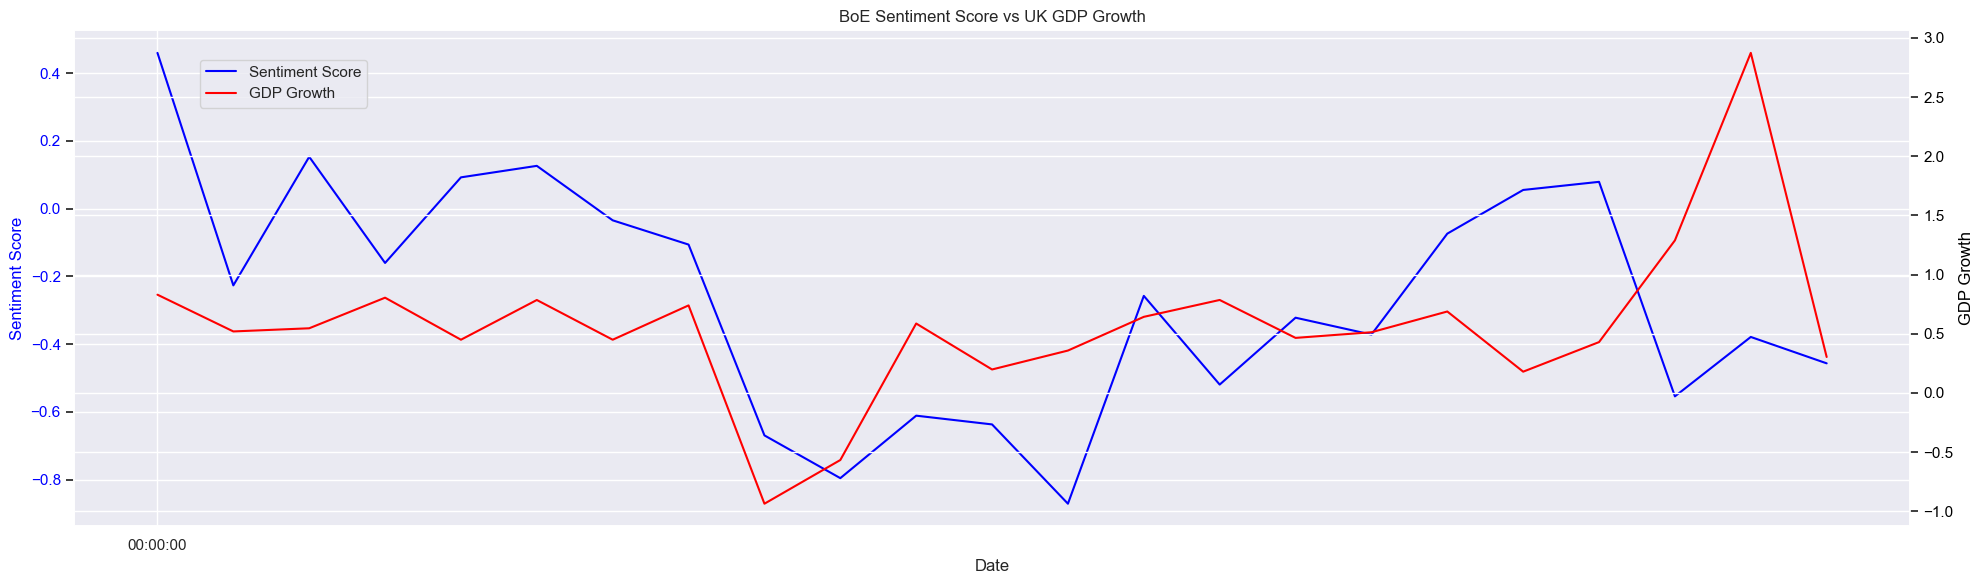

In [676]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['sentiment_lexicon_weighted_std'], color='blue', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['uk_gdp_growth'], color='red', label='GDP Growth')
ax2.set_ylabel('GDP Growth', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs UK GDP Growth')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

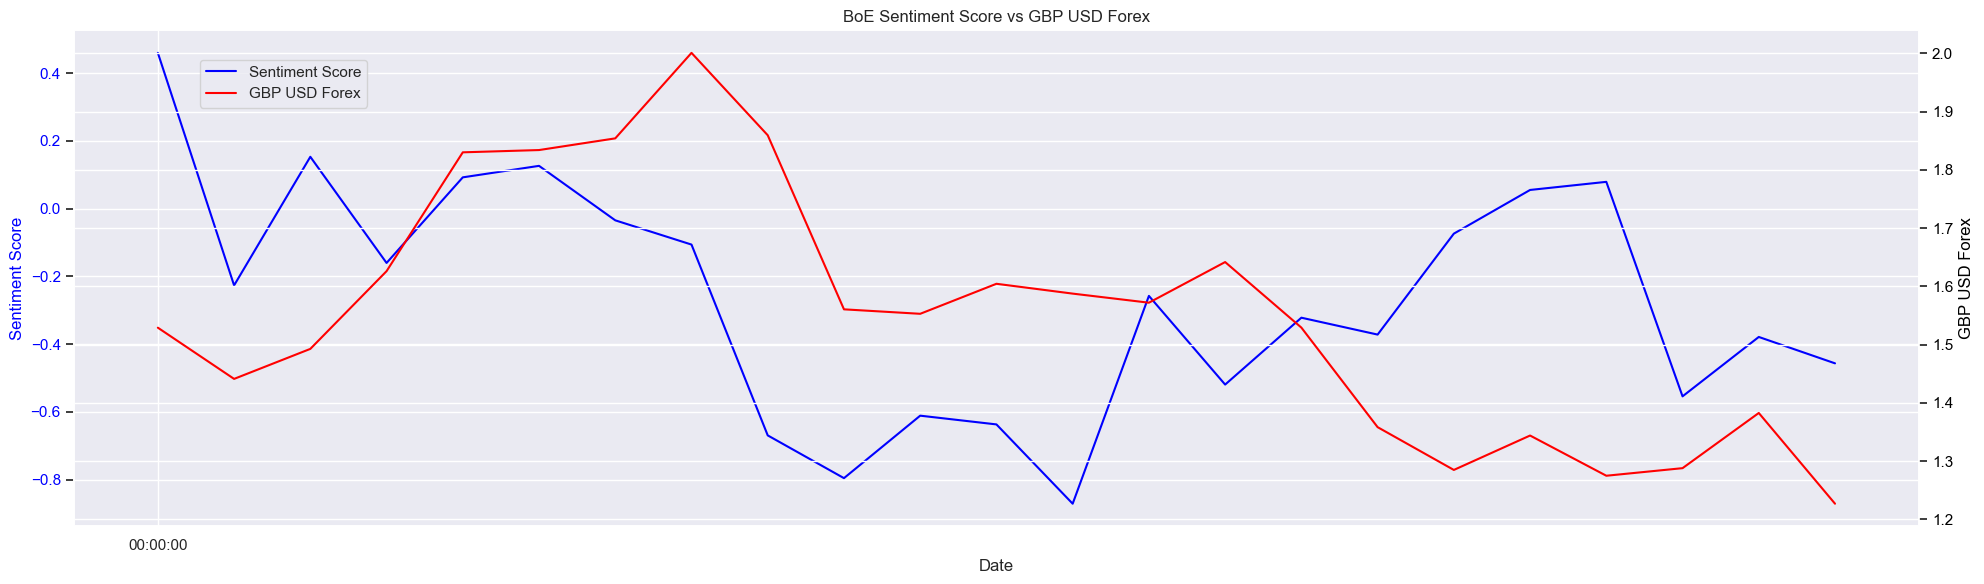

In [678]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['sentiment_lexicon_weighted_std'], color='blue', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['gbp_usd_fx'], color='red', label='GBP USD Forex')
ax2.set_ylabel('GBP USD Forex', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs GBP USD Forex')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

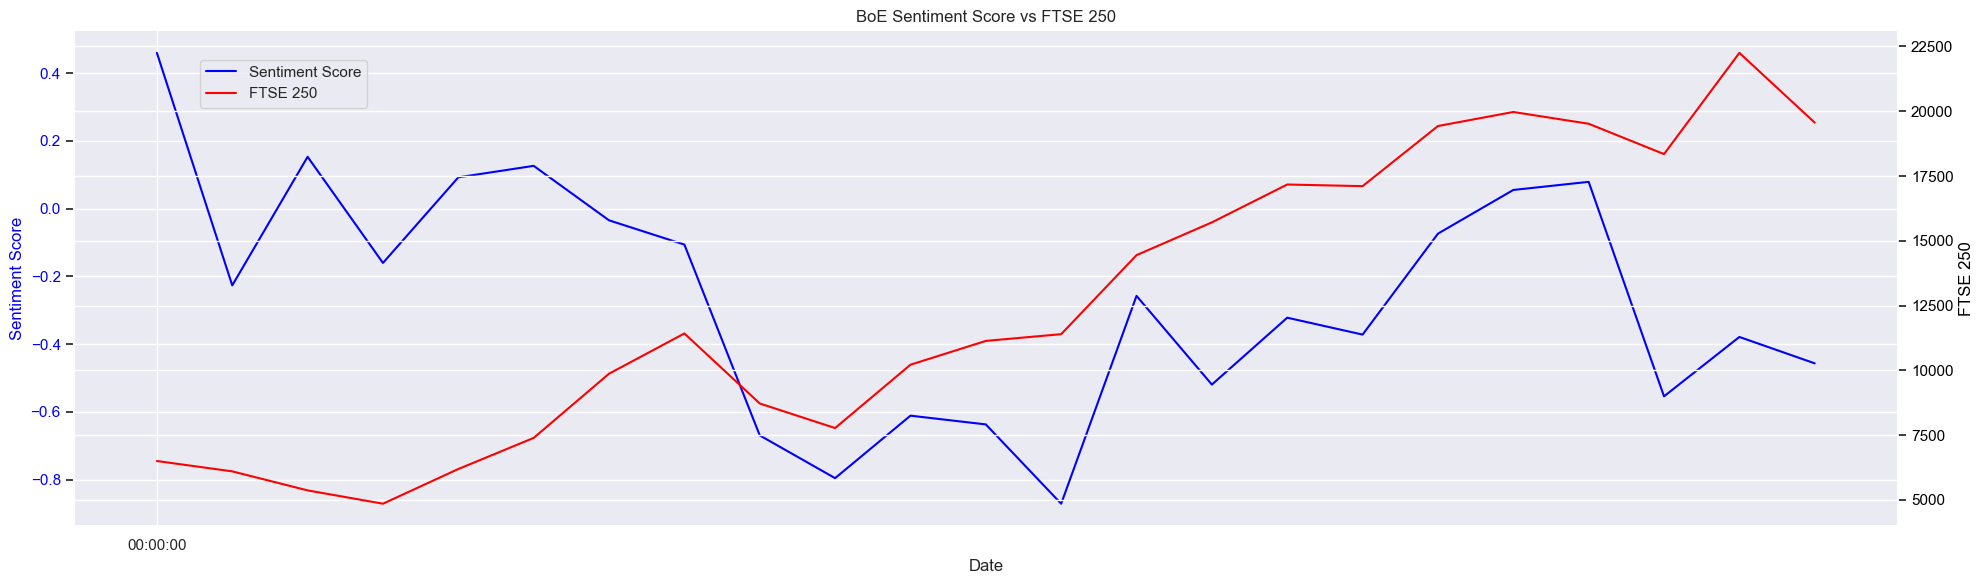

In [702]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['sentiment_lexicon_weighted_std'], color='blue', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['ftse_250'], color='red', label='FTSE 250')
ax2.set_ylabel('FTSE 250', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs FTSE 250')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

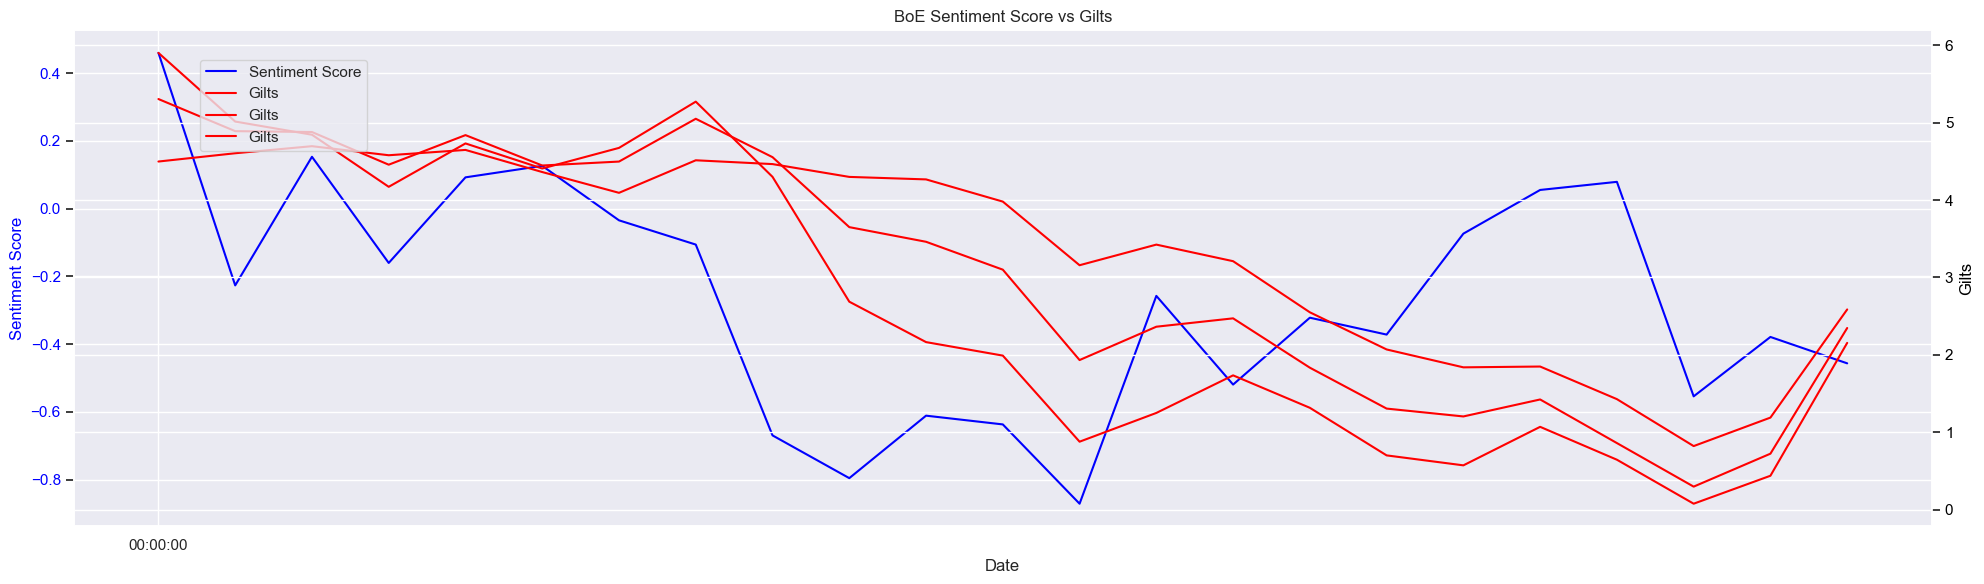

In [704]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['sentiment_lexicon_weighted_std'], color='blue', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly[['gilts_short ', 'gilts_medium ', 'gilts_long ']], color='red', label='Gilts')
ax2.set_ylabel('Gilts', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs Gilts')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

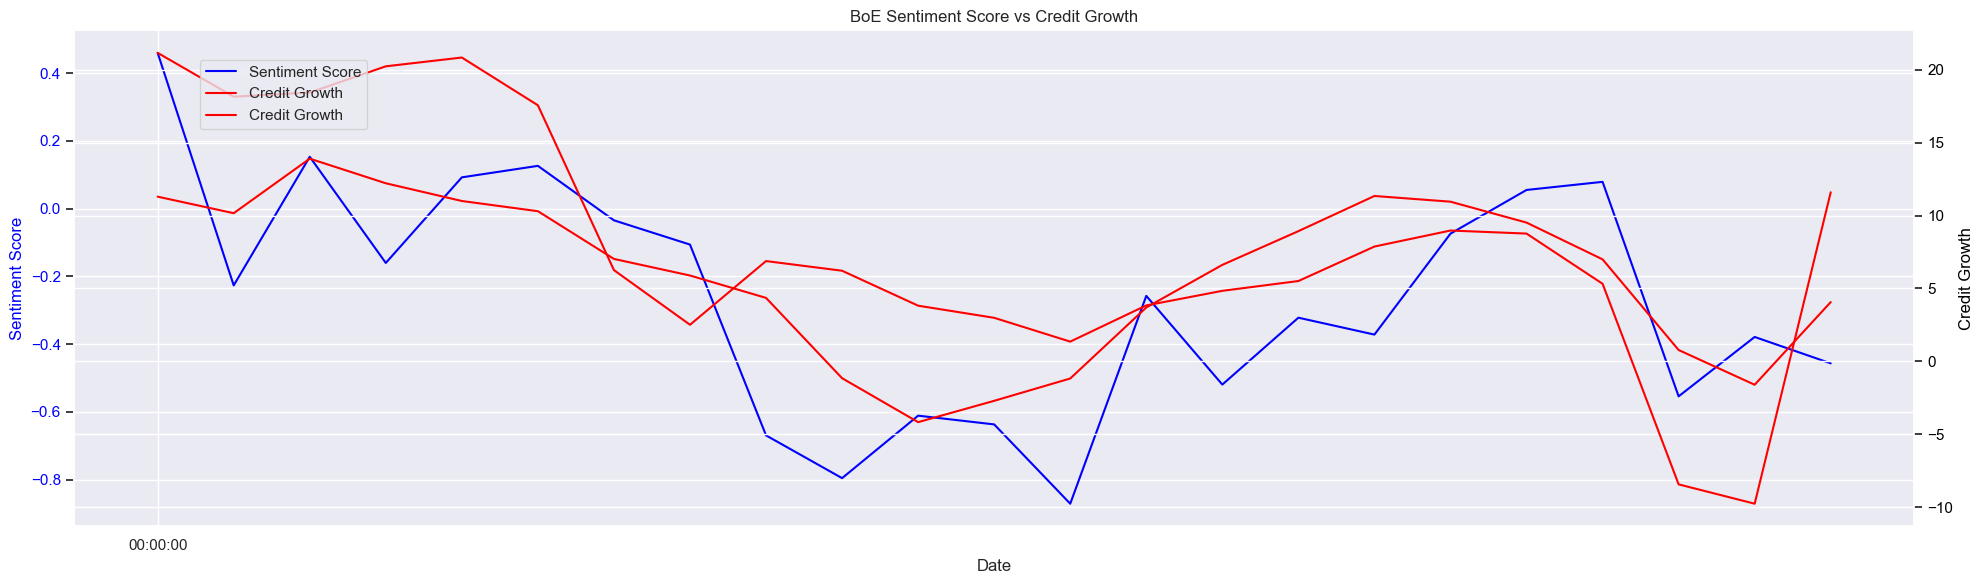

In [708]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['sentiment_lexicon_weighted_std'], color='blue', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly[['uk_credit_growth_no_cc', 'uk_credit_growth_only_cc']], color='red', label='Credit Growth')
ax2.set_ylabel('Credit Growth', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs Credit Growth')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

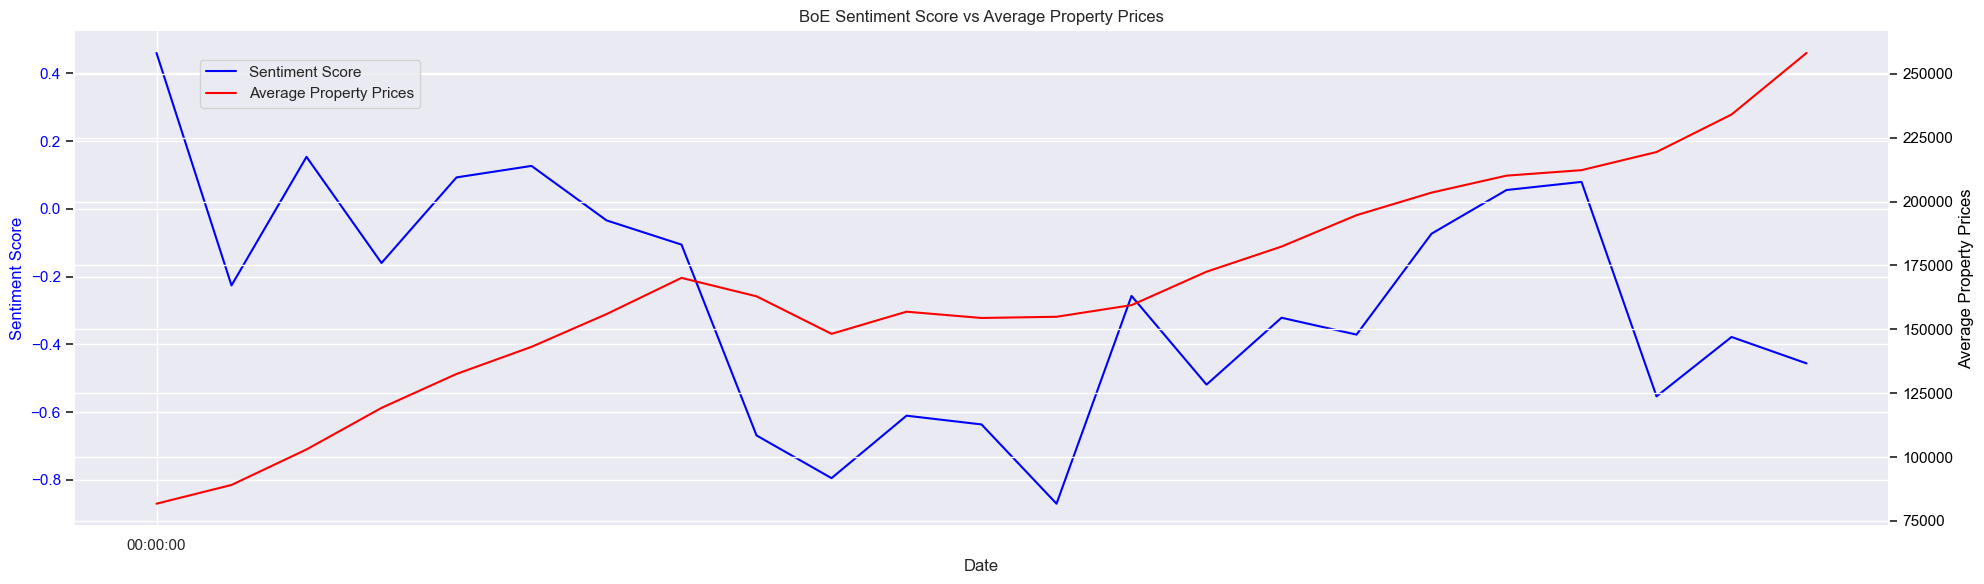

In [710]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['sentiment_lexicon_weighted_std'], color='blue', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_2000_2022_yearly['year'], boe_speeches_2000_2022_yearly['avg_price_all_property_types'], color='red', label='Average Property Prices')
ax2.set_ylabel('Average Property Prices', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs Average Property Prices')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

### 4.3. Initial statistical analysis

In [754]:
boe_indicators_2000_2022.columns

Index(['index', 'reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std',
       'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
       'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250',
       'gilts_short ', 'gilts_medium ', 'gilts_long ',
       'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
       'avg_price_all_property_types', 'bigram_count_monetary policy',
       'bigram_count_interest rate', 'bigram_count_financial stability',
       'bigram_count_inflation target', 'bigram_count_financial crisis'],
      dtype='object')

**4.3.a. GPT Analysis**

In [792]:
# Create a pairplot for sentiment score and all economic indicators.
columns_sentiment = ['sentiment_lexicon_weighted_std', 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
                             'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ', 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
                             'avg_price_all_property_types']

# Correlation matrix for GPT sentiment score with all economic indicators
correlation_matrix = boe_indicators_2000_2022[columns_sentiment].corr()

# Display the correlation matrix
correlation_matrix

sentiment_lexicon_weighted_std  \
sentiment_lexicon_weighted_std                        1.000000   
uk_inflation_rate_CPIH                               -0.102518   
uk_unemployment_rate                                 -0.230597   
uk_gdp_growth                                        -0.003600   
uk_interest_rate                                      0.170816   
uk_consumer_confidence                                0.225673   
gbp_usd_fx                                           -0.020808   
ftse_250                                              0.020278   
gilts_short                                           0.127109   
gilts_medium                                          0.066690   
gilts_long                                           -0.013122   
uk_credit_growth_no_cc                                0.267589   
uk_credit_growth_only_cc                              0.200058   
avg_price_all_property_types                         -0.051533   

                                uk_inflation_rate_CPIH  uk_unemployment_rate  \
sentiment_lexicon_weighted_std               -0.102518             -0.230597   
uk_inflation_rate_CPIH                        1.000000              0.072471   
uk_unemployment_rate                          0.072471              1.000000   
uk_gdp_growth                                -0.053272             -0.023539   
uk_interest_rate                             -0.046025             -0.152003   
uk_consumer_confidence                       -0.751142             -0.341420   
gbp_usd_fx                                   -0.110252              0.431302   
ftse_250                                      0.064058             -0.480986   
gilts_short                                   0.033437              0.050080   
gilts_medium                                  0.081911              0.268054   
gilts_long                                    0.112858              0.503391   
uk_credit_growth_no_cc                       -0.342770             -0.622415   
uk_credit_growth_only_cc                      0.057143             -0.191328   
avg_price_all_property_types                  0.304537             -0.475534   

                                uk_gdp_growth  uk_interest_rate  \
sentiment_lexicon_weighted_std      -0.003600          0.170816   
uk_inflation_rate_CPIH              -0.053272         -0.046025   
uk_unemployment_rate                -0.023539         -0.152003   
uk_gdp_growth                        1.000000         -0.045422   
uk_interest_rate                    -0.045422          1.000000   
uk_consumer_confidence               0.131793          0.236698   
gbp_usd_fx                          -0.028849          0.560070   
ftse_250                             0.109692         -0.679792   
gilts_short                         -0.069555          0.930028   
gilts_medium                        -0.085004          0.835359   
gilts_long                          -0.101357          0.666171   
uk_credit_growth_no_cc              -0.064768          0.394429   
uk_credit_growth_only_cc            -0.121601          0.583793   
avg_price_all_property_types         0.086479         -0.615198   

                                uk_consumer_confidence  gbp_usd_fx  ftse_250  \
sentiment_lexicon_weighted_std                0.225673   -0.020808  0.020278   
uk_inflation_rate_CPIH                       -0.751142   -0.110252  0.064058   
uk_unemployment_rate                         -0.341420    0.431302 -0.480986   
uk_gdp_growth                                 0.131793   -0.028849  0.109692   
uk_interest_rate                              0.236698    0.560070 -0.679792   
uk_consumer_confidence                        1.000000    0.105462  0.005452   
gbp_usd_fx                                    0.105462    1.000000 -0.618274   
ftse_250                                      0.005452   -0.618274  1.000000   
gilts_short                                   0.187871    0.627967 -0.791639   
gilts_medium                      

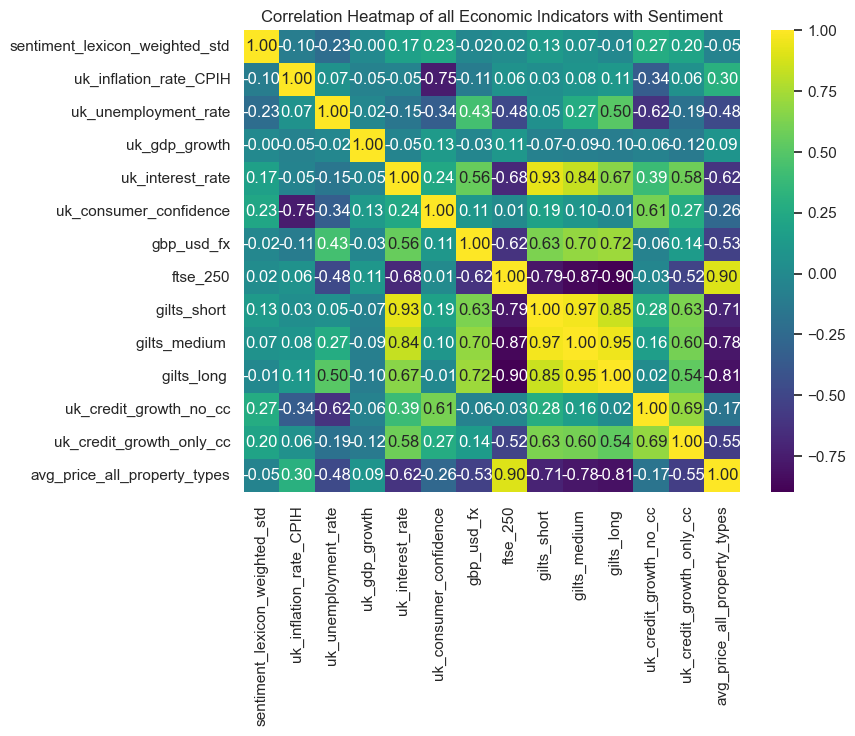

In [794]:
# Heatmap of the correlation matrix for GPT sentiment score with all economic indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of all Economic Indicators with Sentiment')
plt.show()

In [796]:
# Create a pairplot for GPT sentiment score and price/ inflation indicators
columns_sentiment_price = ['sentiment_lexicon_weighted_std', 'uk_inflation_rate_CPIH', 'uk_interest_rate',
                             'avg_price_all_property_types']

# Correlation matrix for GPT sentiment score with price/ inflation indicators
correlation_matrix_price = boe_indicators_2000_2022[columns_sentiment_price].corr()

# Display the correlation matrix
correlation_matrix_price

sentiment_lexicon_weighted_std  \
sentiment_lexicon_weighted_std                        1.000000   
uk_inflation_rate_CPIH                               -0.102518   
uk_interest_rate                                      0.170816   
avg_price_all_property_types                         -0.051533   

                                uk_inflation_rate_CPIH  uk_interest_rate  \
sentiment_lexicon_weighted_std               -0.102518          0.170816   
uk_inflation_rate_CPIH                        1.000000         -0.046025   
uk_interest_rate                             -0.046025          1.000000   
avg_price_all_property_types                  0.304537         -0.615198   

                                avg_price_all_property_types  
sentiment_lexicon_weighted_std                     -0.051533  
uk_inflation_rate_CPIH                              0.304537  
uk_interest_rate                                   -0.615198  
avg_price_all_property_types                        1.000000

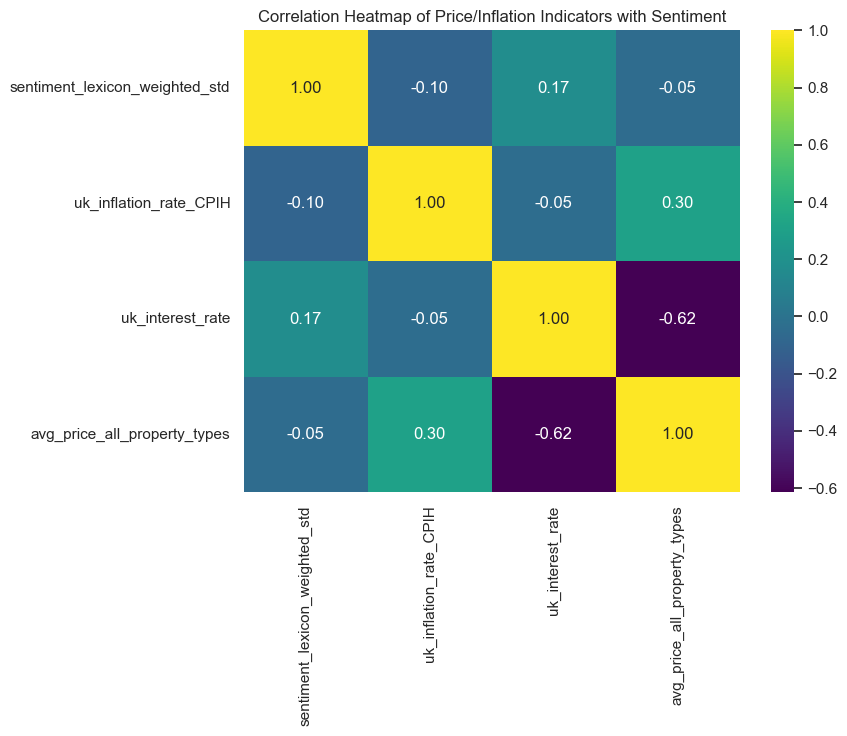

In [798]:
# Heatmap of the correlation matrix with price/ inflation indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_price, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Price/Inflation Indicators with Sentiment')
plt.show()

In [800]:
# Create a pairplot for GPT sentiment score and macroeconnomic indicators
columns_sentiment_macro = ['sentiment_lexicon_weighted_std', 'uk_gdp_growth', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence']

# Correlation matrix for GPT sentiment score with macroeconomic indicators
correlation_matrix_macro = boe_indicators_2000_2022[columns_sentiment_macro].corr()

# Display the correlation matrix
correlation_matrix_macro

sentiment_lexicon_weighted_std  uk_gdp_growth  \
sentiment_lexicon_weighted_std                        1.000000      -0.003600   
uk_gdp_growth                                        -0.003600       1.000000   
uk_unemployment_rate                                 -0.230597      -0.023539   
uk_credit_growth_no_cc                                0.267589      -0.064768   
uk_consumer_confidence                                0.225673       0.131793   

                                uk_unemployment_rate  uk_credit_growth_no_cc  \
sentiment_lexicon_weighted_std             -0.230597                0.267589   
uk_gdp_growth                              -0.023539               -0.064768   
uk_unemployment_rate                        1.000000               -0.622415   
uk_credit_growth_no_cc                     -0.622415                1.000000   
uk_consumer_confidence                     -0.341420                0.611659   

                                uk_consumer_confidence  
sentiment_lexicon_weighted_std                0.225673  
uk_gdp_growth                                 0.131793  
uk_unemployment_rate                         -0.341420  
uk_credit_growth_no_cc                        0.611659  
uk_consumer_confidence                        1.000000

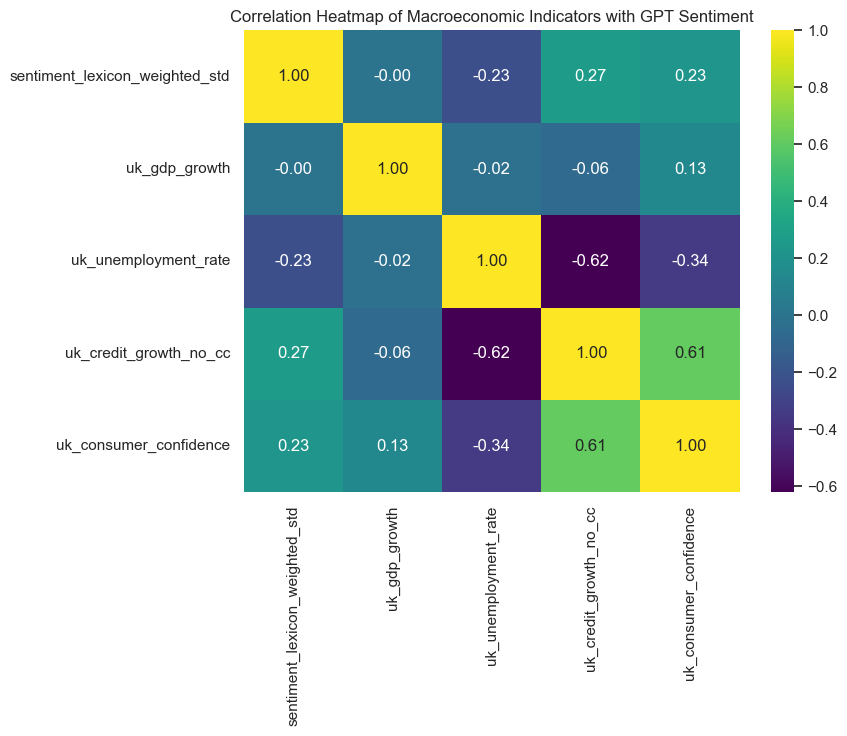

In [802]:
# Heatmap of the correlation matrix with macroeconomic indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_macro, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Macroeconomic Indicators with GPT Sentiment')
plt.show()

In [804]:
# Create a pairplot for GPT sentiment score and financial indicators
columns_sentiment_finance = ['sentiment_lexicon_weighted_std', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ']

# Correlation matrix for GPT sentiment score with financial indicators
correlation_matrix_finance = boe_speeches_indicators[columns_sentiment_finance].corr()

# Display the correlation matrix
correlation_matrix_finance

sentiment_lexicon_weighted_std  gbp_usd_fx  \
sentiment_lexicon_weighted_std                        1.000000   -0.017879   
gbp_usd_fx                                           -0.017879    1.000000   
ftse_250                                              0.010701   -0.619923   
gilts_short                                           0.128037    0.625451   
gilts_medium                                          0.071317    0.694390   
gilts_long                                           -0.004733    0.720624   

                                ftse_250  gilts_short   gilts_medium   \
sentiment_lexicon_weighted_std  0.010701      0.128037       0.071317   
gbp_usd_fx                     -0.619923      0.625451       0.694390   
ftse_250                        1.000000     -0.806288      -0.875311   
gilts_short                    -0.806288      1.000000       0.967729   
gilts_medium                   -0.875311      0.967729       1.000000   
gilts_long                     -0.902327      0.853808       0.953270   

                                gilts_long   
sentiment_lexicon_weighted_std    -0.004733  
gbp_usd_fx                         0.720624  
ftse_250                          -0.902327  
gilts_short                        0.853808  
gilts_medium                       0.953270  
gilts_long                         1.000000

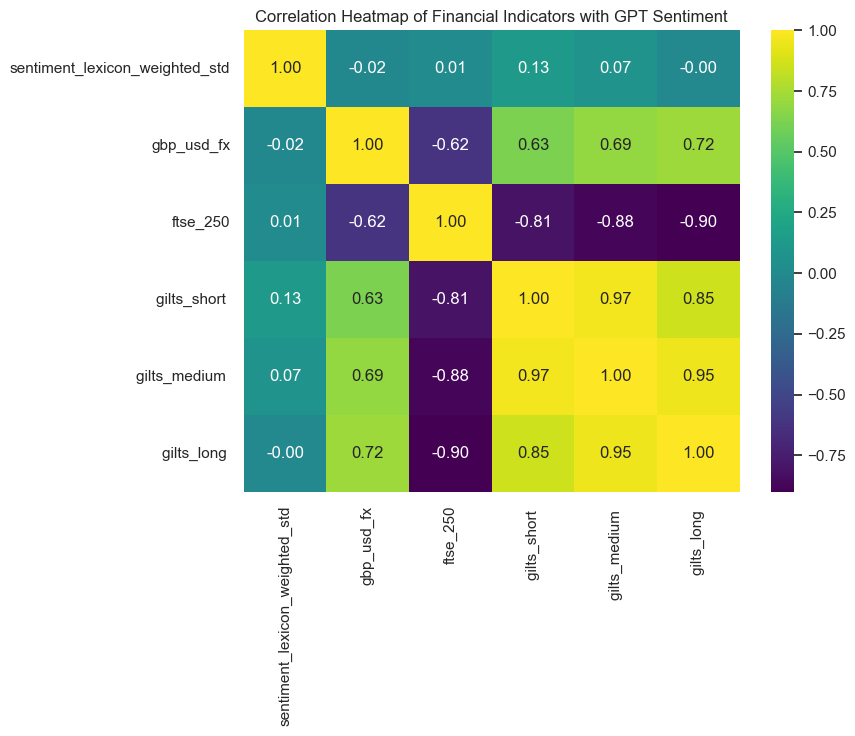

In [806]:
# Heatmap of the correlation matrix with finance indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_finance, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Financial Indicators with GPT Sentiment')
plt.show()

In [808]:
# Create a pairplot for GPT sentiment score and most impactful indicators
columns_sentiment_top = ['sentiment_lexicon_weighted_std', 'uk_interest_rate', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence', 'gilts_short ']

# Correlation matrix for GPT sentiment score with and most impactful indicators
correlation_matrix_top = boe_indicators_2000_2022[columns_sentiment_top].corr()

# Display the correlation matrix
correlation_matrix_top

sentiment_lexicon_weighted_std  \
sentiment_lexicon_weighted_std                        1.000000   
uk_interest_rate                                      0.170816   
uk_unemployment_rate                                 -0.230597   
uk_credit_growth_no_cc                                0.267589   
uk_consumer_confidence                                0.225673   
gilts_short                                           0.127109   

                                uk_interest_rate  uk_unemployment_rate  \
sentiment_lexicon_weighted_std          0.170816             -0.230597   
uk_interest_rate                        1.000000             -0.152003   
uk_unemployment_rate                   -0.152003              1.000000   
uk_credit_growth_no_cc                  0.394429             -0.622415   
uk_consumer_confidence                  0.236698             -0.341420   
gilts_short                             0.930028              0.050080   

                                uk_credit_growth_no_cc  \
sentiment_lexicon_weighted_std                0.267589   
uk_interest_rate                              0.394429   
uk_unemployment_rate                         -0.622415   
uk_credit_growth_no_cc                        1.000000   
uk_consumer_confidence                        0.611659   
gilts_short                                   0.283681   

                                uk_consumer_confidence  gilts_short   
sentiment_lexicon_weighted_std                0.225673      0.127109  
uk_interest_rate                              0.236698      0.930028  
uk_unemployment_rate                         -0.341420      0.050080  
uk_credit_growth_no_cc                        0.611659      0.283681  
uk_consumer_confidence                        1.000000      0.187871  
gilts_short                                   0.187871      1.000000

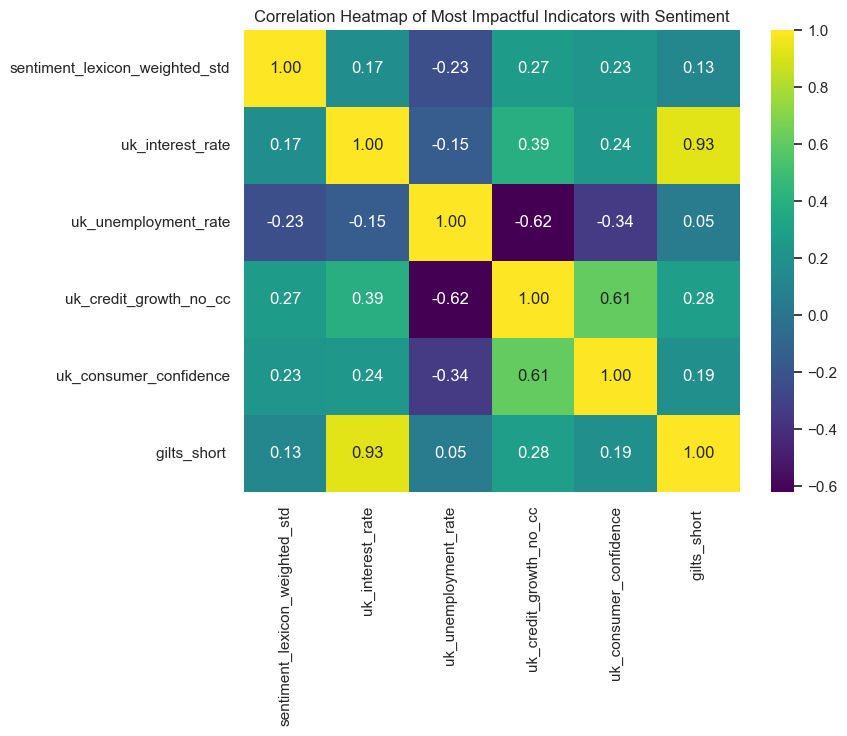

In [810]:
# Heatmap of the correlation matrix with most impactful indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_top, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Most Impactful Indicators with Sentiment')
plt.show()

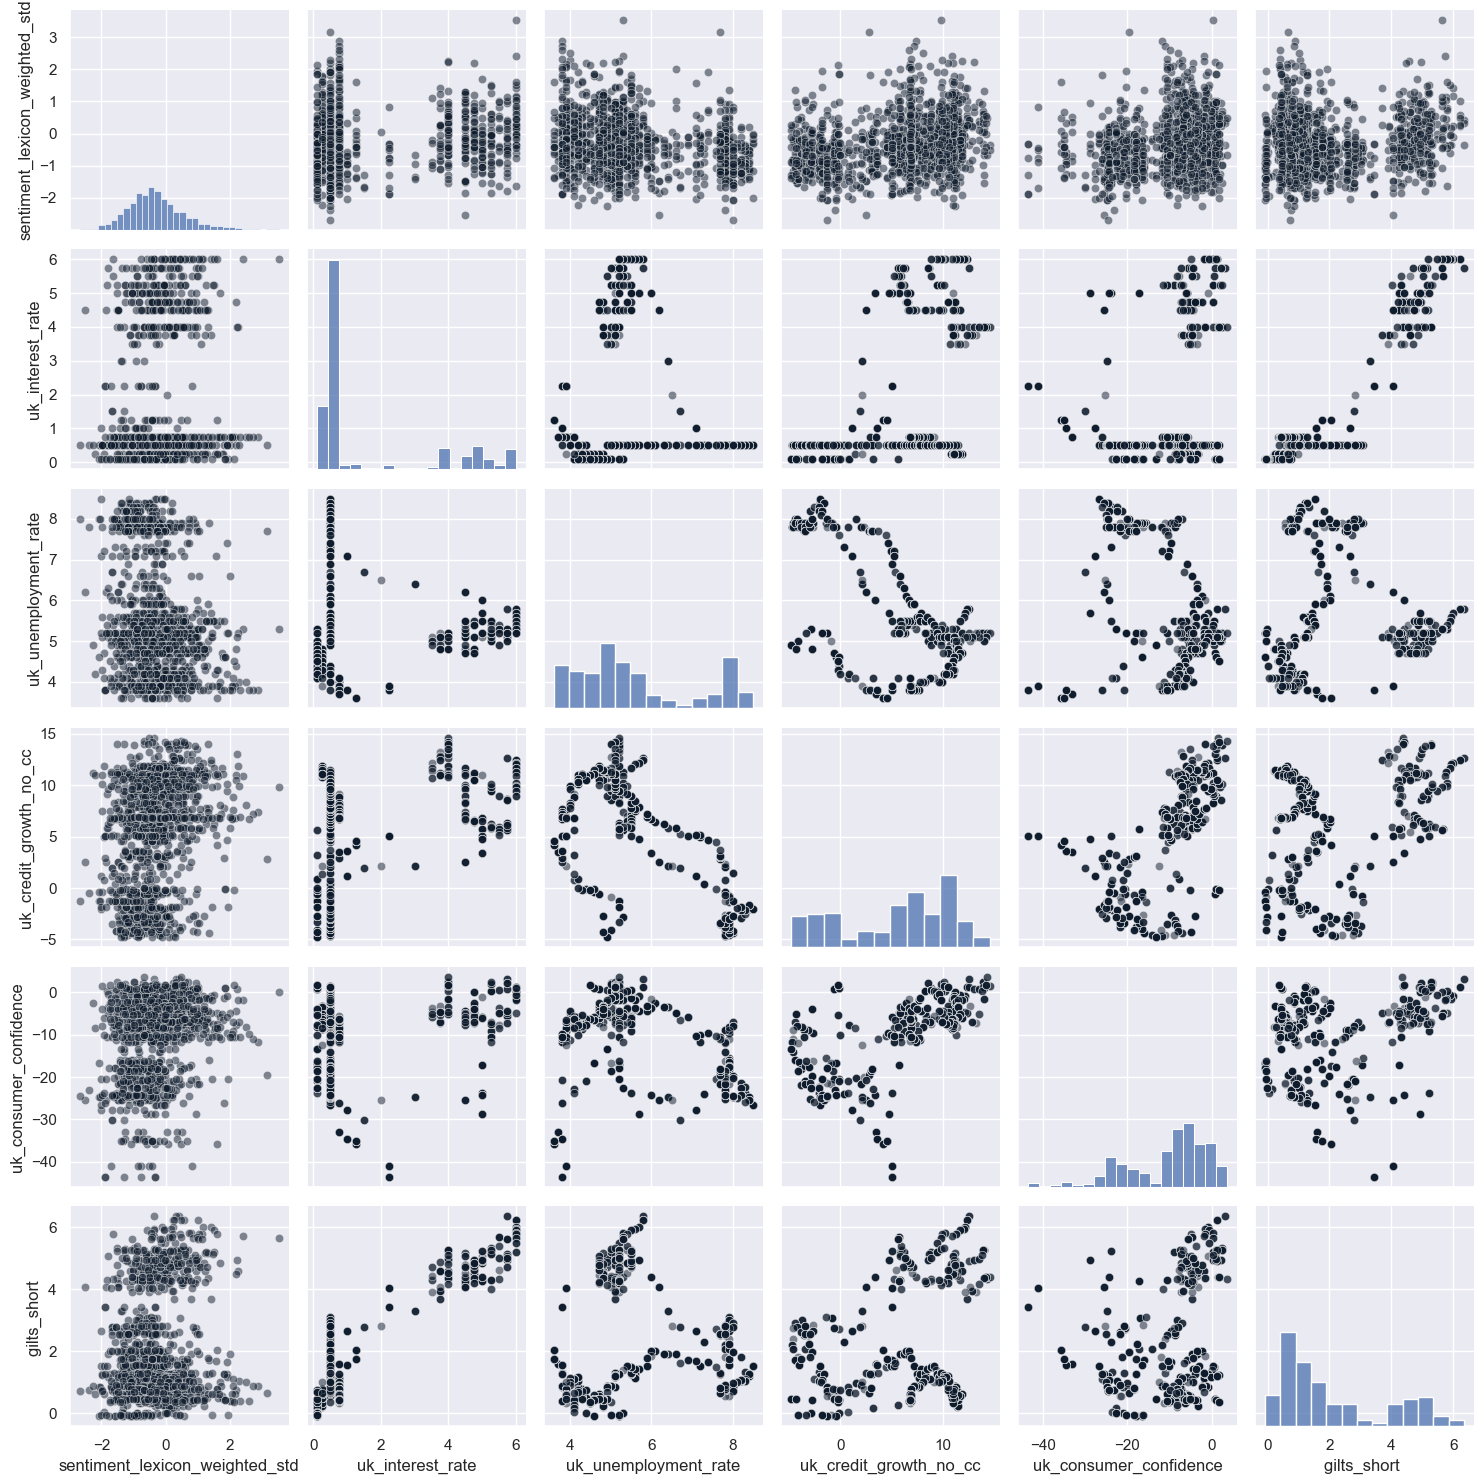

In [811]:
# Create a pairplot using only the specified columns
sns.pairplot(boe_indicators_2000_2022[columns_sentiment_top], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

## 5. Random Forests

In [826]:
# Copy the DataFranme for further manipulation
boe_rf = boe_indicators_2000_2022.copy()

In [828]:
boe_rf.head()

index     reference         country date_format year_month  year  \
0     38  r000107a_BOE  united kingdom  2000-01-07    2000-01  2000   
1     39  r000118a_BOE  united kingdom  2000-01-18    2000-01  2000   
2     40  r000126a_BOE  united kingdom  2000-01-26    2000-01  2000   
3     41  r000214a_BOE  united kingdom  2000-02-14    2000-02  2000   
4     42  r000216a_BOE  united kingdom  2000-02-16    2000-02  2000   

  year_month_dt                                      title  author  is_gov  \
0    2000-01-01        Monetary Policy: Theory in Practice    king       1   
1    2000-01-01                        City Council Dinner  george       1   
2    2000-01-01                                 Lunch 2000  george       1   
3    2000-02-01                Bankers Club Annual Banquet  george       1   
4    2000-02-01  The Euromoney International Bond Congress  george       1   

   ... gilts_medium  gilts_long  uk_credit_growth_no_cc  \
0  ...          5.74        4.69                   12.6   
1  ...          5.74        4.69                   12.6   
2  ...          5.74        4.69                   12.6   
3  ...          5.55        4.57                   12.4   
4  ...          5.55        4.57                   12.4   

   uk_credit_growth_only_cc  avg_price_all_property_types  \
0                      20.0                         77950   
1                      20.0                         77950   
2                      20.0                         77950   
3                      20.2                         77950   
4                      20.2                         77950   

   bigram_count_monetary policy  bigram_count_interest rate  \
0                            35                          12   
1                             5                          10   
2                             7                           2   
3                             2                           3   
4                             1                           3   

   bigram_count_financial stability  bigram_count_inflation target  \
0                                 0                             28   
1                                 0                              3   
2                                 0                              0   
3                                 4                              0   
4                                 0                              0   

   bigram_count_financial crisis  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  

[5 rows x 37 columns]

In [829]:
boe_rf.dtypes

index                                        int64
reference                                   object
country                                     object
date_format                         datetime64[ns]
year_month                               period[M]
year                                         int32
year_month_dt                       datetime64[ns]
title                                       object
author                                      object
is_gov                                       int64
text                                        object
text_lemmatised                             object
text_lemmatised_str                         object
word_count_text                              int64
word_count_text_cleaned                      int64
sentiment_lexicon_simple                   float64
sentiment_lexicon_simple_std               float64
sentiment_lexicon_weighted                 float64
sentiment_lexicon_weighted_std             float64
uk_inflation_rate_CPIH         

In [832]:
# Set 'date' as index for resampling
boe_rf.set_index('date_format', inplace=True)

In [834]:
# View the DataFrame
boe_rf.head()

index     reference         country year_month  year  \
date_format                                                         
2000-01-07      38  r000107a_BOE  united kingdom    2000-01  2000   
2000-01-18      39  r000118a_BOE  united kingdom    2000-01  2000   
2000-01-26      40  r000126a_BOE  united kingdom    2000-01  2000   
2000-02-14      41  r000214a_BOE  united kingdom    2000-02  2000   
2000-02-16      42  r000216a_BOE  united kingdom    2000-02  2000   

            year_month_dt                                      title  author  \
date_format                                                                    
2000-01-07     2000-01-01        Monetary Policy: Theory in Practice    king   
2000-01-18     2000-01-01                        City Council Dinner  george   
2000-01-26     2000-01-01                                 Lunch 2000  george   
2000-02-14     2000-02-01                Bankers Club Annual Banquet  george   
2000-02-16     2000-02-01  The Euromoney International Bond Congress  george   

             is_gov                                               text  ...  \
date_format                                                             ...   
2000-01-07        1  The theme of this speech is the convergence be...  ...   
2000-01-18        1  I read a Business Comment headline, in one of ...  ...   
2000-01-26        1  It seems only a very short time ago that I las...  ...   
2000-02-14        1  In my remarks last year I ventured to suggest ...  ...   
2000-02-16        1  Thank you Padraic. It's a pleasure, as always,...  ...   

            gilts_medium  gilts_long   uk_credit_growth_no_cc  \
date_format                                                     
2000-01-07           5.74        4.69                    12.6   
2000-01-18           5.74        4.69                    12.6   
2000-01-26           5.74        4.69                    12.6   
2000-02-14           5.55        4.57                    12.4   
2000-02-16           5.55        4.57                    12.4   

             uk_credit_growth_only_cc  avg_price_all_property_types  \
date_format                                                           
2000-01-07                       20.0                         77950   
2000-01-18                       20.0                         77950   
2000-01-26                       20.0                         77950   
2000-02-14                       20.2                         77950   
2000-02-16                       20.2                         77950   

             bigram_count_monetary policy  bigram_count_interest rate  \
date_format                                                             
2000-01-07                             35                          12   
2000-01-18                              5                          10   
2000-01-26                              7                           2   
2000-02-14                              2                           3   
2000-02-16                              1                           3   

             bigram_count_financial stability  bigram_count_inflation target  \
date_format                                                                    
2000-01-07                                  0                             28   
2000-01-18                                  0                              3   
2000-01-26                                  0                              0   
2000-02-14                                  4                              0   
2000-02-16                                  0                              0   

             bigram_count_financial crisis  
date_format                                 
2000-01-07                               0  
2000-01-18                               0  
2000-01-26                               0  
2000-02-14                               0  
2000-02-16                               0  

[5 rows x 36 columns]

### 5.1. Monthly Analysis with BoE Wordlist Sentiment Score

In [859]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_monthly = boe_rf.resample('M').agg({
            'sentiment_lexicon_weighted_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_monthly.reset_index(inplace=True)

In [861]:
# View the DataFrame
boe_rf_monthly.head()

date_format  sentiment_lexicon_weighted_std  uk_consumer_confidence  \
0  2000-01-31                        0.128783                     3.2   
1  2000-02-29                        0.509094                     1.3   
2  2000-03-31                        0.680356                    -0.8   
3  2000-04-30                       -0.072648                    -1.6   
4  2000-05-31                        0.125045                    -0.6   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                   0.797                   5.8            1.2   
1                   0.937                   5.8            1.2   
2                   0.637                   5.7            1.2   
3                   0.561                   5.6            0.7   
4                   0.537                   5.5            0.7   

   uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   gilts_medium   \
0              5.75    1.640185  6433.850488          6.35           5.74   
1              6.00    1.599814  6227.492862          6.22           5.55   
2              6.00    1.580222  6639.710874          6.00           5.27   
3              6.00    1.583694  6235.955539          5.94           5.23   
4              6.00    1.507538  6227.510045          5.90           5.35   

   gilts_long   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0         4.69                    12.6                      20.0   
1         4.57                    12.4                      20.2   
2         4.40                    12.2                      20.7   
3         4.50                    12.1                      19.6   
4         4.46                    11.7                      21.8   

   avg_price_all_property_types  
0                       77950.0  
1                       77950.0  
2                       77950.0  
3                       82197.0  
4                       82197.0

In [863]:
# Create date-related features
boe_rf_monthly['month'] = boe_rf_monthly['date_format'].dt.month
boe_rf_monthly['quarter'] = boe_rf_monthly['date_format'].dt.quarter
boe_rf_monthly['year'] = boe_rf_monthly['date_format'].dt.year

In [864]:
# View the DataFrame
boe_rf_monthly.head()

date_format  sentiment_lexicon_weighted_std  uk_consumer_confidence  \
0  2000-01-31                        0.128783                     3.2   
1  2000-02-29                        0.509094                     1.3   
2  2000-03-31                        0.680356                    -0.8   
3  2000-04-30                       -0.072648                    -1.6   
4  2000-05-31                        0.125045                    -0.6   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                   0.797                   5.8            1.2   
1                   0.937                   5.8            1.2   
2                   0.637                   5.7            1.2   
3                   0.561                   5.6            0.7   
4                   0.537                   5.5            0.7   

   uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   gilts_medium   \
0              5.75    1.640185  6433.850488          6.35           5.74   
1              6.00    1.599814  6227.492862          6.22           5.55   
2              6.00    1.580222  6639.710874          6.00           5.27   
3              6.00    1.583694  6235.955539          5.94           5.23   
4              6.00    1.507538  6227.510045          5.90           5.35   

   gilts_long   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0         4.69                    12.6                      20.0   
1         4.57                    12.4                      20.2   
2         4.40                    12.2                      20.7   
3         4.50                    12.1                      19.6   
4         4.46                    11.7                      21.8   

   avg_price_all_property_types  month  quarter  year  
0                       77950.0      1        1  2000  
1                       77950.0      2        1  2000  
2                       77950.0      3        1  2000  
3                       82197.0      4        2  2000  
4                       82197.0      5        2  2000

In [867]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly['sentiment_lexicon_weighted_std_lag_1m'] = boe_rf_monthly['sentiment_lexicon_weighted_std'].shift(1)

In [868]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly['sentiment_lexicon_weighted_std_lag_3m'] = boe_rf_monthly['sentiment_lexicon_weighted_std'].shift(3)

In [869]:
# View the DataFrame
boe_rf_monthly.head()

date_format  sentiment_lexicon_weighted_std  uk_consumer_confidence  \
0  2000-01-31                        0.128783                     3.2   
1  2000-02-29                        0.509094                     1.3   
2  2000-03-31                        0.680356                    -0.8   
3  2000-04-30                       -0.072648                    -1.6   
4  2000-05-31                        0.125045                    -0.6   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                   0.797                   5.8            1.2   
1                   0.937                   5.8            1.2   
2                   0.637                   5.7            1.2   
3                   0.561                   5.6            0.7   
4                   0.537                   5.5            0.7   

   uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   gilts_medium   \
0              5.75    1.640185  6433.850488          6.35           5.74   
1              6.00    1.599814  6227.492862          6.22           5.55   
2              6.00    1.580222  6639.710874          6.00           5.27   
3              6.00    1.583694  6235.955539          5.94           5.23   
4              6.00    1.507538  6227.510045          5.90           5.35   

   gilts_long   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0         4.69                    12.6                      20.0   
1         4.57                    12.4                      20.2   
2         4.40                    12.2                      20.7   
3         4.50                    12.1                      19.6   
4         4.46                    11.7                      21.8   

   avg_price_all_property_types  month  quarter  year  \
0                       77950.0      1        1  2000   
1                       77950.0      2        1  2000   
2                       77950.0      3        1  2000   
3                       82197.0      4        2  2000   
4                       82197.0      5        2  2000   

   sentiment_lexicon_weighted_std_lag_1m  \
0                                    NaN   
1                               0.128783   
2                               0.509094   
3                               0.680356   
4                              -0.072648   

   sentiment_lexicon_weighted_std_lag_3m  
0                                    NaN  
1                                    NaN  
2                                    NaN  
3                               0.128783  
4                               0.509094

In [873]:
# Drop first row(s) with NaN values due to lagging
boe_rf_monthly.dropna(inplace=True)

In [874]:
# Prepare features (X)
feature_cols = ['sentiment_lexicon_weighted_std', 'sentiment_lexicon_weighted_std_lag_1m', 'sentiment_lexicon_weighted_std_lag_3m', 'month', 'quarter', 'year']
X = boe_rf_monthly[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_monthly[target]

In [879]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'sentiment_lexicon_weighted_std',
    'sentiment_lexicon_weighted_std_lag_1m',
    'sentiment_lexicon_weighted_std_lag_3m',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_monthly[target]
    X = boe_rf_monthly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_monthly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")


Training model for: uk_consumer_confidence
RMSE: 12.421
R^2: -0.534

Training model for: uk_inflation_rate_CPIH
RMSE: 2.827
R^2: -0.014

Training model for: uk_unemployment_rate
RMSE: 0.510
R^2: -0.121

Training model for: uk_gdp_growth
RMSE: 6.883
R^2: 0.040

Training model for: uk_interest_rate
RMSE: 0.466
R^2: -0.166

Training model for: uk_consumer_confidence
RMSE: 12.421
R^2: -0.534

Training model for: gbp_usd_fx
RMSE: 0.097
R^2: -1.833

Training model for: ftse_250
RMSE: 1939.433
R^2: -0.063

Training model for: gilts_short 
RMSE: 0.728
R^2: -0.031

Training model for: gilts_medium 
RMSE: 0.754
R^2: -0.142

Training model for: gilts_long 
RMSE: 0.814
R^2: -0.654

Training model for: uk_credit_growth_no_cc
RMSE: 8.269
R^2: -2.606

Training model for: uk_credit_growth_only_cc
RMSE: 12.814
R^2: -0.655

Training model for: avg_price_all_property_types
RMSE: 26533.246
R^2: -1.621


### 5.2. Quarterly Analysis woth BoE Wordlist Sentiment Score

In [883]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_quarterly = boe_rf.resample('Q').agg({
            'sentiment_lexicon_weighted_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_quarterly.reset_index(inplace=True)

In [887]:
# Create date-related features
boe_rf_quarterly['month'] = boe_rf_quarterly['date_format'].dt.month
boe_rf_quarterly['quarter'] = boe_rf_quarterly['date_format'].dt.quarter
boe_rf_quarterly['year'] = boe_rf_quarterly['date_format'].dt.year

In [889]:
# Create lagged features (3 months lag is now 1 quarter lag)
boe_rf_quarterly['sentiment_lexicon_weighted_std_lag_1q'] = boe_rf_quarterly['sentiment_lexicon_weighted_std'].shift(1)

In [890]:
# View the DataFrame
boe_rf_quarterly.head()

date_format  sentiment_lexicon_weighted_std  uk_consumer_confidence  \
0  2000-03-31                        0.471103                1.075000   
1  2000-06-30                        0.285380               -1.200000   
2  2000-09-30                        0.443863               -1.785714   
3  2000-12-31                        0.776416               -0.200000   
4  2001-03-31                       -0.057172                1.410000   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                0.802000              5.766667            1.2   
1                0.634818              5.454545            0.7   
2                0.780429              5.328571            0.6   
3                1.029000              5.250000            0.6   
4                0.866000              5.090000            0.9   

   uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   gilts_medium   \
0            5.9375    1.603376  6416.488272      6.179167       5.504167   
1            6.0000    1.528795  6334.241608      5.863636       5.240909   
2            6.0000    1.480226  6821.744905      5.777143       5.244286   
3            6.0000    1.438341  6605.382946      5.560000       5.095000   
4            5.8250    1.457105  6527.893191      5.082000       4.839000   

   gilts_long   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0     4.543333               12.383333                 20.316667   
1     4.470909               11.663636                 21.163636   
2     4.451429               10.314286                 21.614286   
3     4.510000                9.600000                 22.300000   
4     4.358000                8.720000                 20.140000   

   avg_price_all_property_types  month  quarter  year  \
0                       77950.0      3        1  2000   
1                       82197.0      6        2  2000   
2                       83746.0      9        3  2000   
3                       86244.0     12        4  2000   
4                       85794.0      3        1  2001   

   sentiment_lexicon_weighted_std_lag_1q  
0                                    NaN  
1                               0.471103  
2                               0.285380  
3                               0.443863  
4                               0.776416

In [893]:
# Drop NaNs due to lag
boe_rf_quarterly.dropna(inplace=True)

In [895]:
# Prepare features (X)
feature_cols = ['sentiment_lexicon_weighted_std', 'sentiment_lexicon_weighted_std_lag_1q', 'month', 'quarter', 'year']
X = boe_rf_quarterly[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_quarterly[target]

In [897]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'sentiment_lexicon_weighted_std', 
    'sentiment_lexicon_weighted_std_lag_1q',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_quarterly[target]
    X = boe_rf_quarterly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_quarterly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")


Training model for: uk_consumer_confidence
RMSE: 14.965
R^2: -0.644

Training model for: uk_inflation_rate_CPIH
RMSE: 3.491
R^2: -0.166

Training model for: uk_unemployment_rate
RMSE: 0.815
R^2: -2.376

Training model for: uk_gdp_growth
RMSE: 6.443
R^2: -0.036

Training model for: uk_interest_rate
RMSE: 0.598
R^2: -0.168

Training model for: uk_consumer_confidence
RMSE: 14.965
R^2: -0.644

Training model for: gbp_usd_fx
RMSE: 0.106
R^2: -1.468

Training model for: ftse_250
RMSE: 1904.416
R^2: -0.164

Training model for: gilts_short 
RMSE: 0.967
R^2: -0.039

Training model for: gilts_medium 
RMSE: 0.919
R^2: -0.043

Training model for: gilts_long 
RMSE: 0.905
R^2: -0.239

Training model for: uk_credit_growth_no_cc
RMSE: 7.315
R^2: -2.143

Training model for: uk_credit_growth_only_cc
RMSE: 11.688
R^2: -0.502

Training model for: avg_price_all_property_types
RMSE: 34269.143
R^2: -2.450
